In [1]:
using LinearAlgebra
using Flux
using DiffEqFlux
using OrdinaryDiffEq
using DiffEqSensitivity
using GalacticOptim
using Optimization
using OptimizationOptimisers
using Plots
using Zygote
using BenchmarkTools
using CUDA
using Printf
using MLUtils
using IterTools: ncycle
using BSON: @save, @load

include("src/equations/initial_functions.jl")
include("src/equations/equations.jl")
include("src/utils/graphic_tools.jl")
include("src/utils/generators.jl")
include("src/neural_ode/objectives.jl")
include("src/neural_ode/models.jl")
include("src/neural_ode/models/blocks.jl")
include("src/neural_ode/regularization.jl")
include("src/rom/pod.jl")
include("src/utils/processing_tools.jl")

Main.ProcessingTools

# FOM + ROM solutions

Compute some fom and rom solution u(t, x)

## Test various burgers resolution method for FOM

Experiments with different initial conditions: Gaussian random, high dimensional random, sin, exp, -x, etc.

In [675]:
t_max = 4.; # 6 (godunov)
t_min = 0.;
x_max = 1.; # 2pi (godunov)
x_min = 0.;
t_n = 64;
x_n = 64;

nu = 0.001;

dt = round((t_max - t_min) / (t_n - 1), digits=8);
dx = round((x_max - x_min) / (x_n - 1), digits=8);

t = LinRange(t_min, t_max, t_n);
x = LinRange(x_min, x_max, x_n);

In [2]:
function animate_snapshot_prediction(u_pred, u, x, filename)
    t_n = 64
   
    anim = @animate for i ∈ 1:t_n
        plt = plot(x, u[:, i], label="u")
        plot!(plt, x, u_pred[:, i], linestyle=:dash, label="û")
        plot!(plt; xlims=(0., pi), ylims=(-2, 2.), dpi=300)
    end

    gif(anim, filename, fps = 15)
end

animate_snapshot_prediction (generic function with 1 method)

### Godunov

In [676]:
# u0 = InitialFunctions.high_dim_random_init(t, x, 10);
# u0 = exp.(-16 .* (x.^2));
u0 = InitialFunctions.advecting_shock(t, x, 0.001);
# u0 = random_init(t, x);
# u0 = InitialFunctions.random_gaussian_init(t, x, 0.25, 1.);
# u0 = -1 .* collect(x);

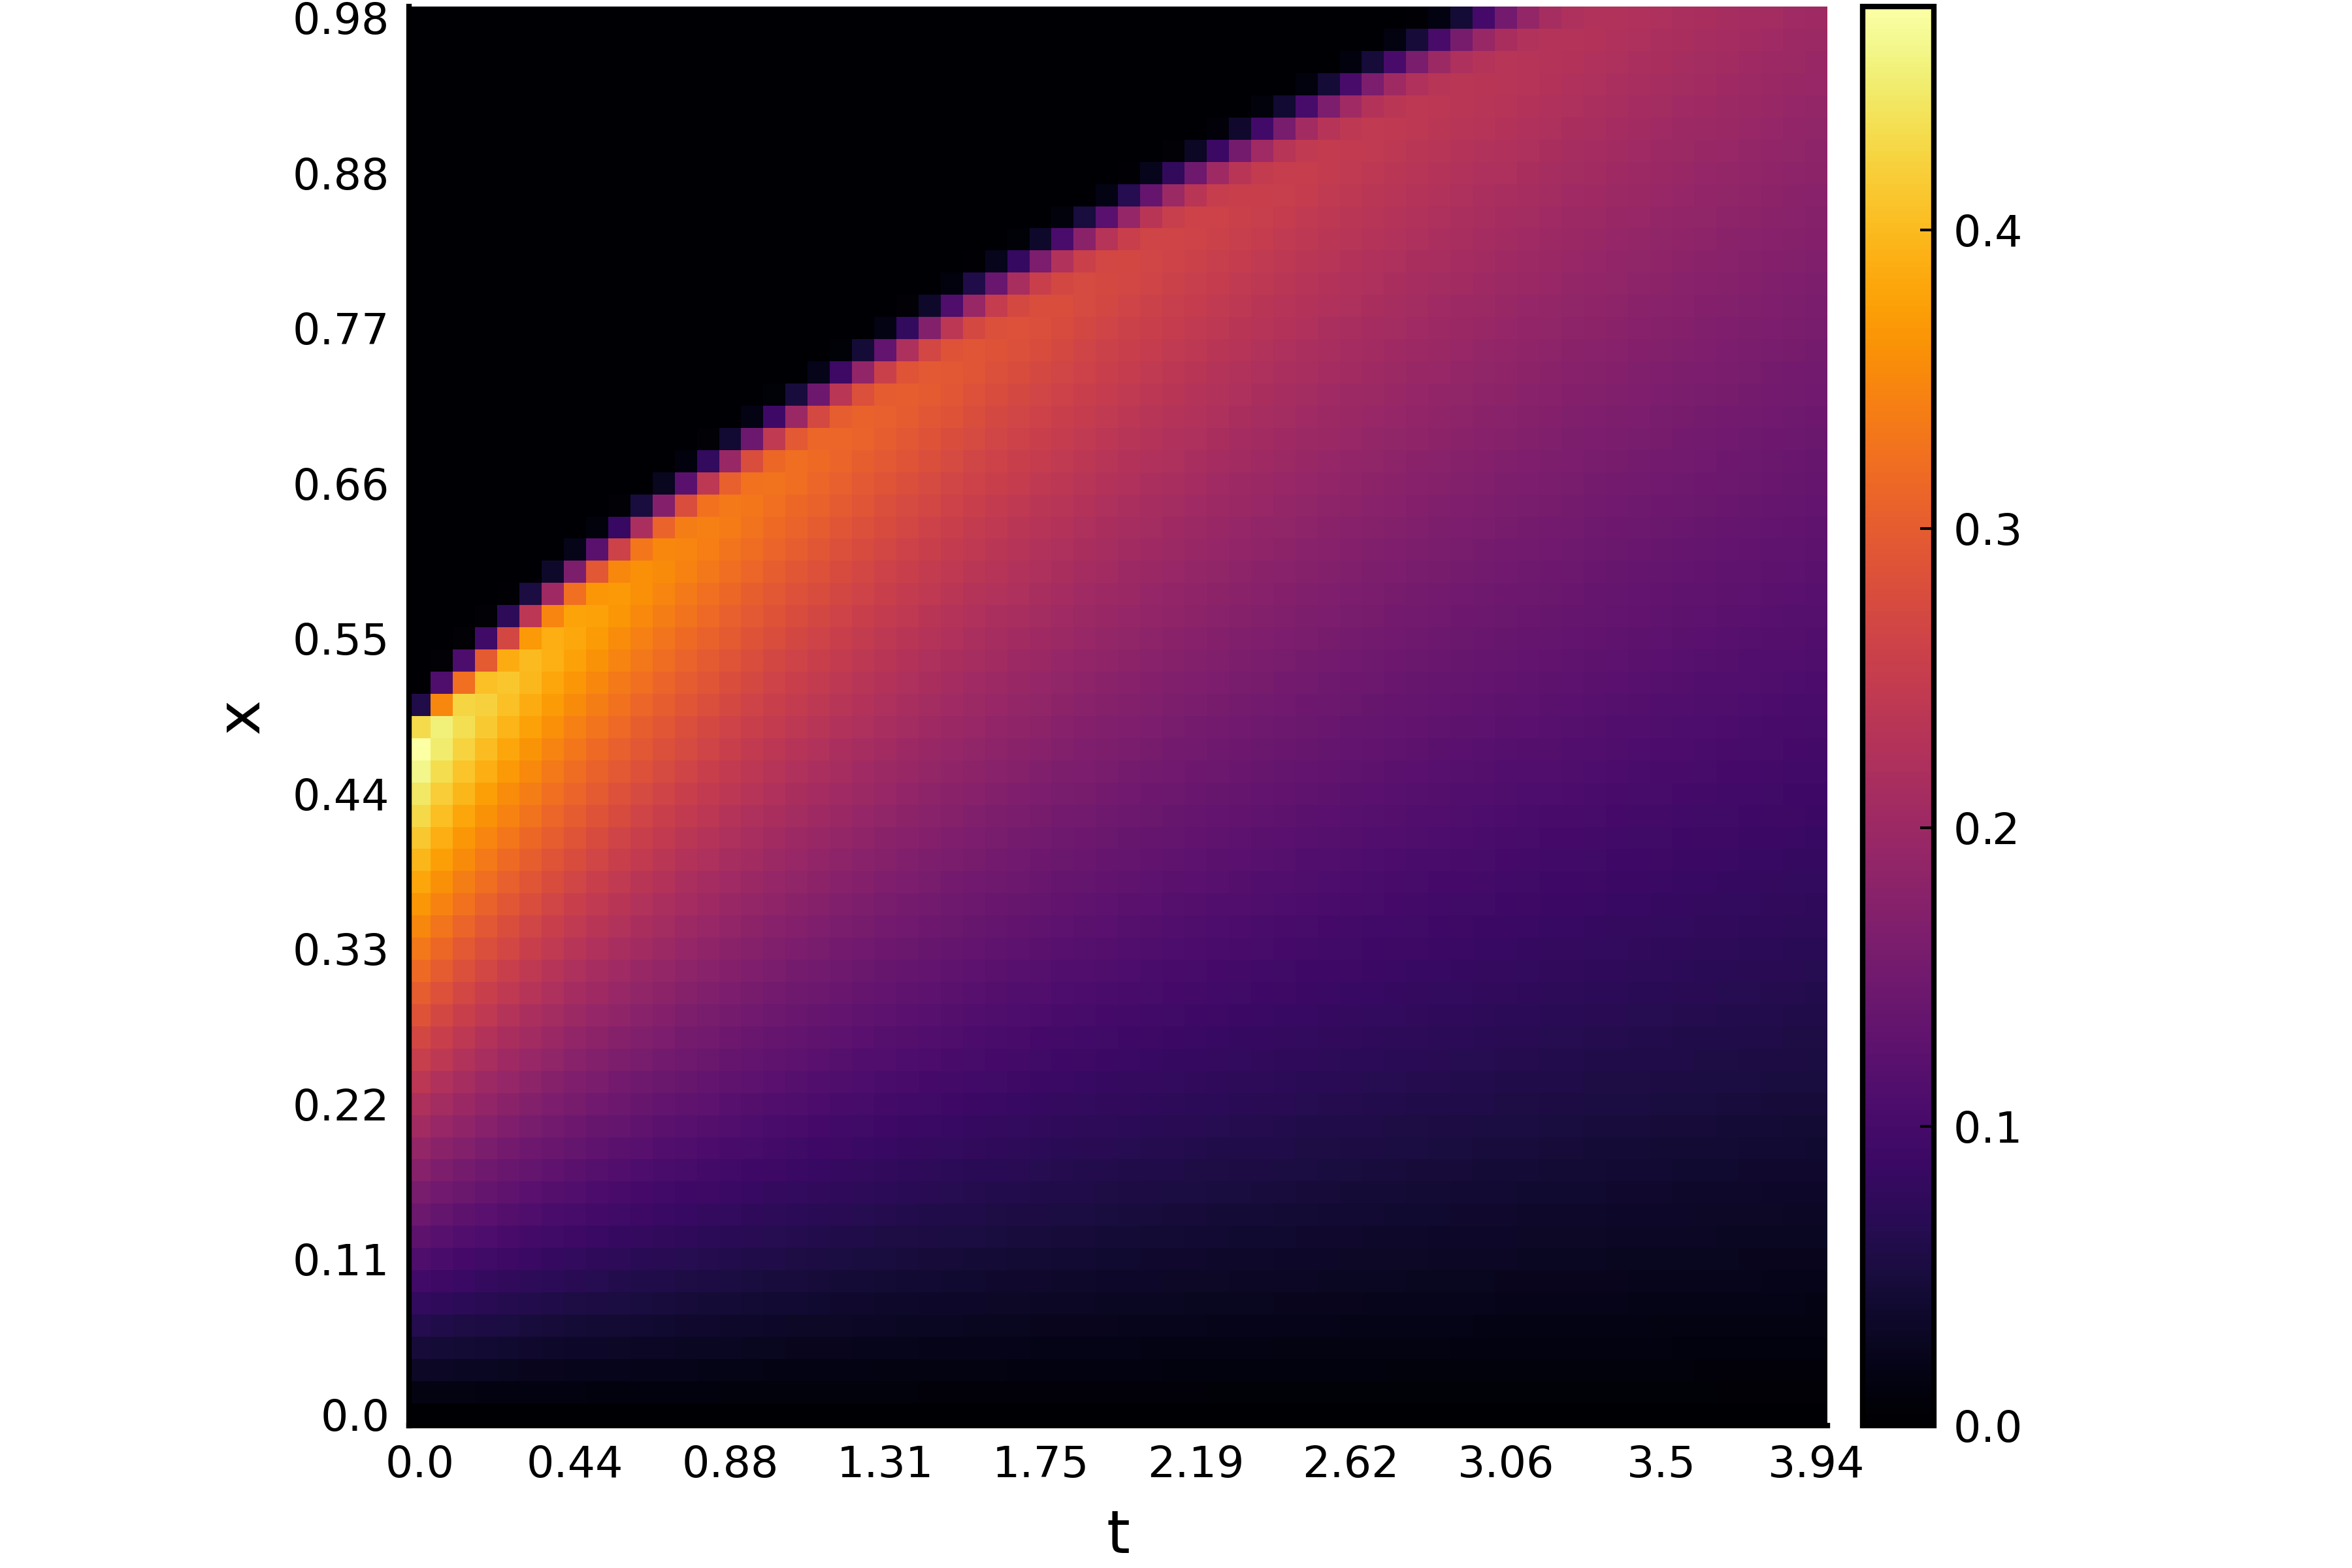

In [677]:
t1, u1 = Equations.get_burgers_godunov(t, dx, x_n, 0., u0[1, :]);
GraphicTools.show_state(u1, t, x, "", "t", "x") # need to reverse u, odesolver switch dimensions

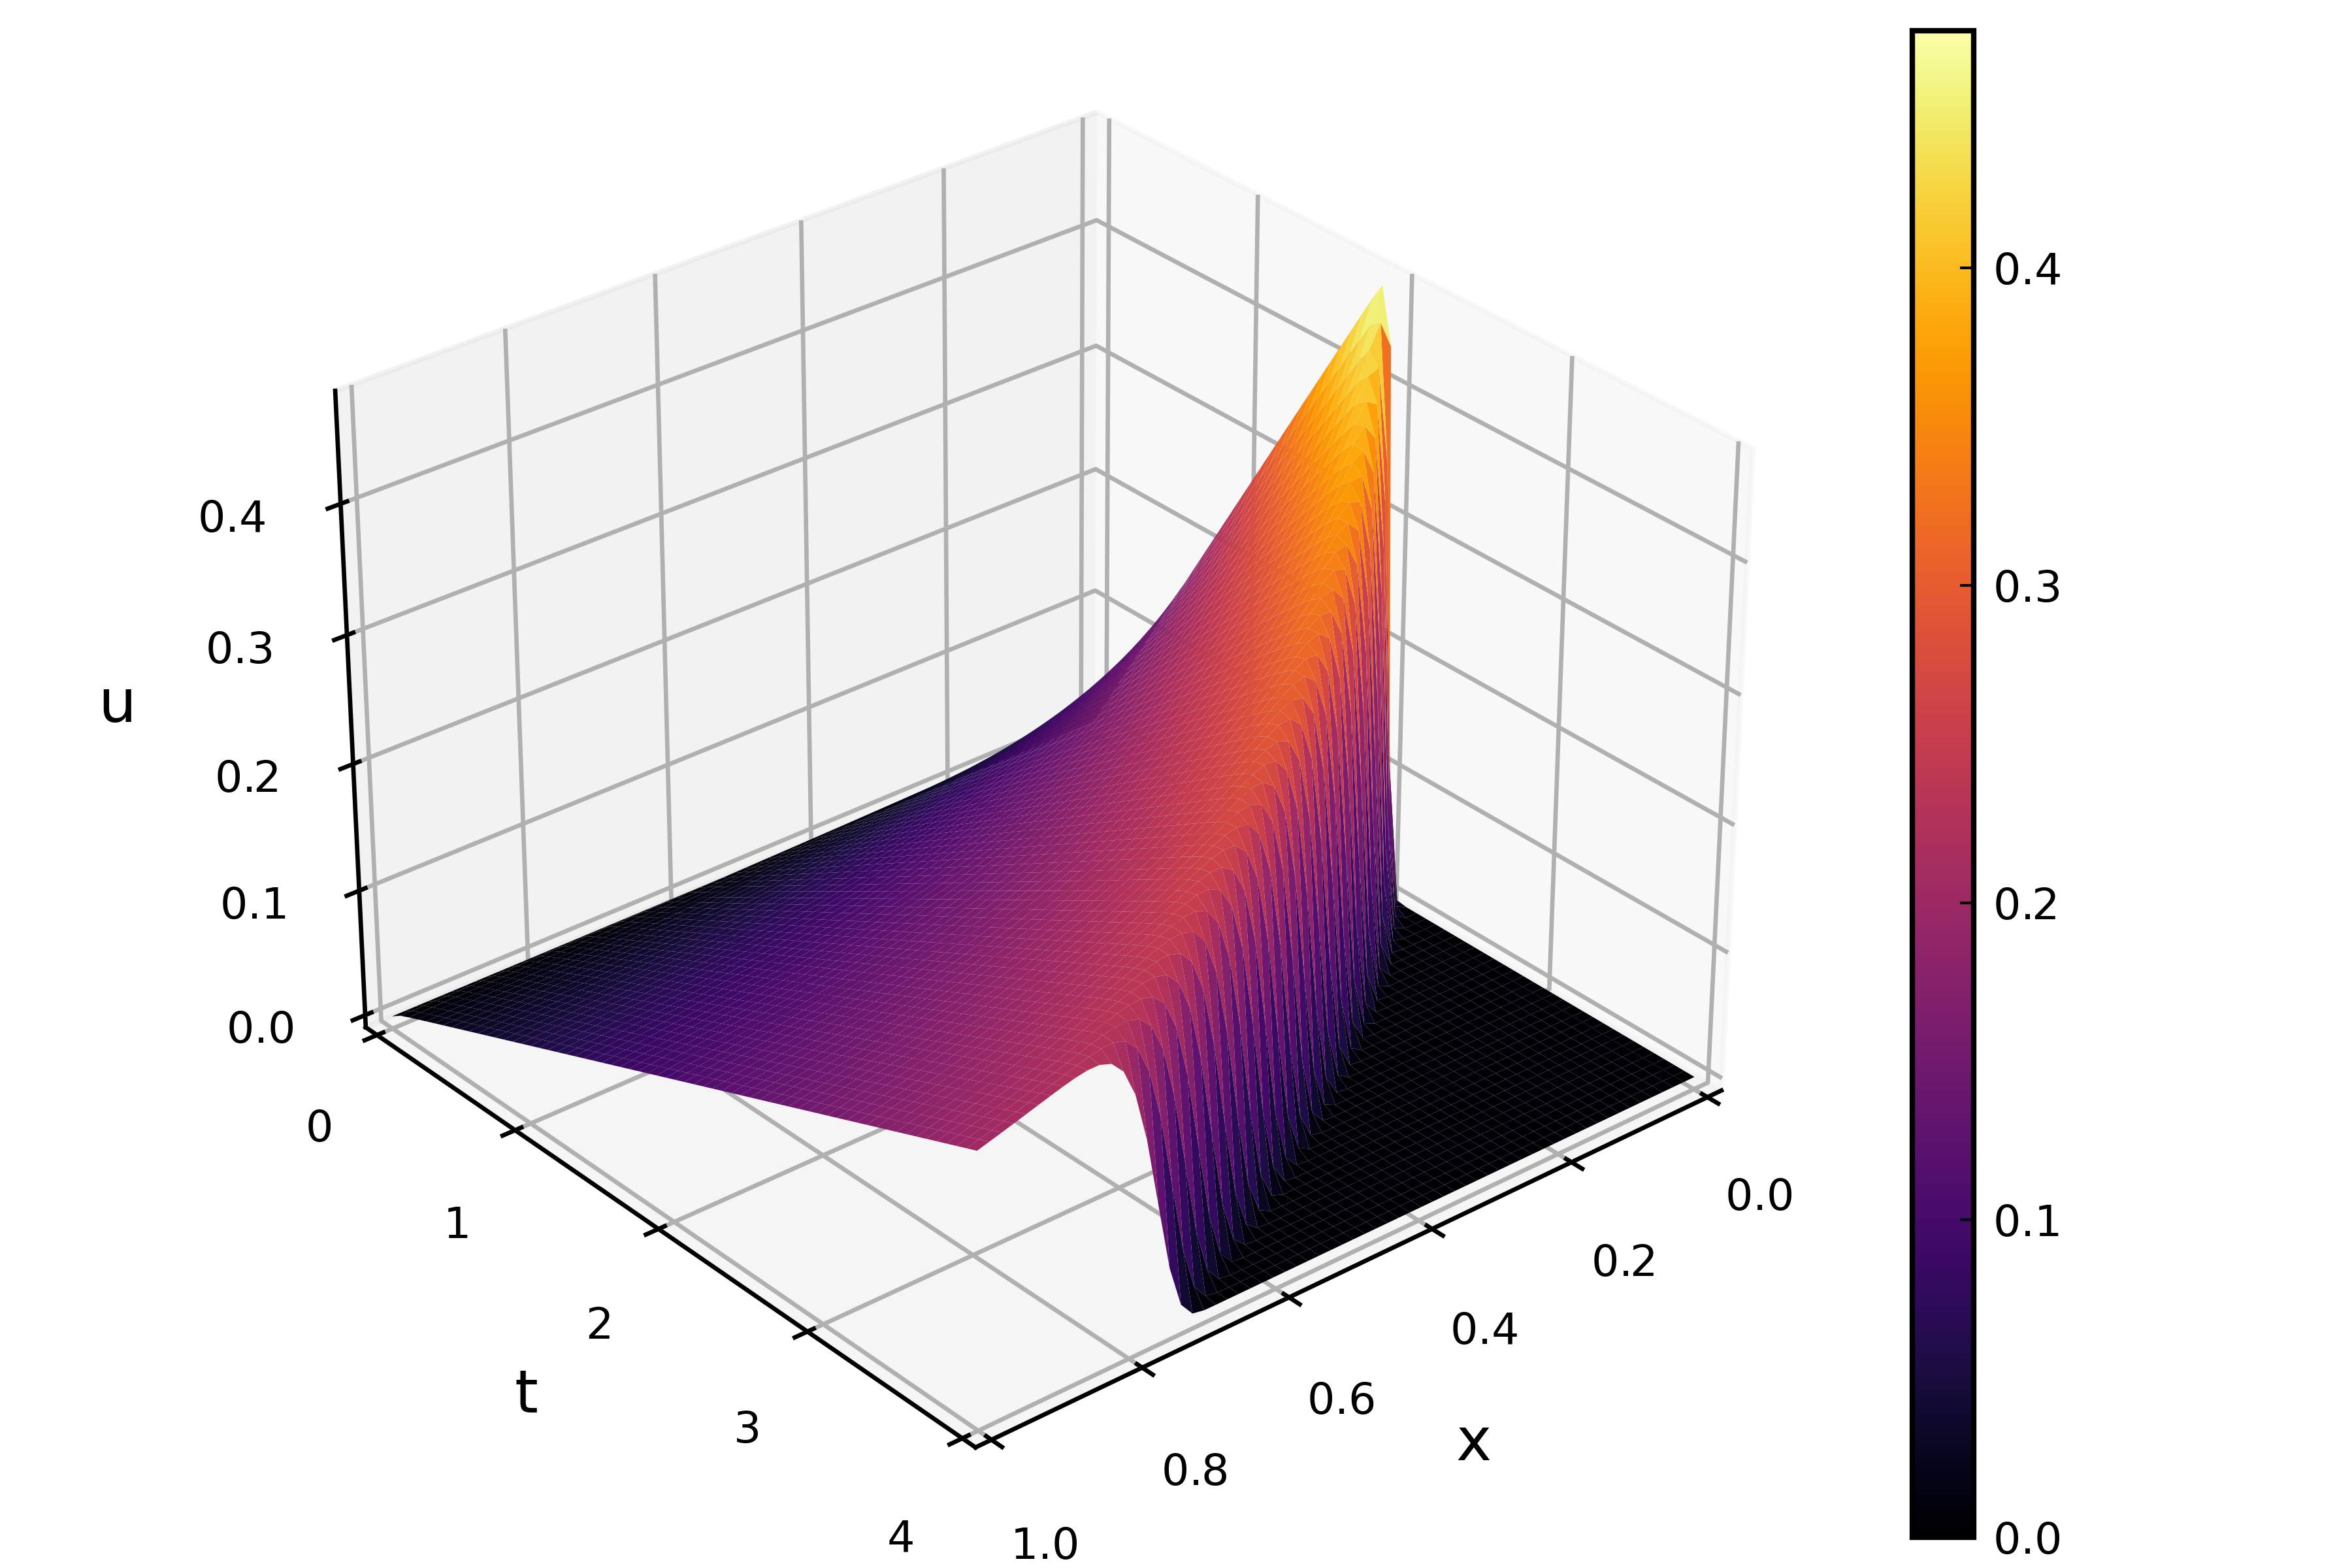

In [602]:
plot(x, t1, u1, st = :surface, xlabel = "x", ylabel = "t", zlabel = "u", camera = (140, 30))
plot!(dpi=600)

┌ Info: Saved animation to 
│   fn = /Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/snapshot_inviscid_burgers_nu0_fps15.gif
└ @ Plots /Users/vdesgrange/.julia/packages/Plots/1KWPG/src/animation.jl:114


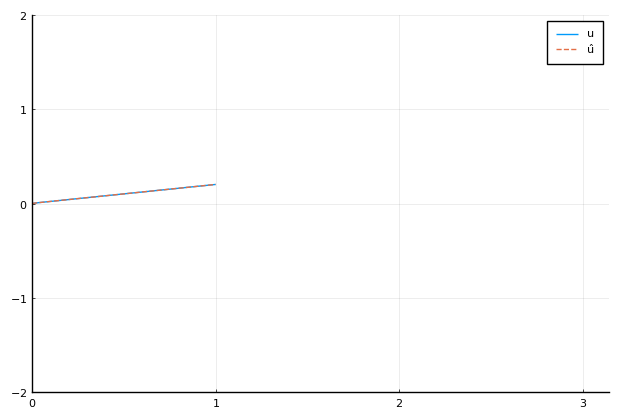

Plots.AnimatedGif("/Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/snapshot_inviscid_burgers_nu0_fps15.gif")
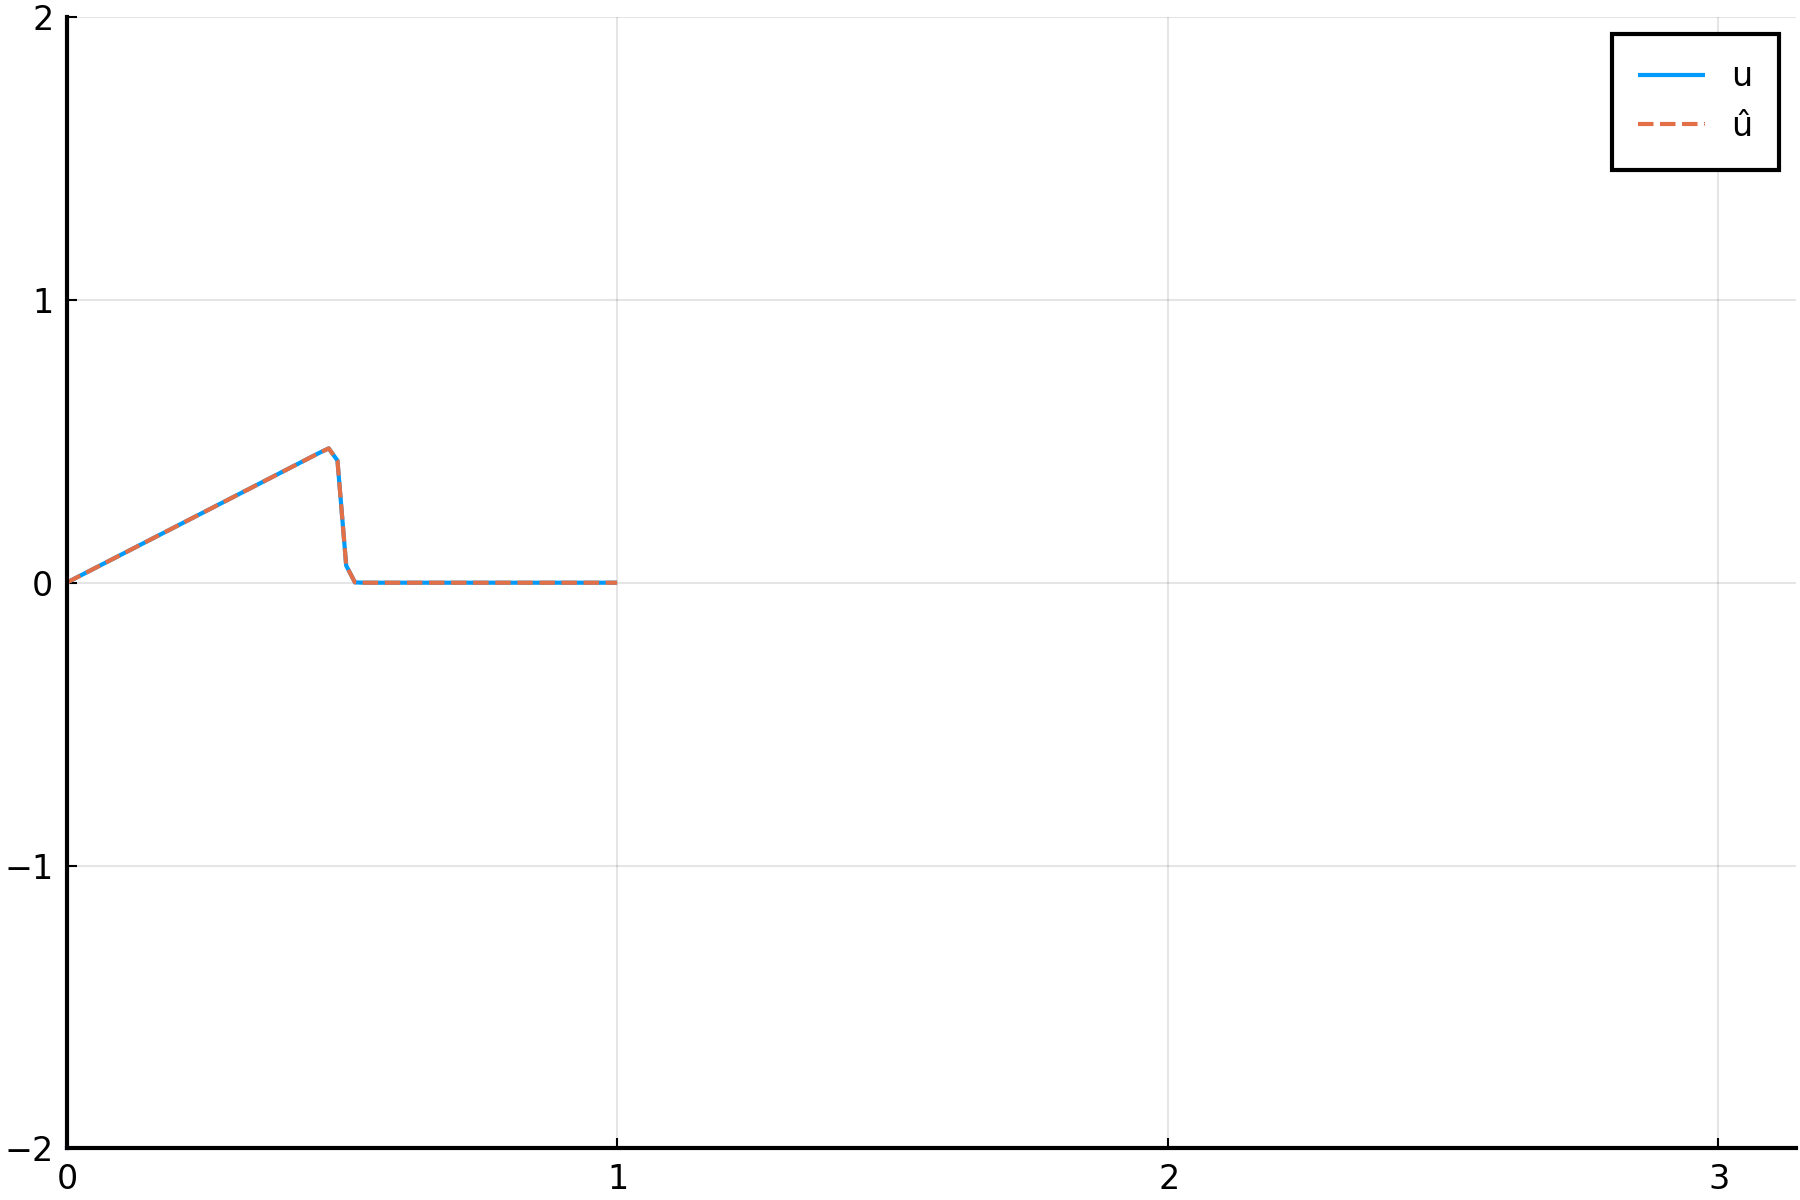

In [604]:
animate_snapshot_prediction(u1, u1, collect(LinRange(0., 1., 64)), "snapshot_inviscid_burgers_nu0_fps15.gif")

### CCDF

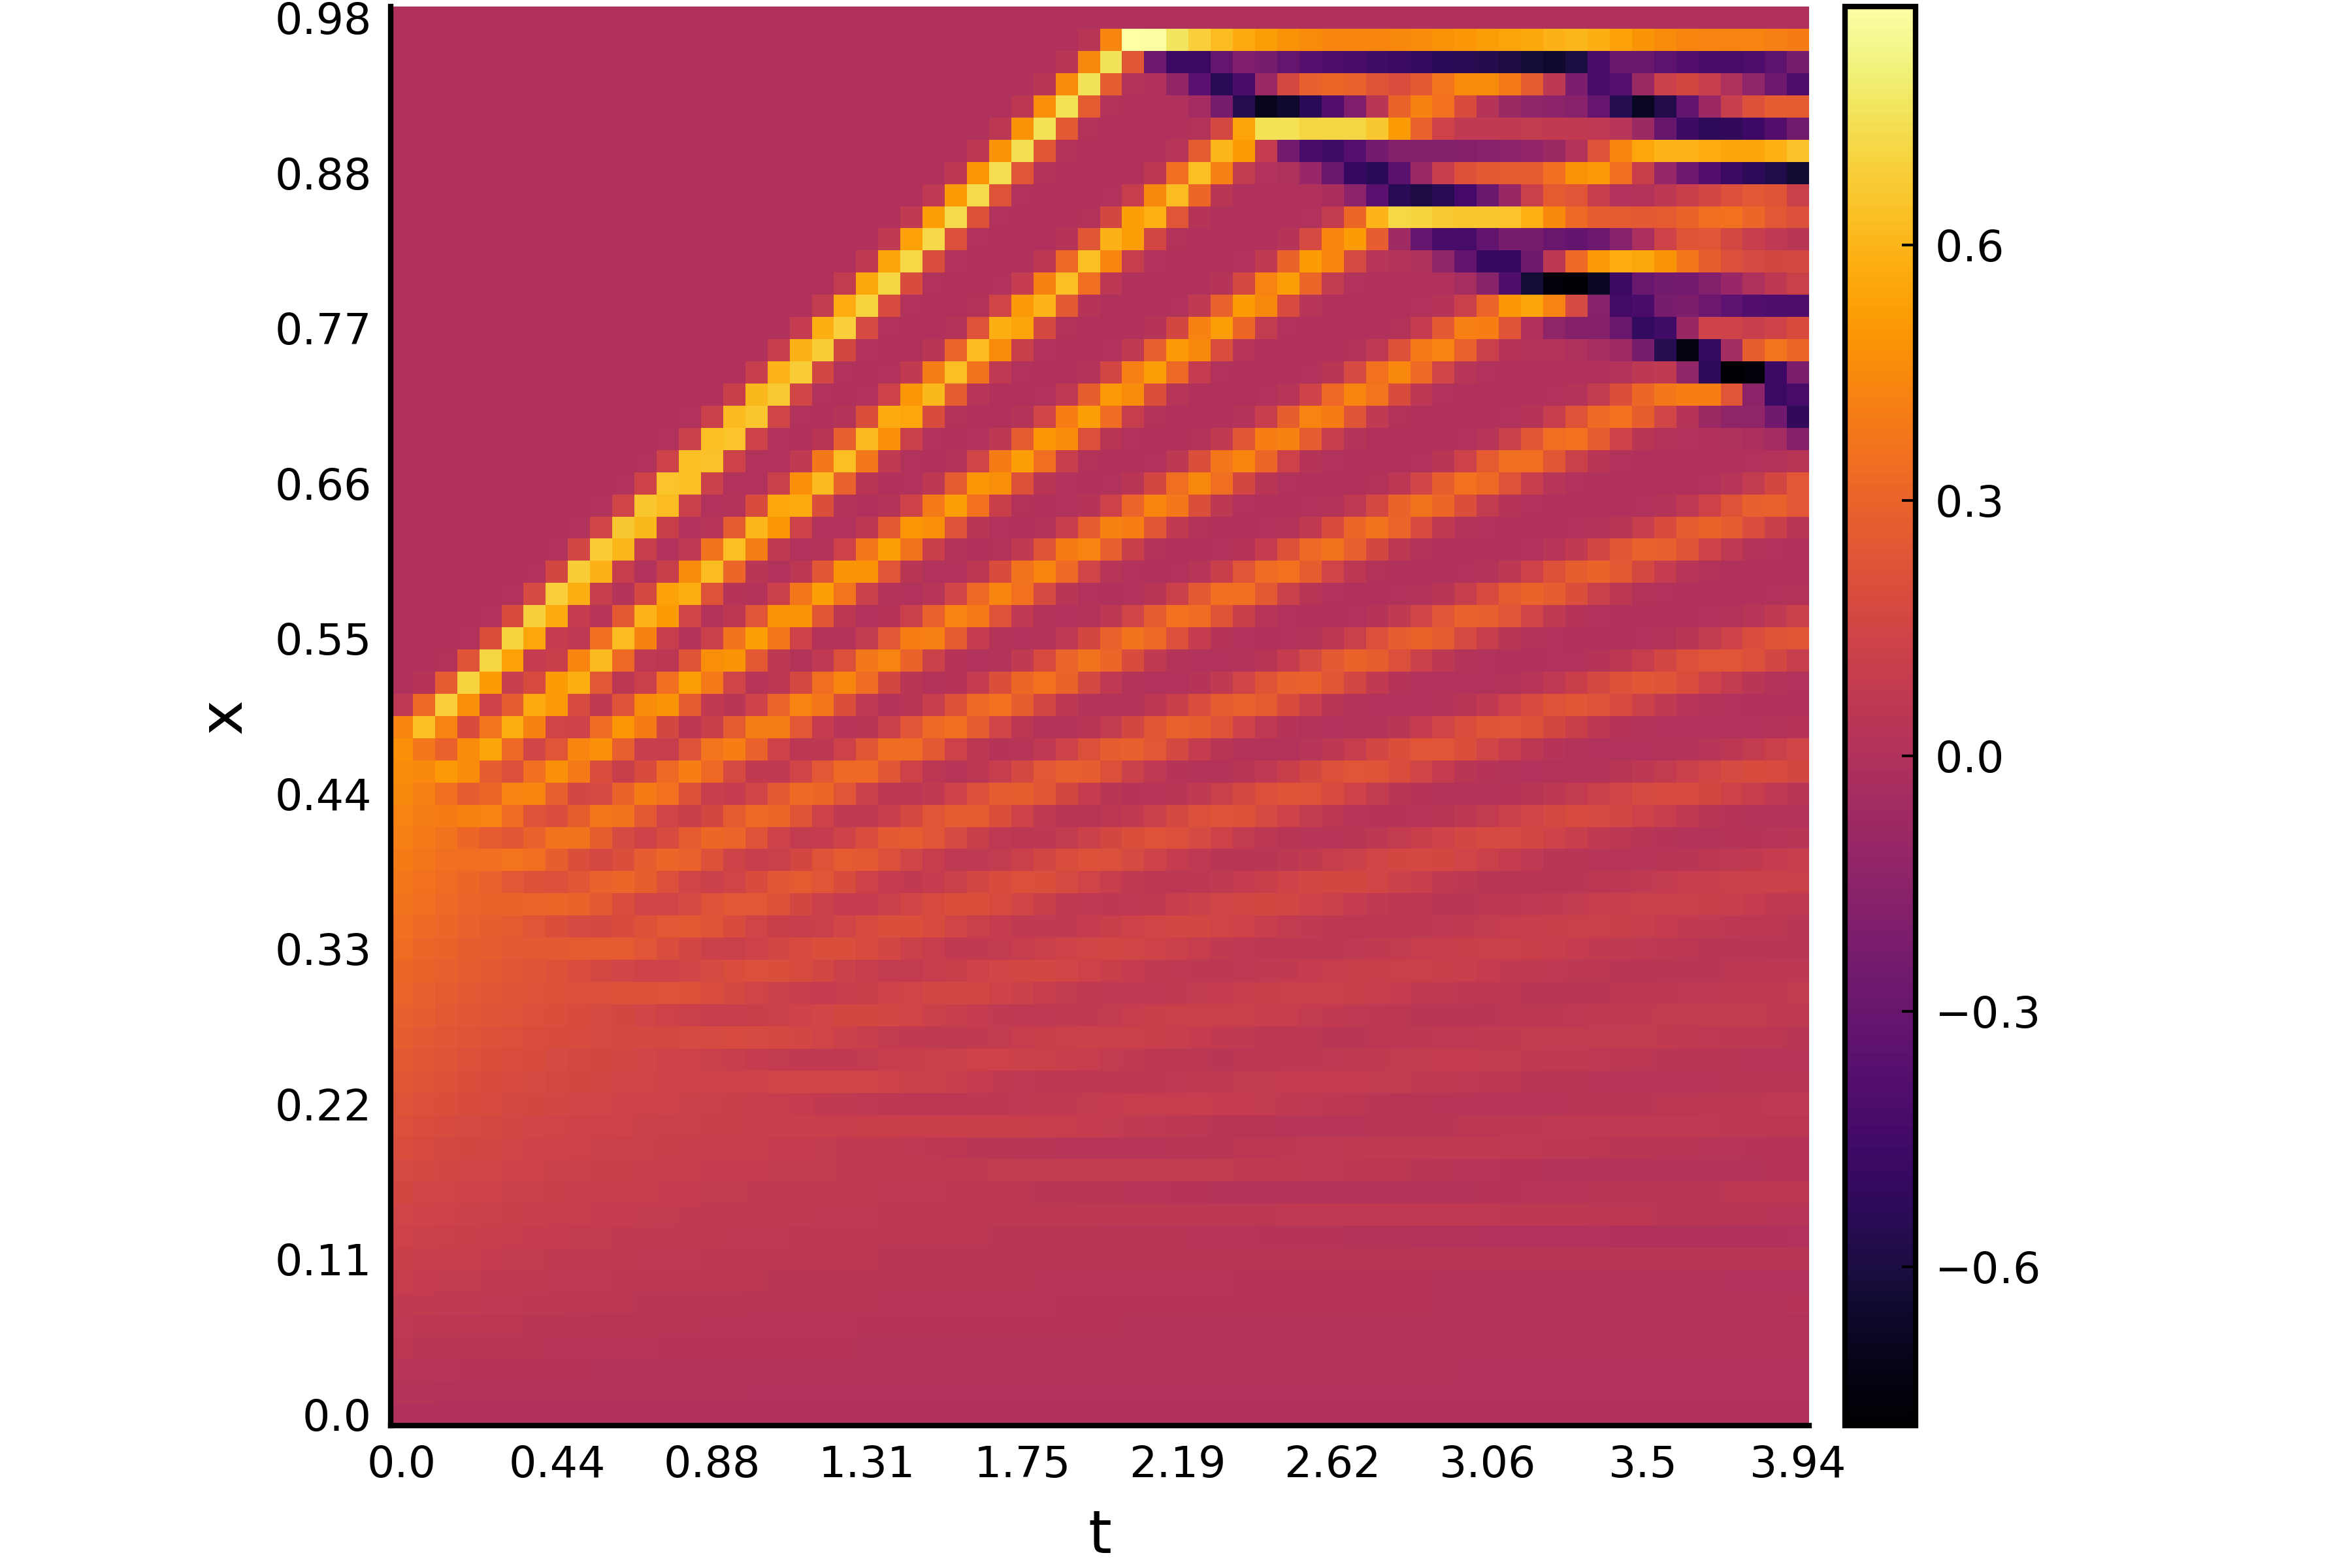

In [605]:
t2, u2 = Equations.get_burgers_ccdf(t, dx, x_n, nu, u0[1, :]);
GraphicTools.show_state(u2, t, x, "", "t", "x") # need to reverse u, odesolver switch dimensions

### Pseudo-spectral method

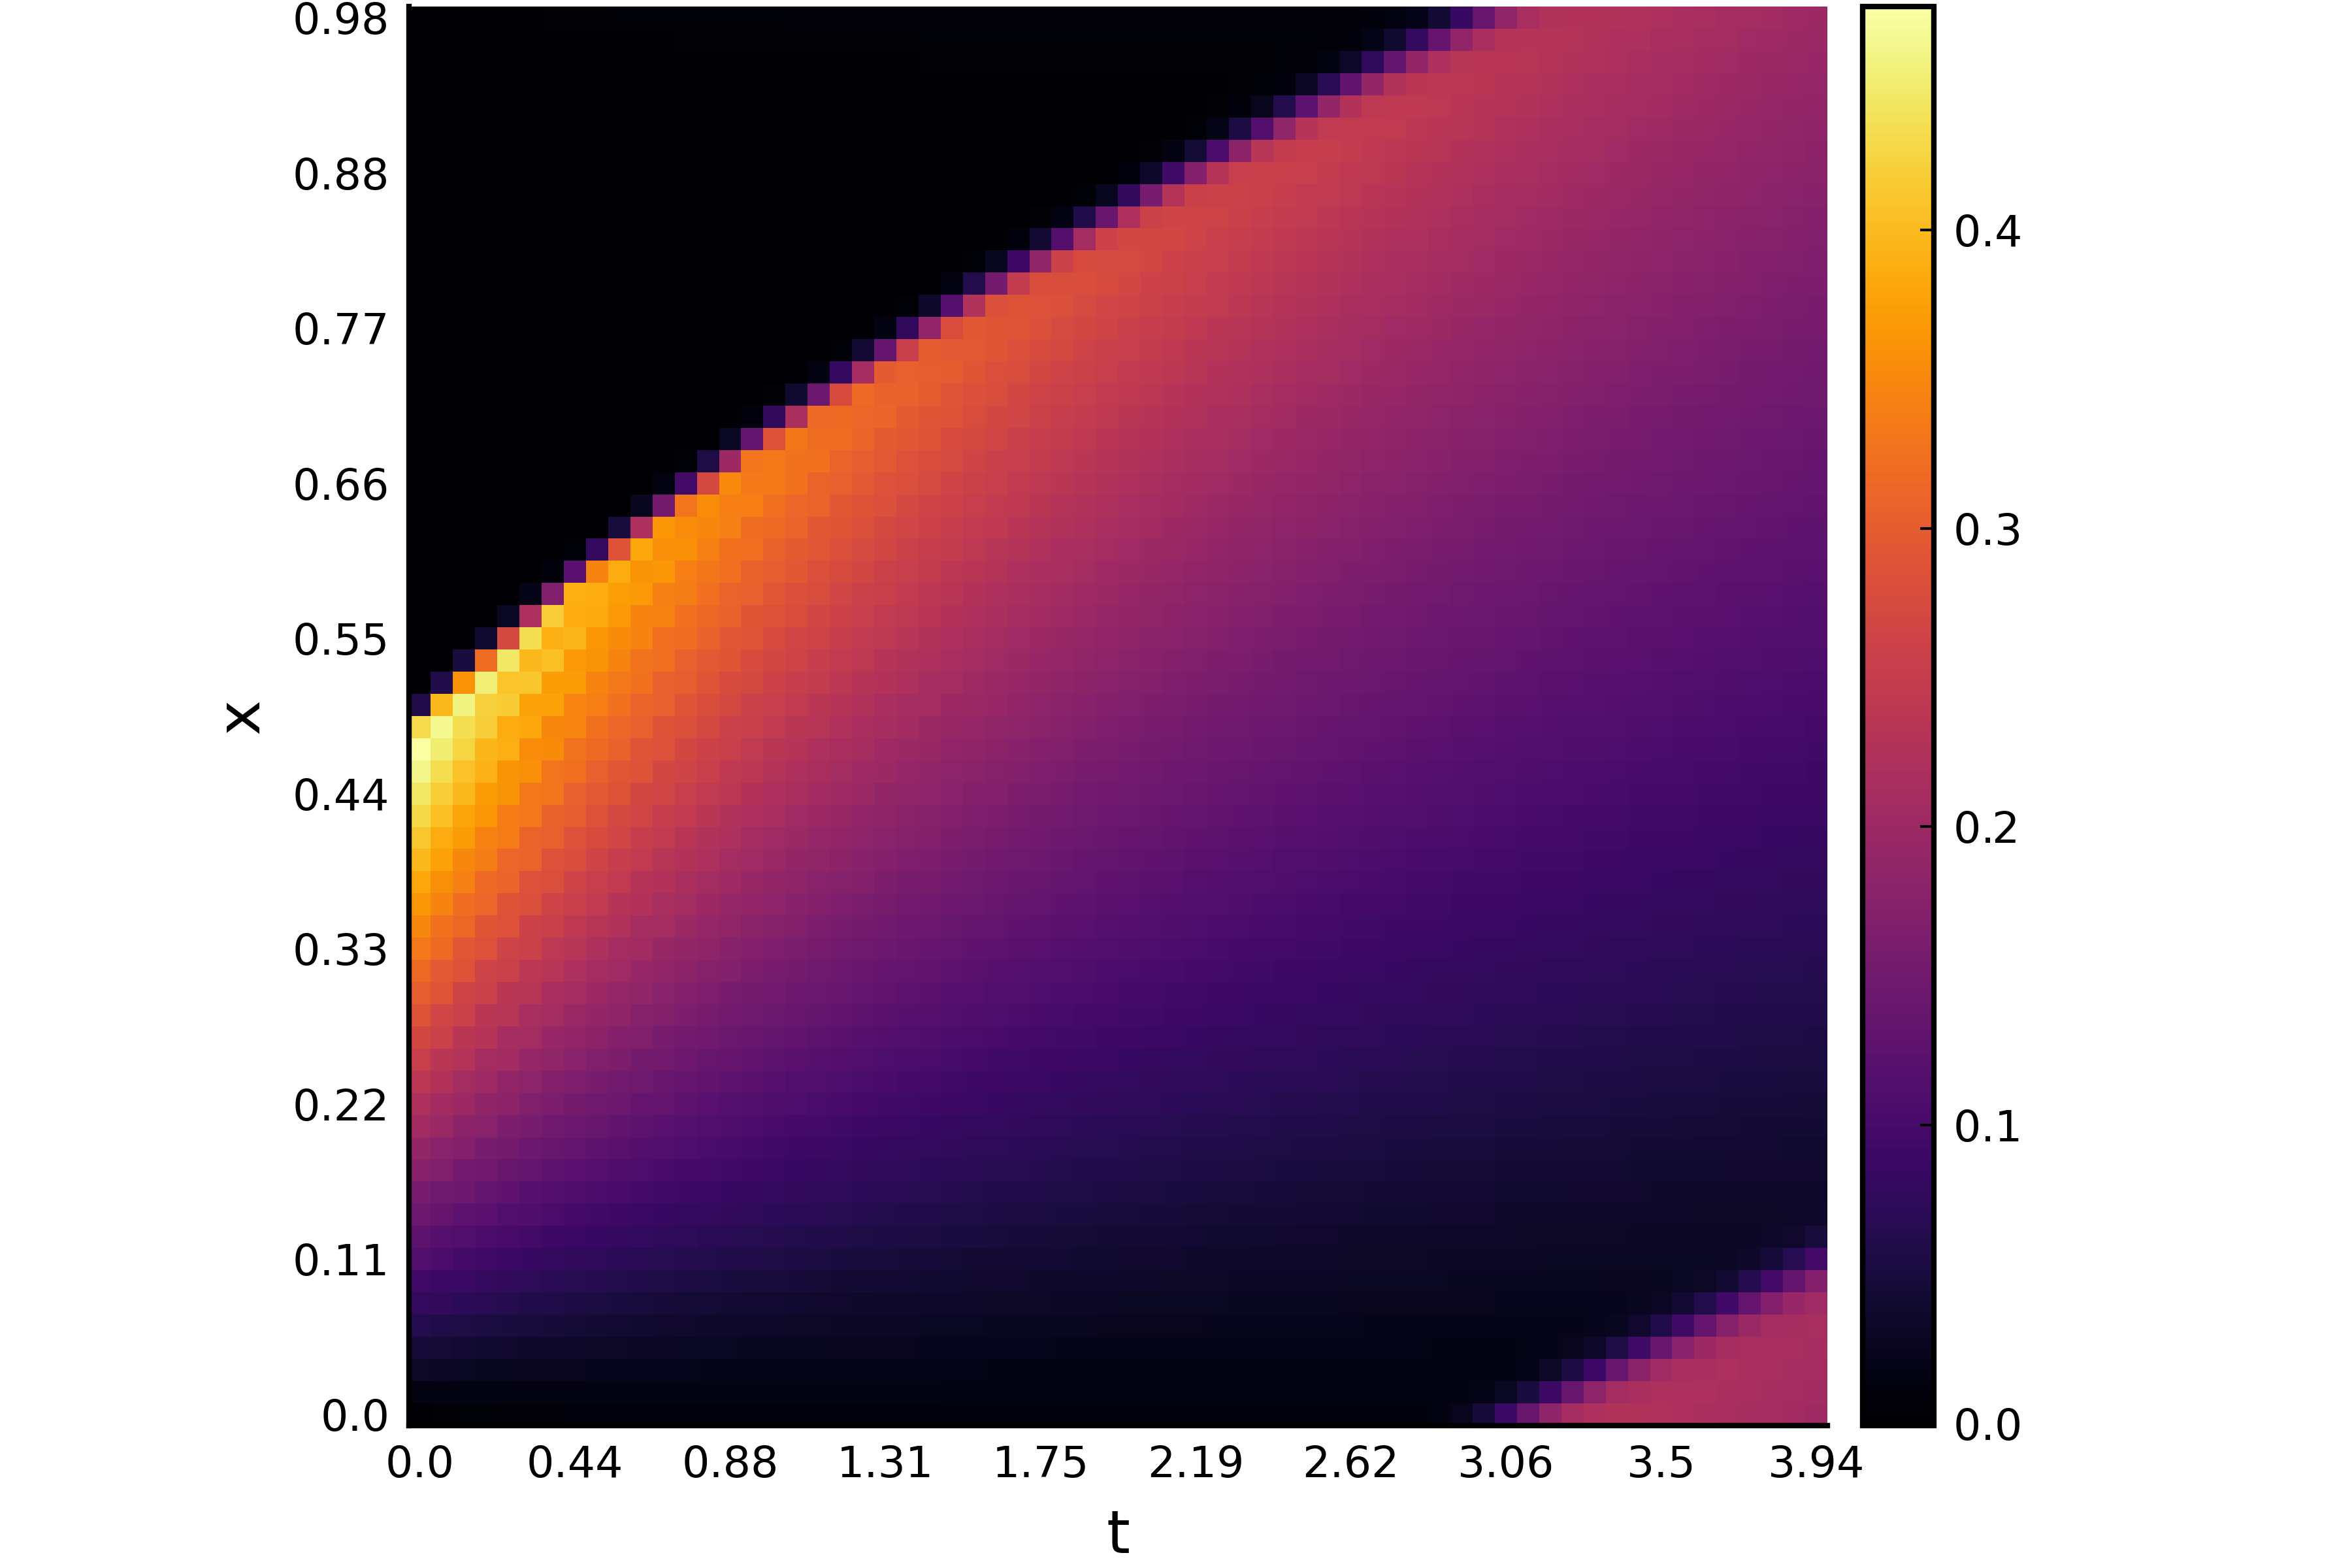

In [679]:
t3, u3 = Equations.get_burgers_fft(t, dx, x_n, 0.001, u0[1, :]);
GraphicTools.show_state(u3, t3, x, "", "t", "x") # need to reverse u, odesolver switch dimensions

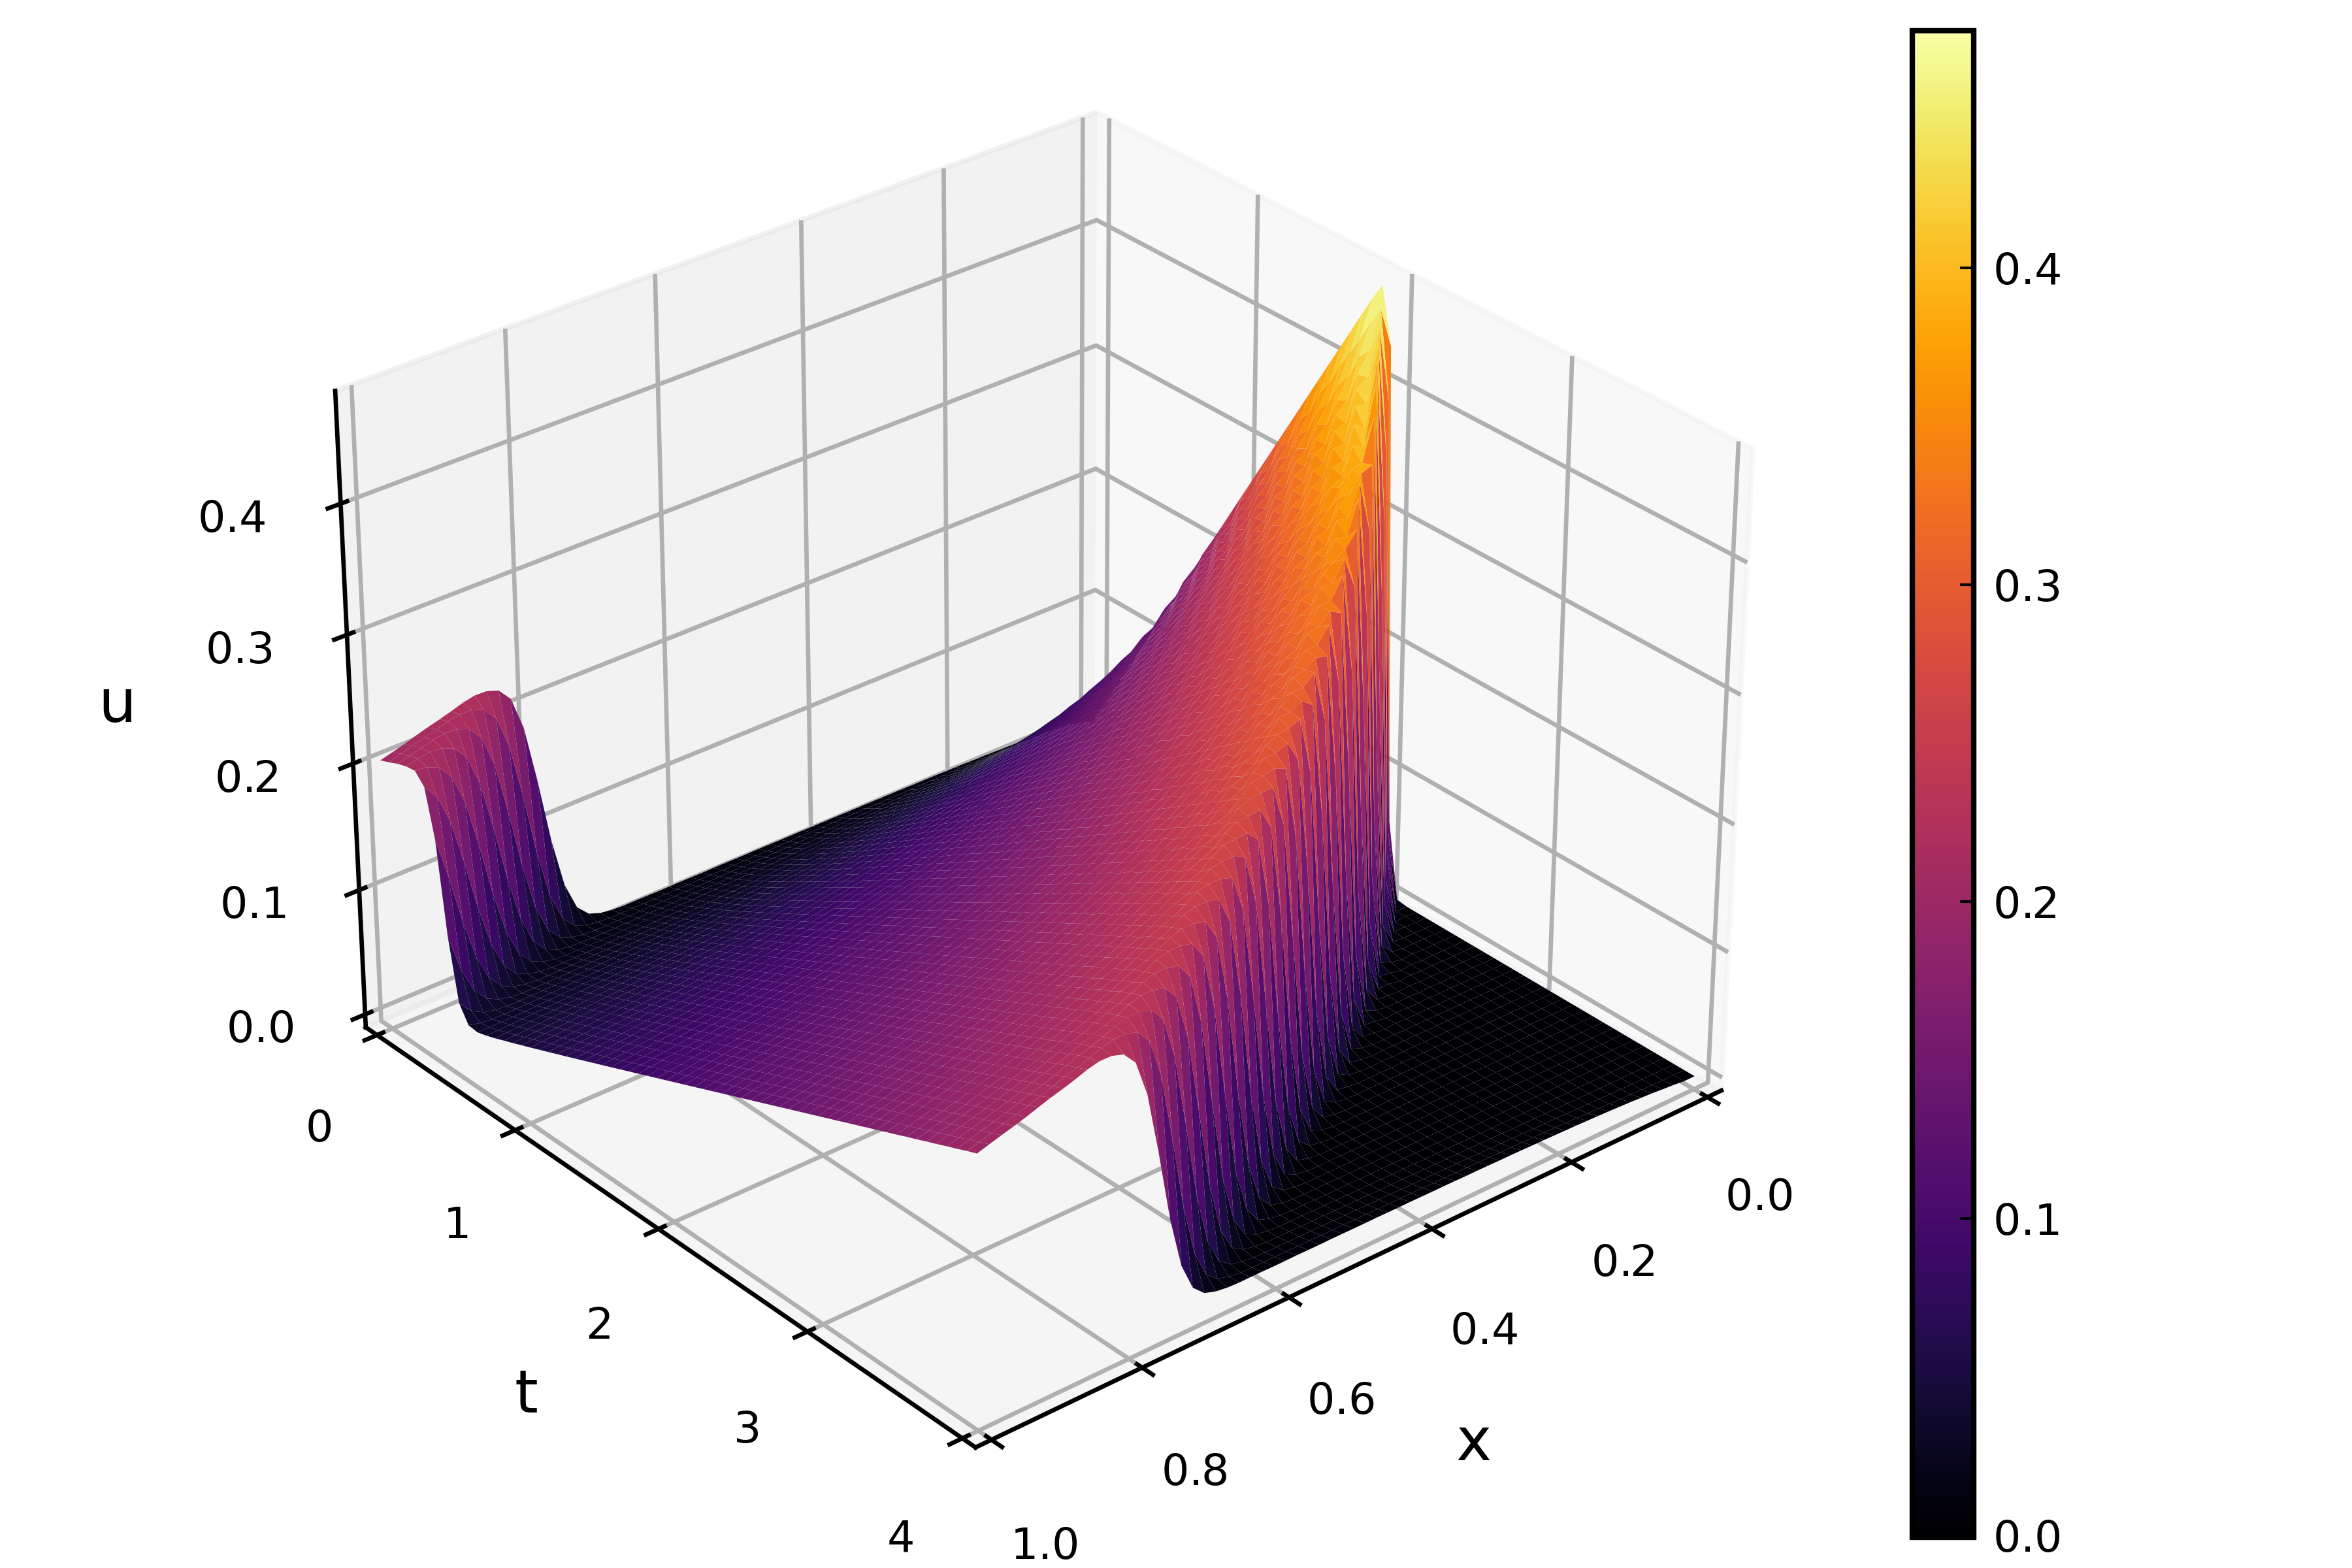

In [607]:
plot(x, t, u3, st = :surface, xlabel = "x", ylabel = "t", zlabel = "u", camera = (140, 30))
plot!(dpi=600)

### POD-GC

In [608]:
bas, ū = POD.generate_pod_basis(u1, true);
ϕ = bas.modes;
coeff = bas.coefficients;
tmp = ϕ[:, 1:3] * coeff[1:3, :] .+ ū;

In [609]:
POD.get_energy(bas.eigenvalues, 3)  # 3 modes, u1=0.85, u3=0.97

0.8654913133359327

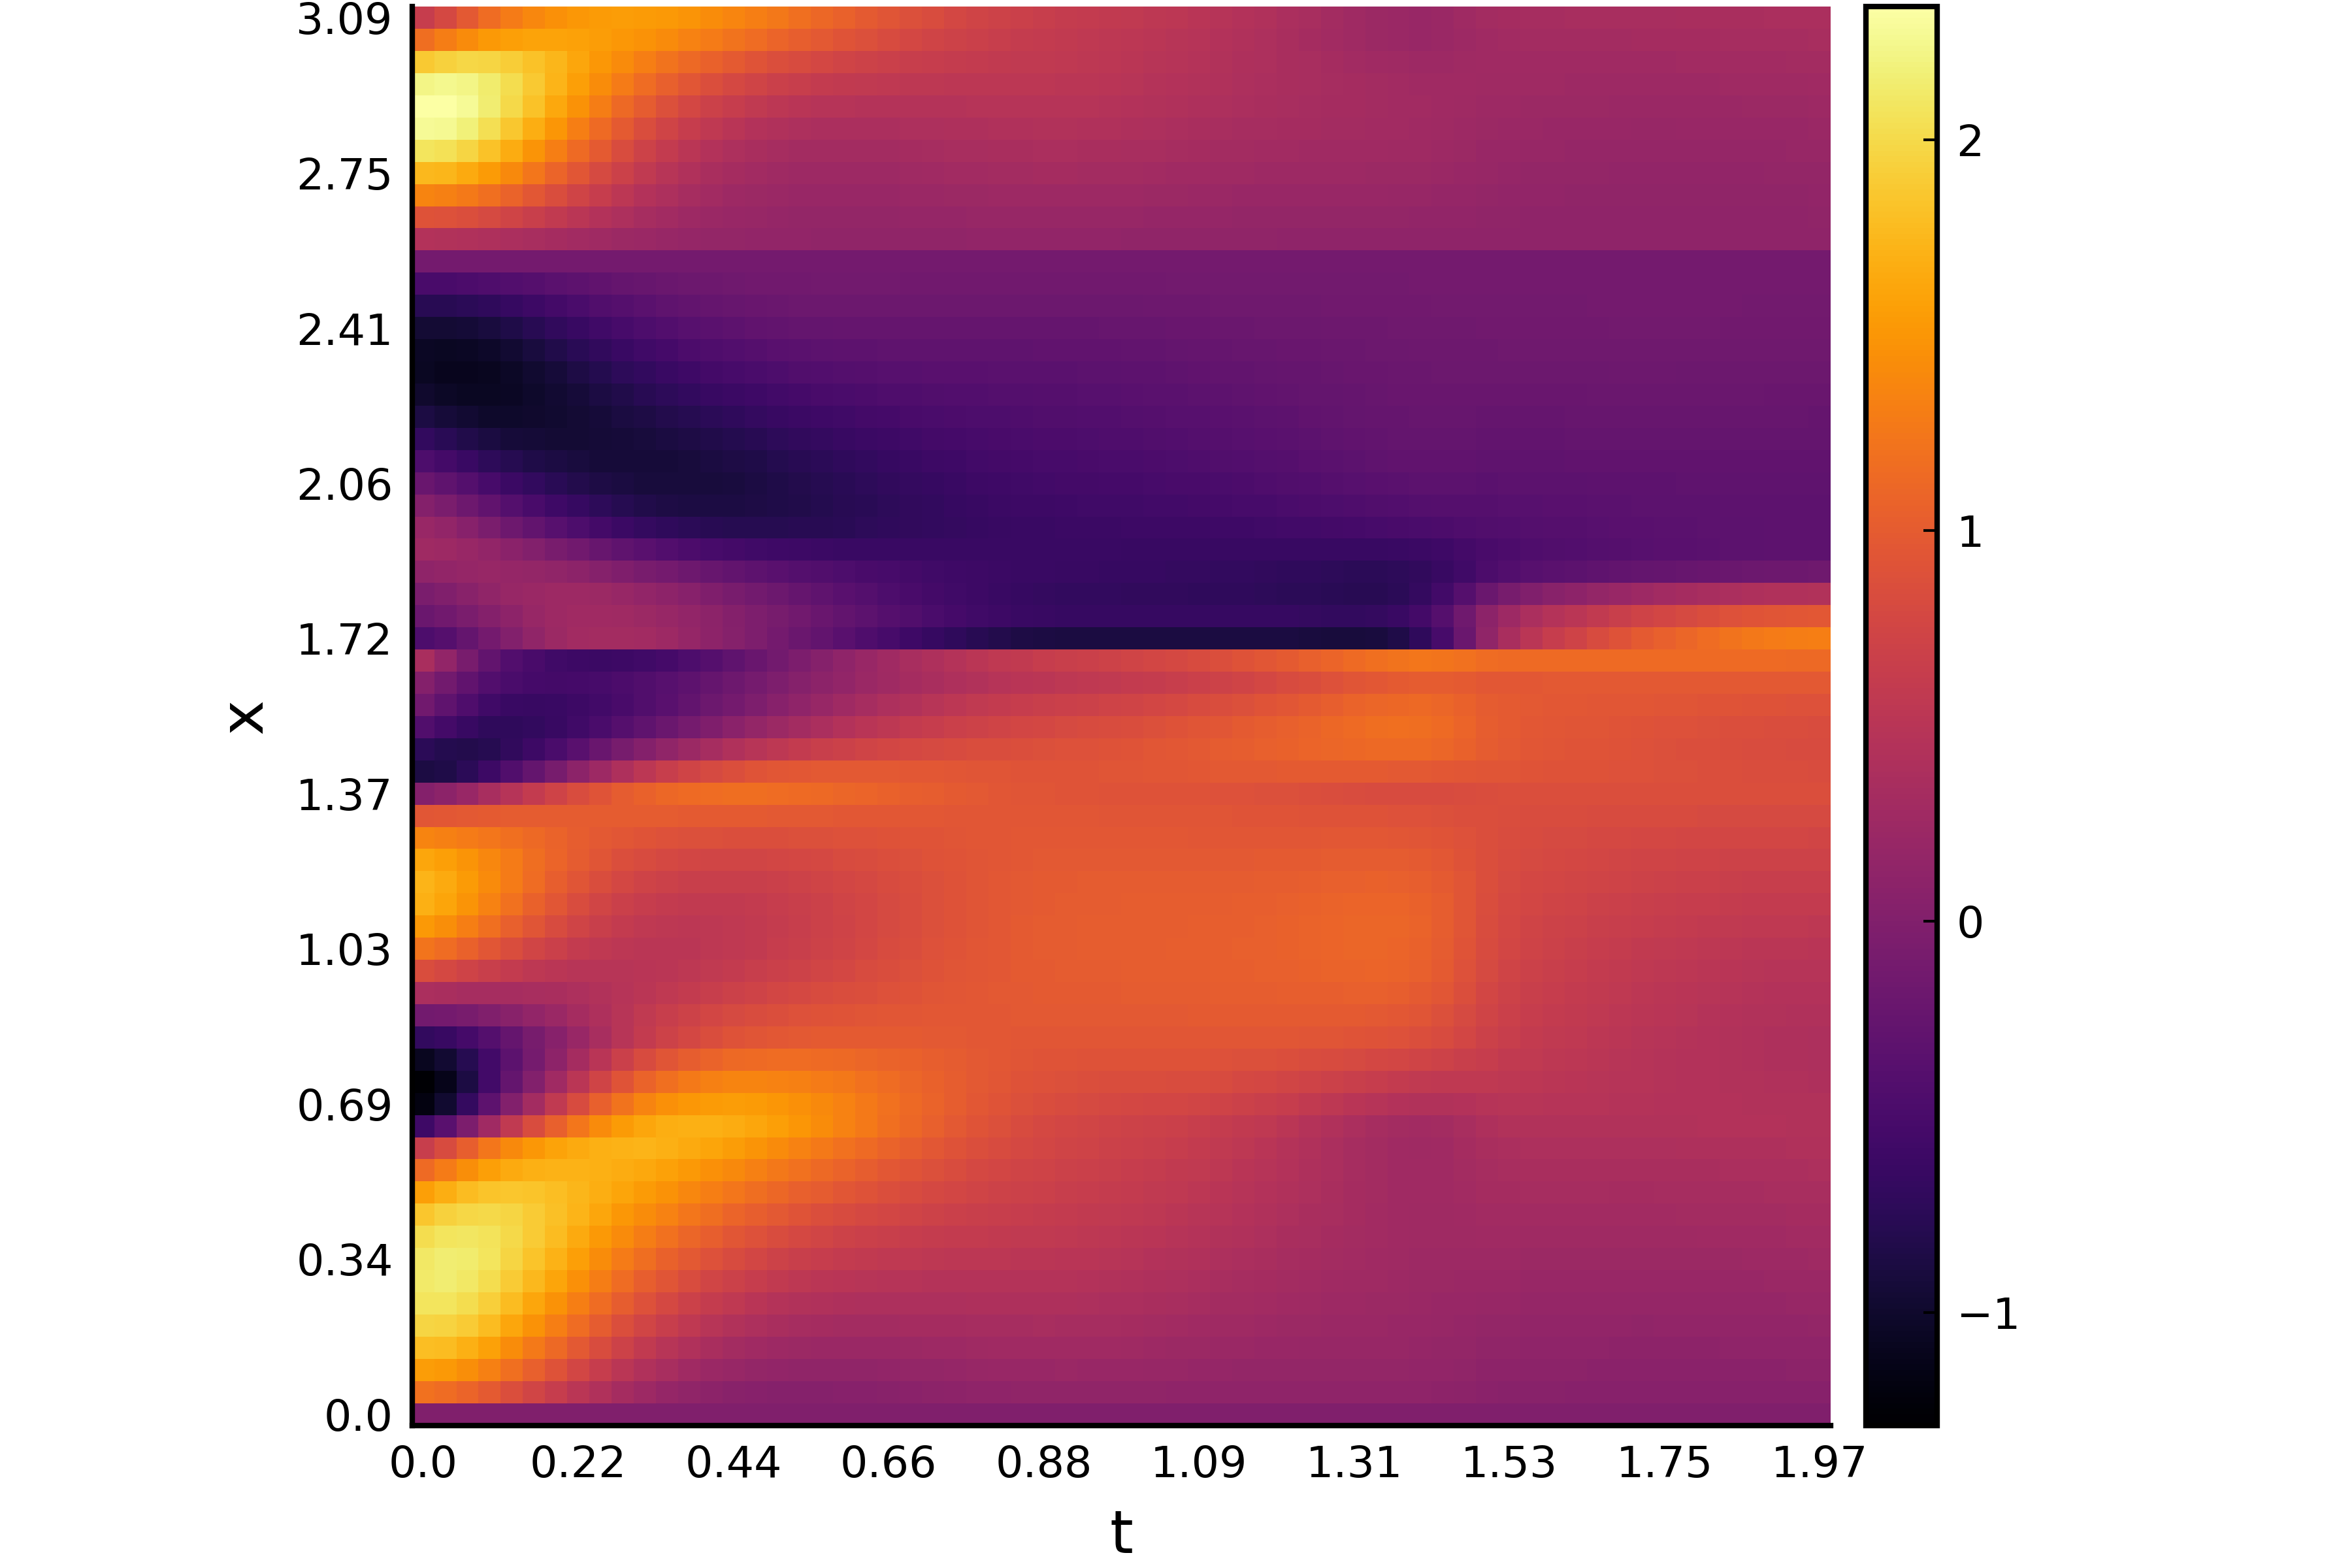

In [317]:
GraphicTools.show_state(tmp, t, x, "", "t", "x")

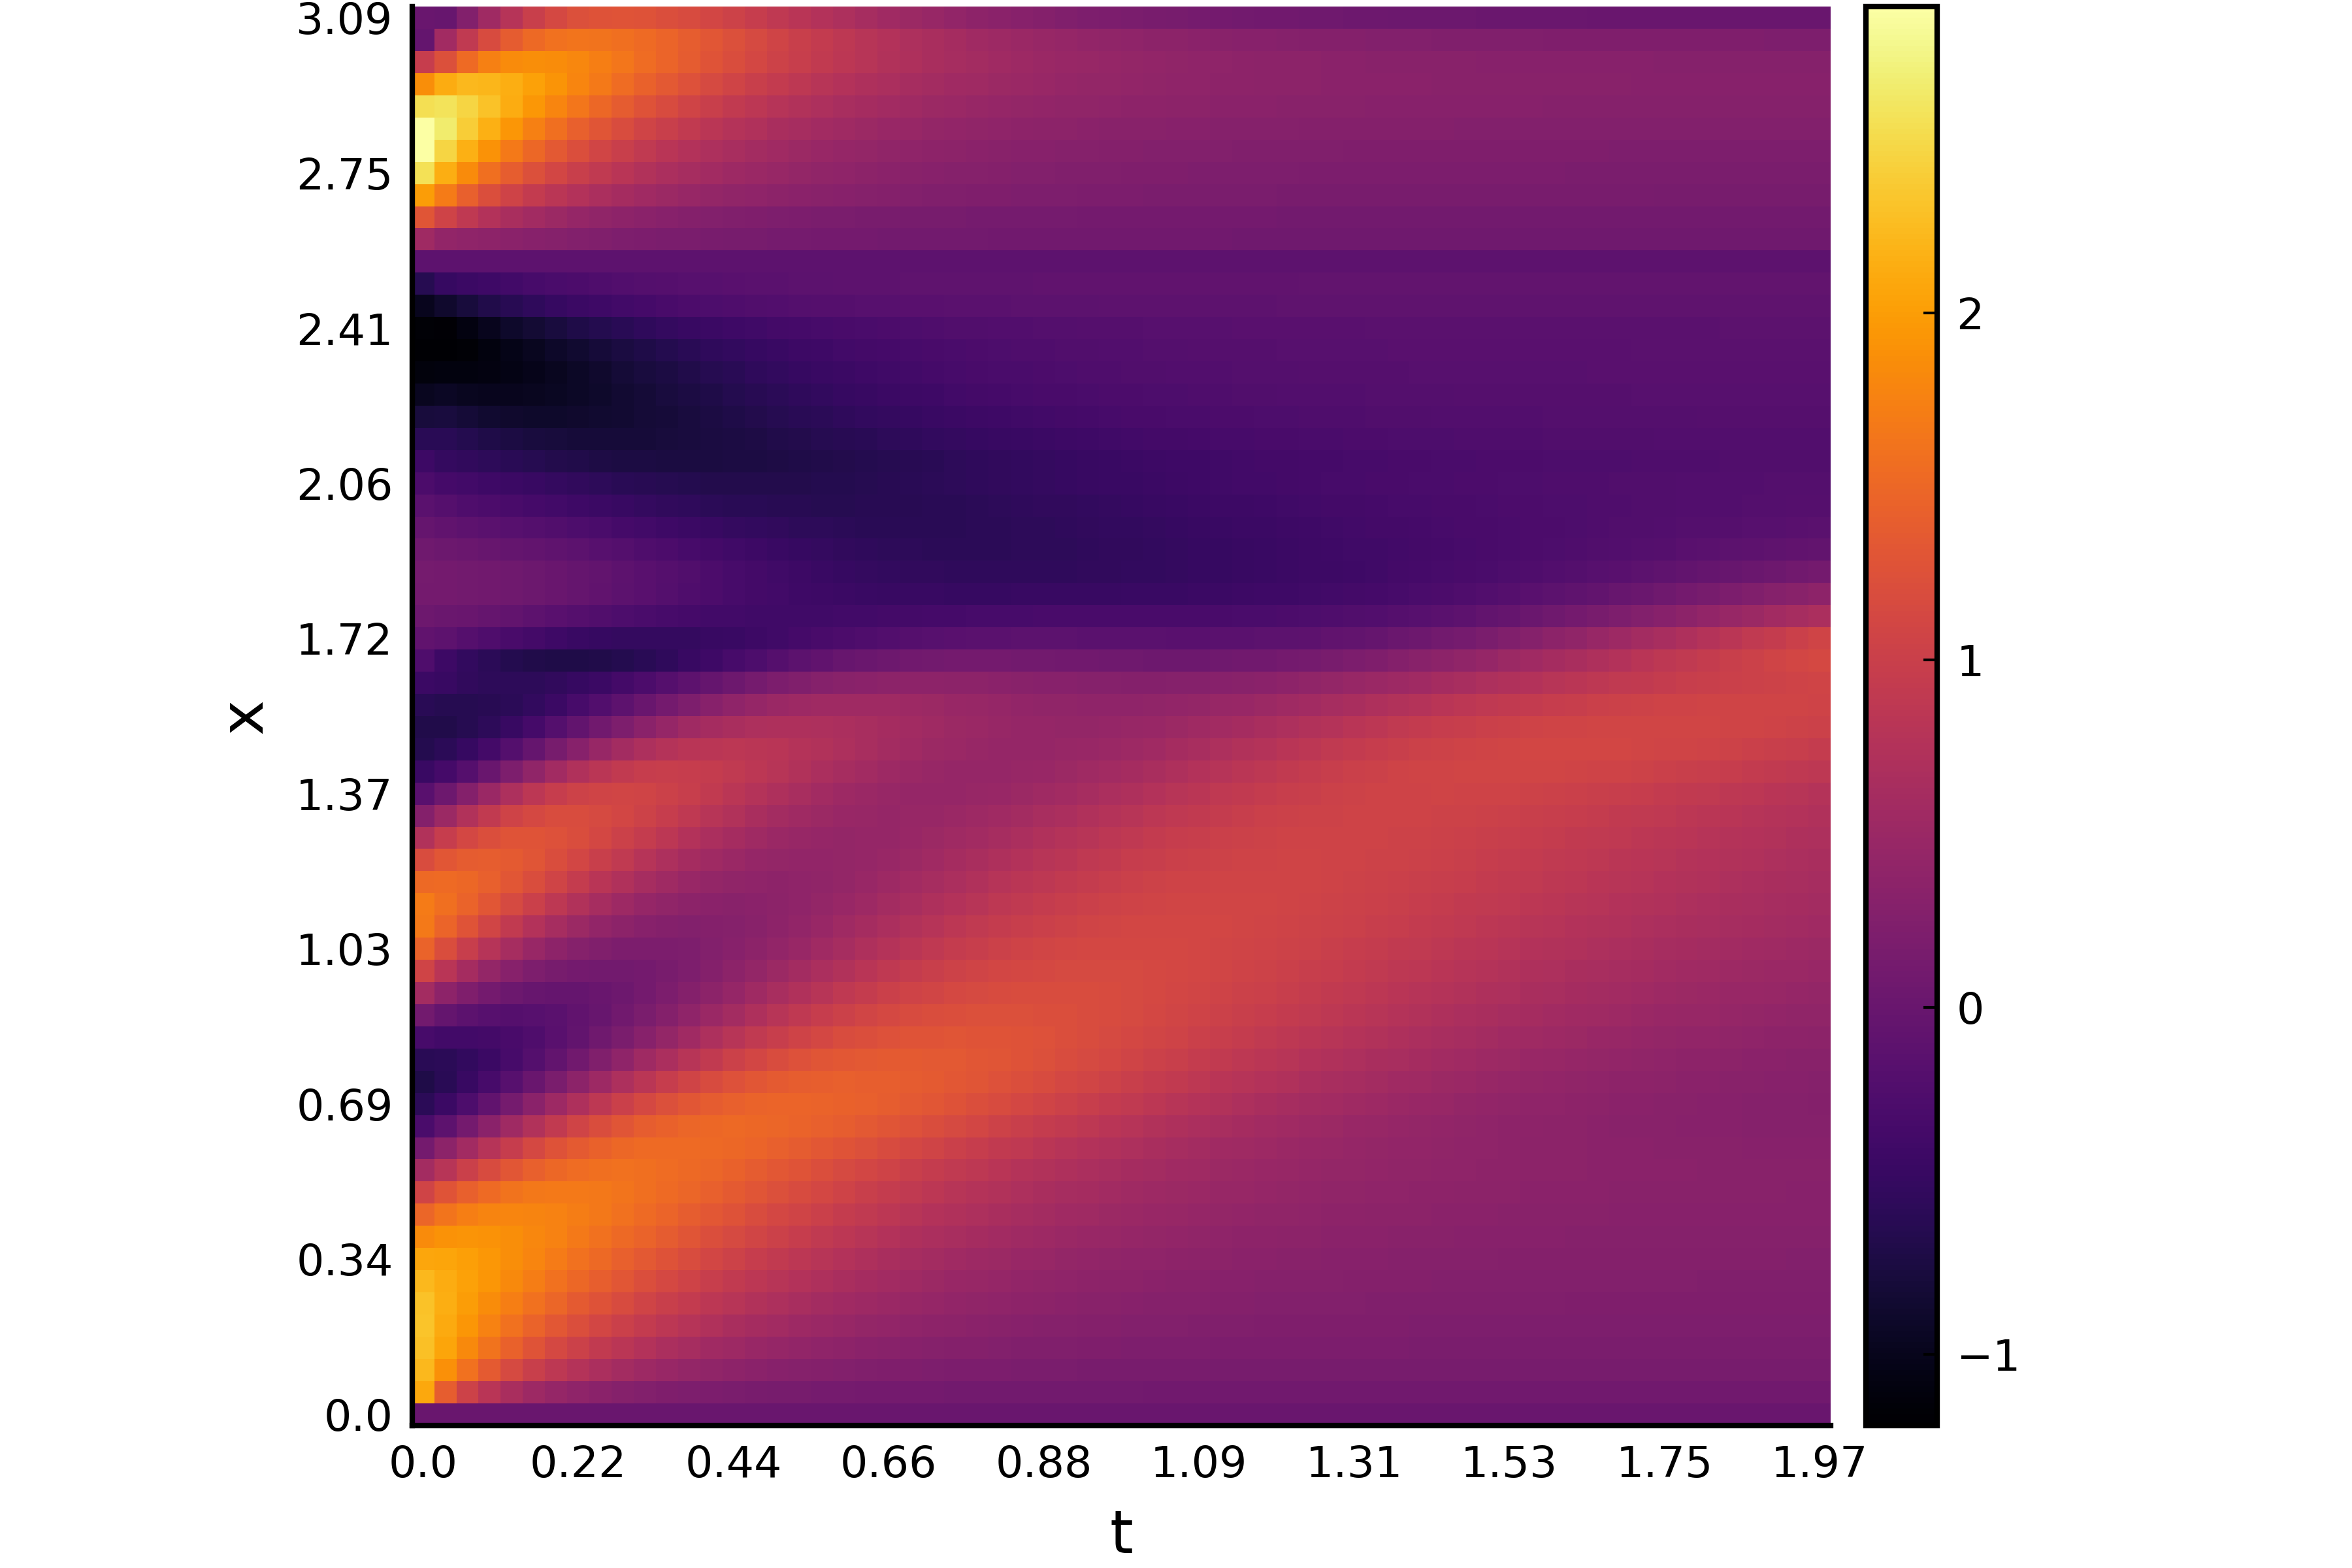

In [329]:
Ū = Equations.galerkin_projection(t, u1, ϕ[:, 1:48], nu, dx, dt);
GraphicTools.show_state(Ū, t, x, "", "t", "x")

## Analytical solution initial conditions

In [ ]:
#u0 = InitialFunctions.advecting_shock(t, x, nu);
u0 = exp.(-16 .* (x.^2));
t, u = Equations.get_burgers_fft(t, dx, x_n, nu, u0);
GraphicTools.show_state(u, "Snapshot")

In [ ]:
plot(t, x, u, st = :surface, xlabel = "t", ylabel = "x", zlabel = "u")
plot!(dpi=300)

---
# Generate data

In [333]:
t_max = 4.; # 6 (godunov)
t_min = 0.;
x_max = 1.; # 2pi (godunov)
x_min = 0.;
t_n = 64;
x_n = 64;

nu = 0.001;

dt = round((t_max - t_min) / (t_n - 1), digits=8);
dx = round((x_max - x_min) / (x_n - 1), digits=8);

t = LinRange(t_min, t_max, t_n);
x = LinRange(x_min, x_max, x_n);

In [395]:
n = 4; # not forget to update t_max, x_max, nu and typ
snap_kwargs = repeat([(; t_max=2., t_min=0., x_max=1., x_min=0., t_n, x_n, nu=0.001, typ=3)], n);
init_kwargs = repeat([(;  nu=0.001 )], n); # mu=0.25, sigma=1.
dataset_closure = Generator.generate_closure_dataset(n, 1, "", snap_kwargs, init_kwargs);
dataset_gp = Generator.generate_pod_gp(dataset_closure, 3, ""); # ./src/dataset/inviscid_burgers_advecting_shock_podgp_4_j173.jld2

Generating snapshot 1...Done
Generating snapshot 2...Done
Generating snapshot 3...Done
Generating snapshot 4...Done
Generating pod-gp snapshot 1...E = 0.892493034468976...Done
Generating pod-gp snapshot 2...E = 0.892493034468976...Done
Generating pod-gp snapshot 3...E = 0.892493034468976...Done
Generating pod-gp snapshot 4...E = 0.892493034468976...Done


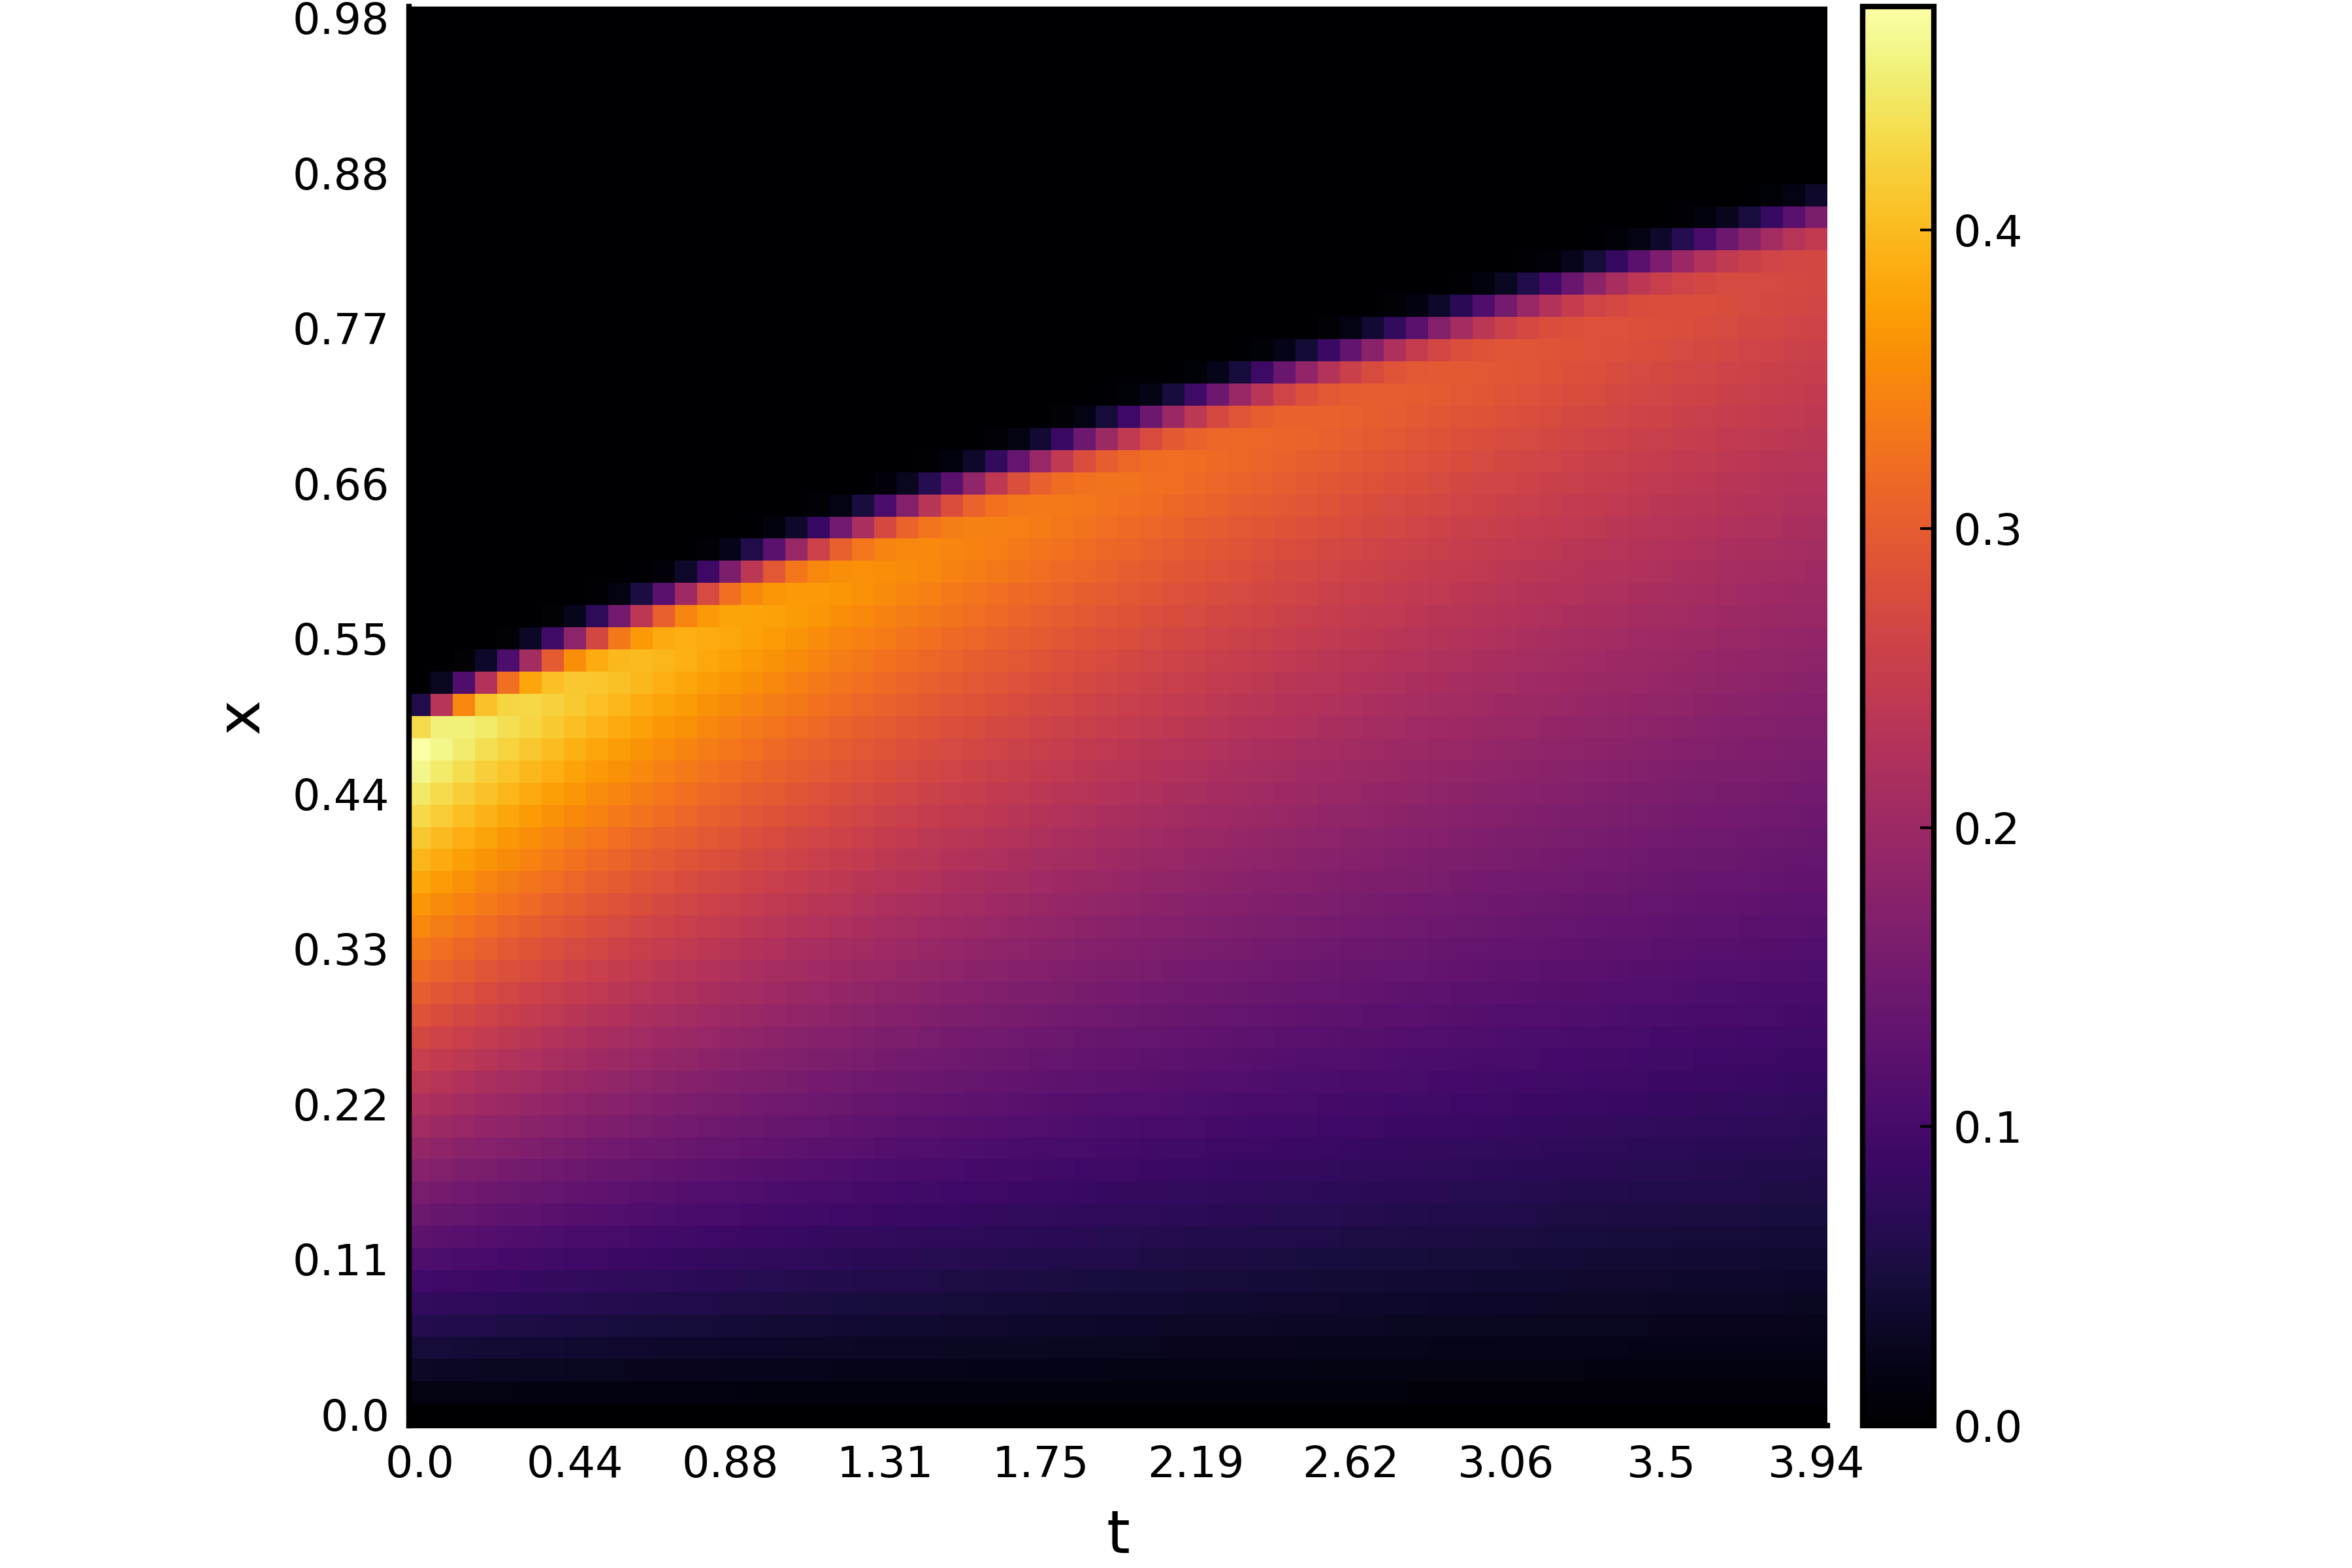

In [397]:
GraphicTools.show_state(dataset_gp[1][4], t, x, "", "t", "x")

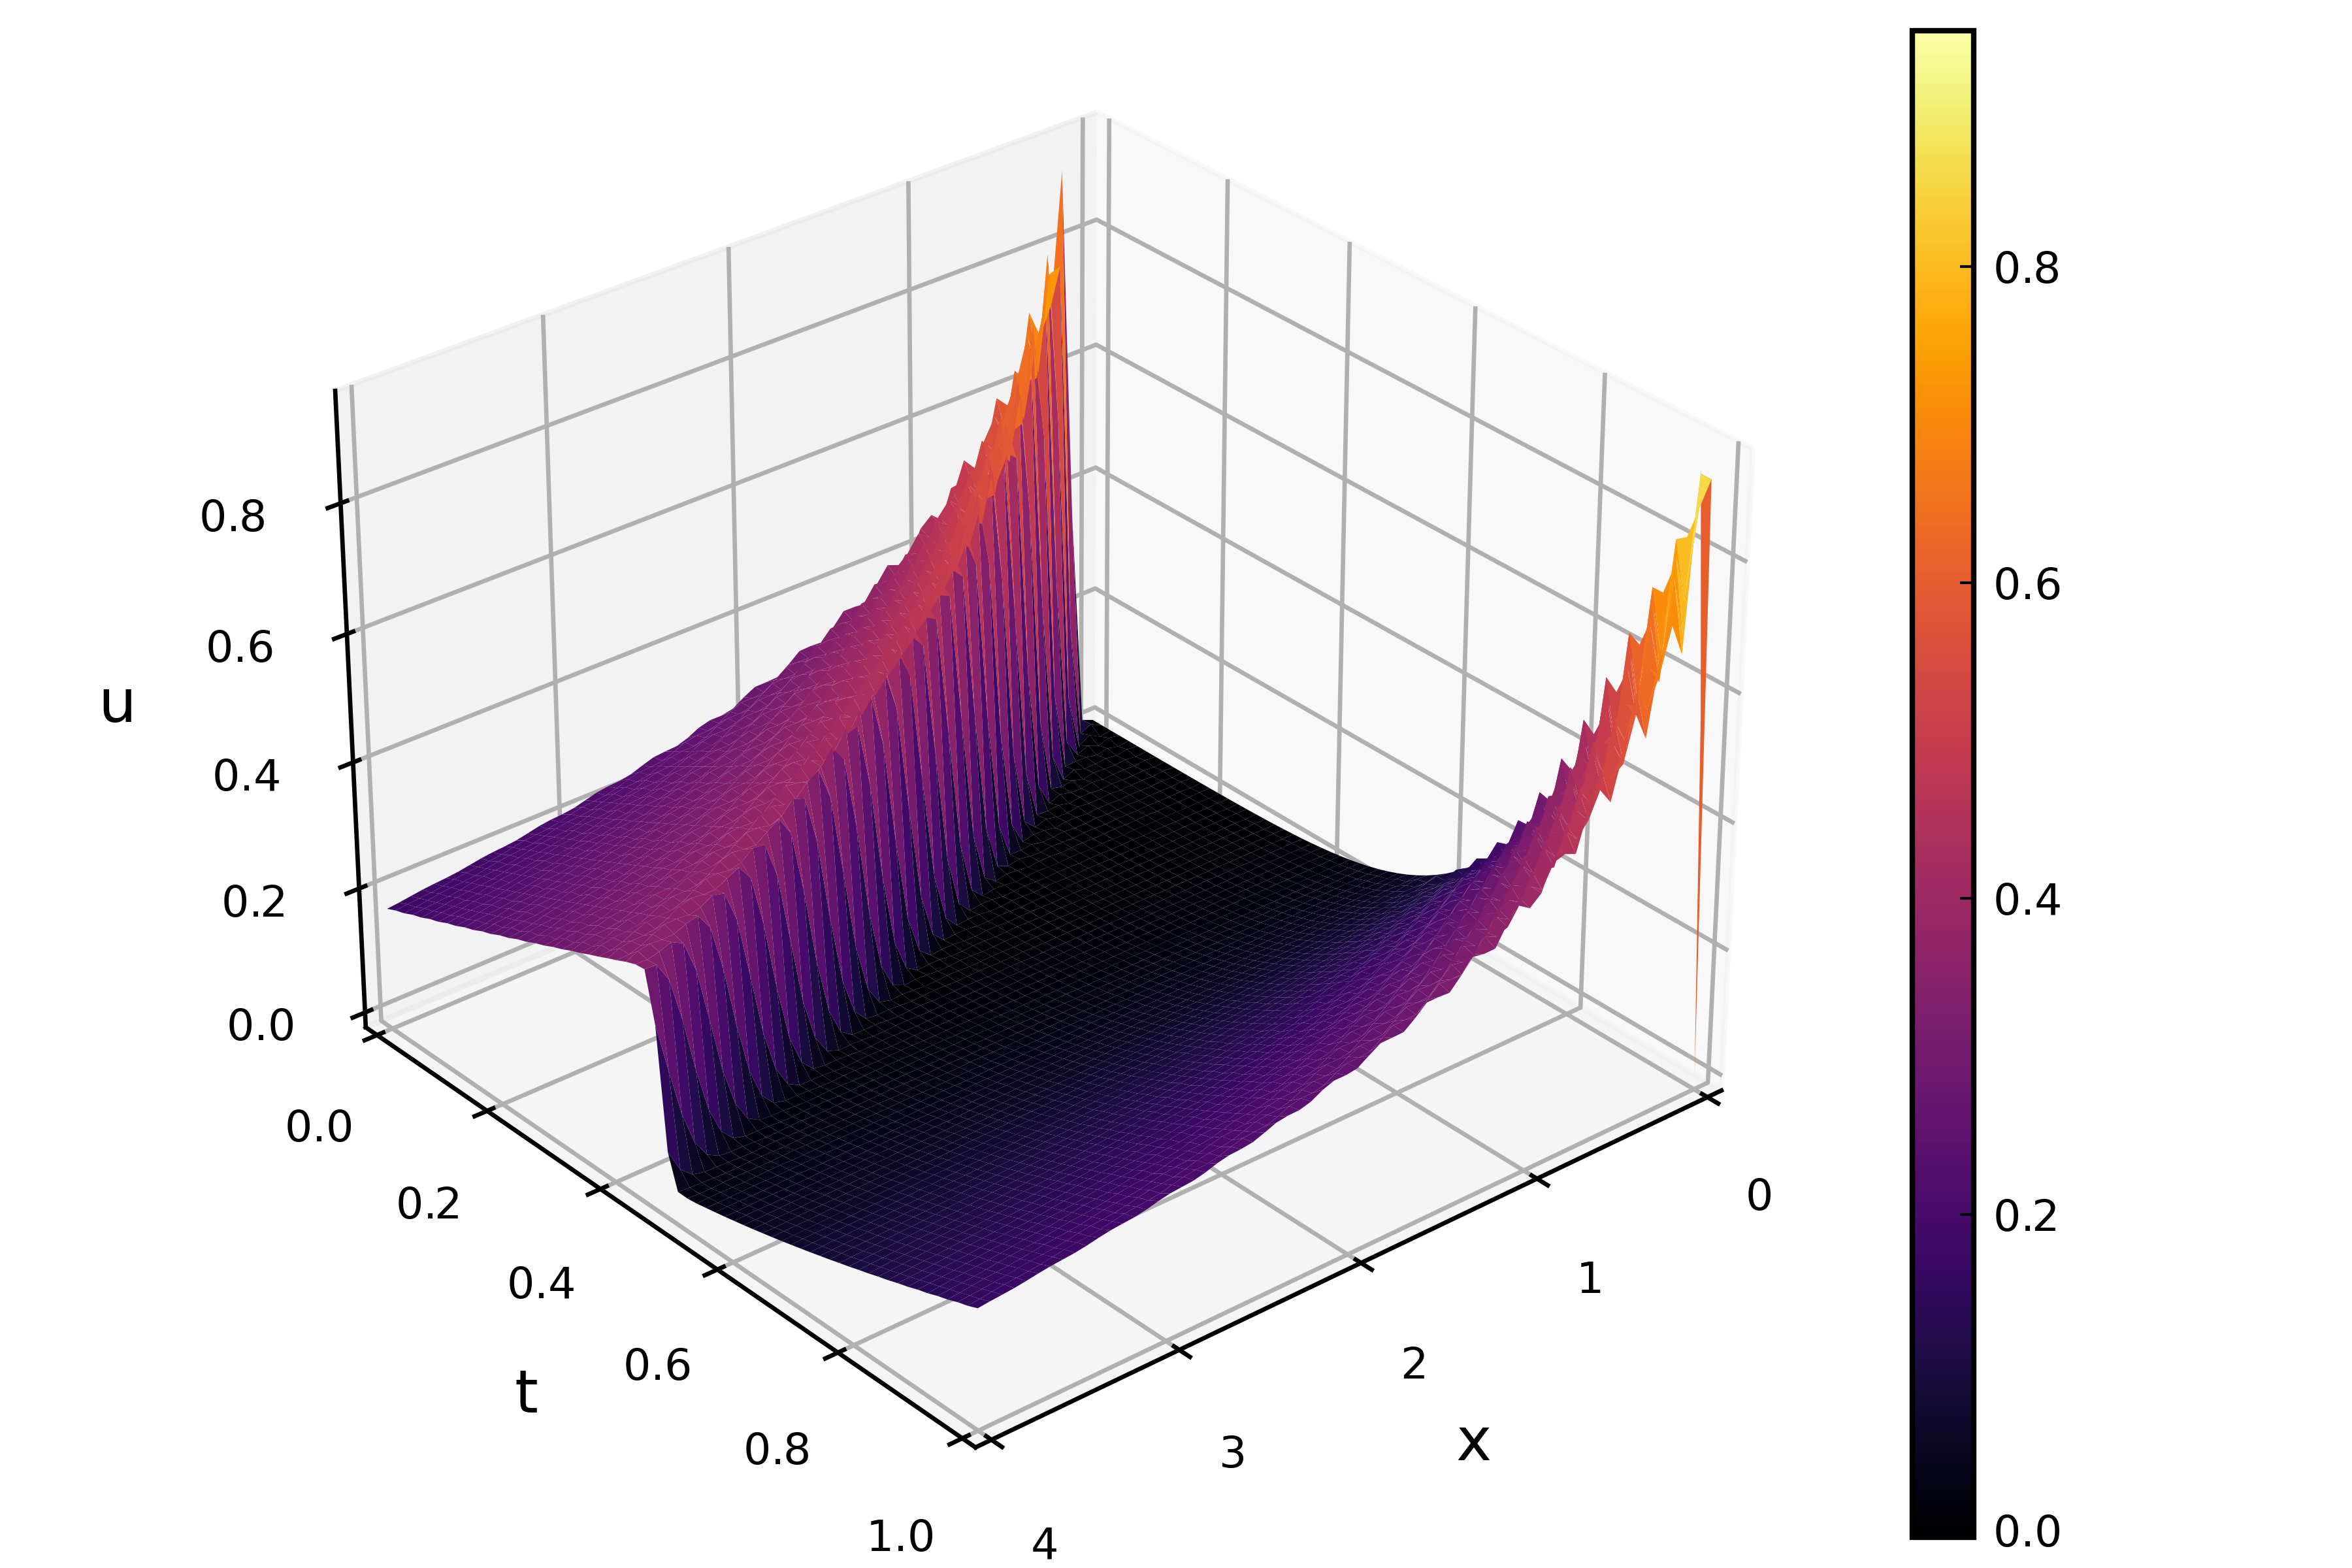

In [354]:
plot(t, x, dataset_gp[1][4], st = :surface, xlabel = "x", ylabel = "t", zlabel = "u", camera = (140, 30))
plot!(dpi=600)

In [294]:
struct Basis{T}
  modes::Matrix{T}
  coefficients::Matrix{T}
  eigenvalues::Vector{T}
end

function generate_pod_basis(M, substract_mean::Bool = false)
  n = size(M, 2)
  S = copy(M);

  sm = mean(S, dims=2);
  if substract_mean
      S .-= sm;
  end

  C = S' * S;
  E = eigen!(C);
  λ = E.values;
  W = E.vectors;

  idx = sortperm(abs.(λ) / n, rev=true) # removed abs.(λ)
  λ = λ[idx]
  W = W[:, idx]
  
  D = sqrt.(abs.(λ));
  θ = S * W * Diagonal(1 ./ D);
  # A = Diagonal(D) * W';
  A = θ' * S;

  return Basis(θ, A, abs.(λ)), sm
end

function PODsvd(M, subtractmean::Bool = false)
    S = copy(M);
    
    sm = mean(S, dims=2);
    if subtractmean
        S .-= sm;
    end

    F = svd!(S)
    θ = F.U # -1 * F.U corresponds to paper results but generate bad reconstruction
    λ = F.S
    A = Diagonal(F.S)*F.Vt

    return Basis(θ, A, λ), sm

end

PODsvd (generic function with 2 methods)

In [272]:
include("src/equations/solvers.jl");

function galerkin_projection(t, S, Φ, ν, dx, dt)
  u0 = copy(S[:, 1]);
  ū = mean(S, dims=2)[:, 1];
  n_modes = size(Φ)[2];

  function L(u)
    """ Linear operator """
    û = zeros(size(u)[1] + 2);
    û[2:end-1] = copy(u);
    û[1] = u[end];
    û[end] = u[1];
    return (û[1:end-2] - 2 * û[2:end-1] + û[3:end]) ./ (dx^2);
  end

  function N(u, v)
    """ Non-linear operator """
    v̂ = zeros(size(v)[1] + 2);
    v̂[2:end-1] = copy(v);
    v̂[1] = v[end];
    v̂[end] = v[1];

    dvdx =  - (v̂[3:end] - v̂[1:end-2]) ./ (2. * dx);
    return u .* dvdx
  end

  # Compute offline operators
  Lū = ν * L(ū);
  Nū = N(ū, ū);

  r = n_modes;
  B_k = zeros(r);
  L_k = zeros(r, r);
  N_k = zeros(r, r, r);

  for k in range(1, n_modes, step=1)
    B_k[k] = sum((Lū + Nū) .* Φ[:, k]);

    for i in range(1, n_modes, step=1)
      L_k[k, i] = sum((ν * L(Φ[:, i]) + N(ū, Φ[:, i]) + N(Φ[:, i], ū)) .* Φ[:, k]);

      for j in range(1, n_modes, step=1)
        N_k[k, i, j] = sum(N(Φ[:, i], Φ[:, j]) .* Φ[:, k]);
      end
    end
  end

  # Compute online operators
  function gp(a, B_k, L_k, N_k)
    dadt = B_k;
    dadt += L_k * a;

    for k in r
      dadt[k] = dadt[k] + (N_k[k, :, :] * a)' * a;
    end

    return dadt
  end

  a = Φ' * (u0 .- ū);

  g = (x) -> gp(x, B_k, L_k, N_k);
  A = zeros(size(a)[1], size(t)[1])
  for (i, v) in enumerate(t)
    A[:, i] = copy(a);
    a = Solver.tvd_rk3(g, a, dt);
  end

  return ū .+ Φ * A, A;
end

galerkin_projection (generic function with 1 method)

In [335]:
bas, ū = PODsvd(dataset_gp[1][4][:, :], true);
ϕ = bas.modes;
coeff = bas.coefficients;
tmp = ϕ[:, 1:end] * coeff[1:end, :] .+ ū;
Ū, A = galerkin_projection(t, dataset_gp[1][4], ϕ[:, 1:3], 0.001, dx, dt);
# GraphicTools.show_state(Ū, t, x, "", "t", "x")

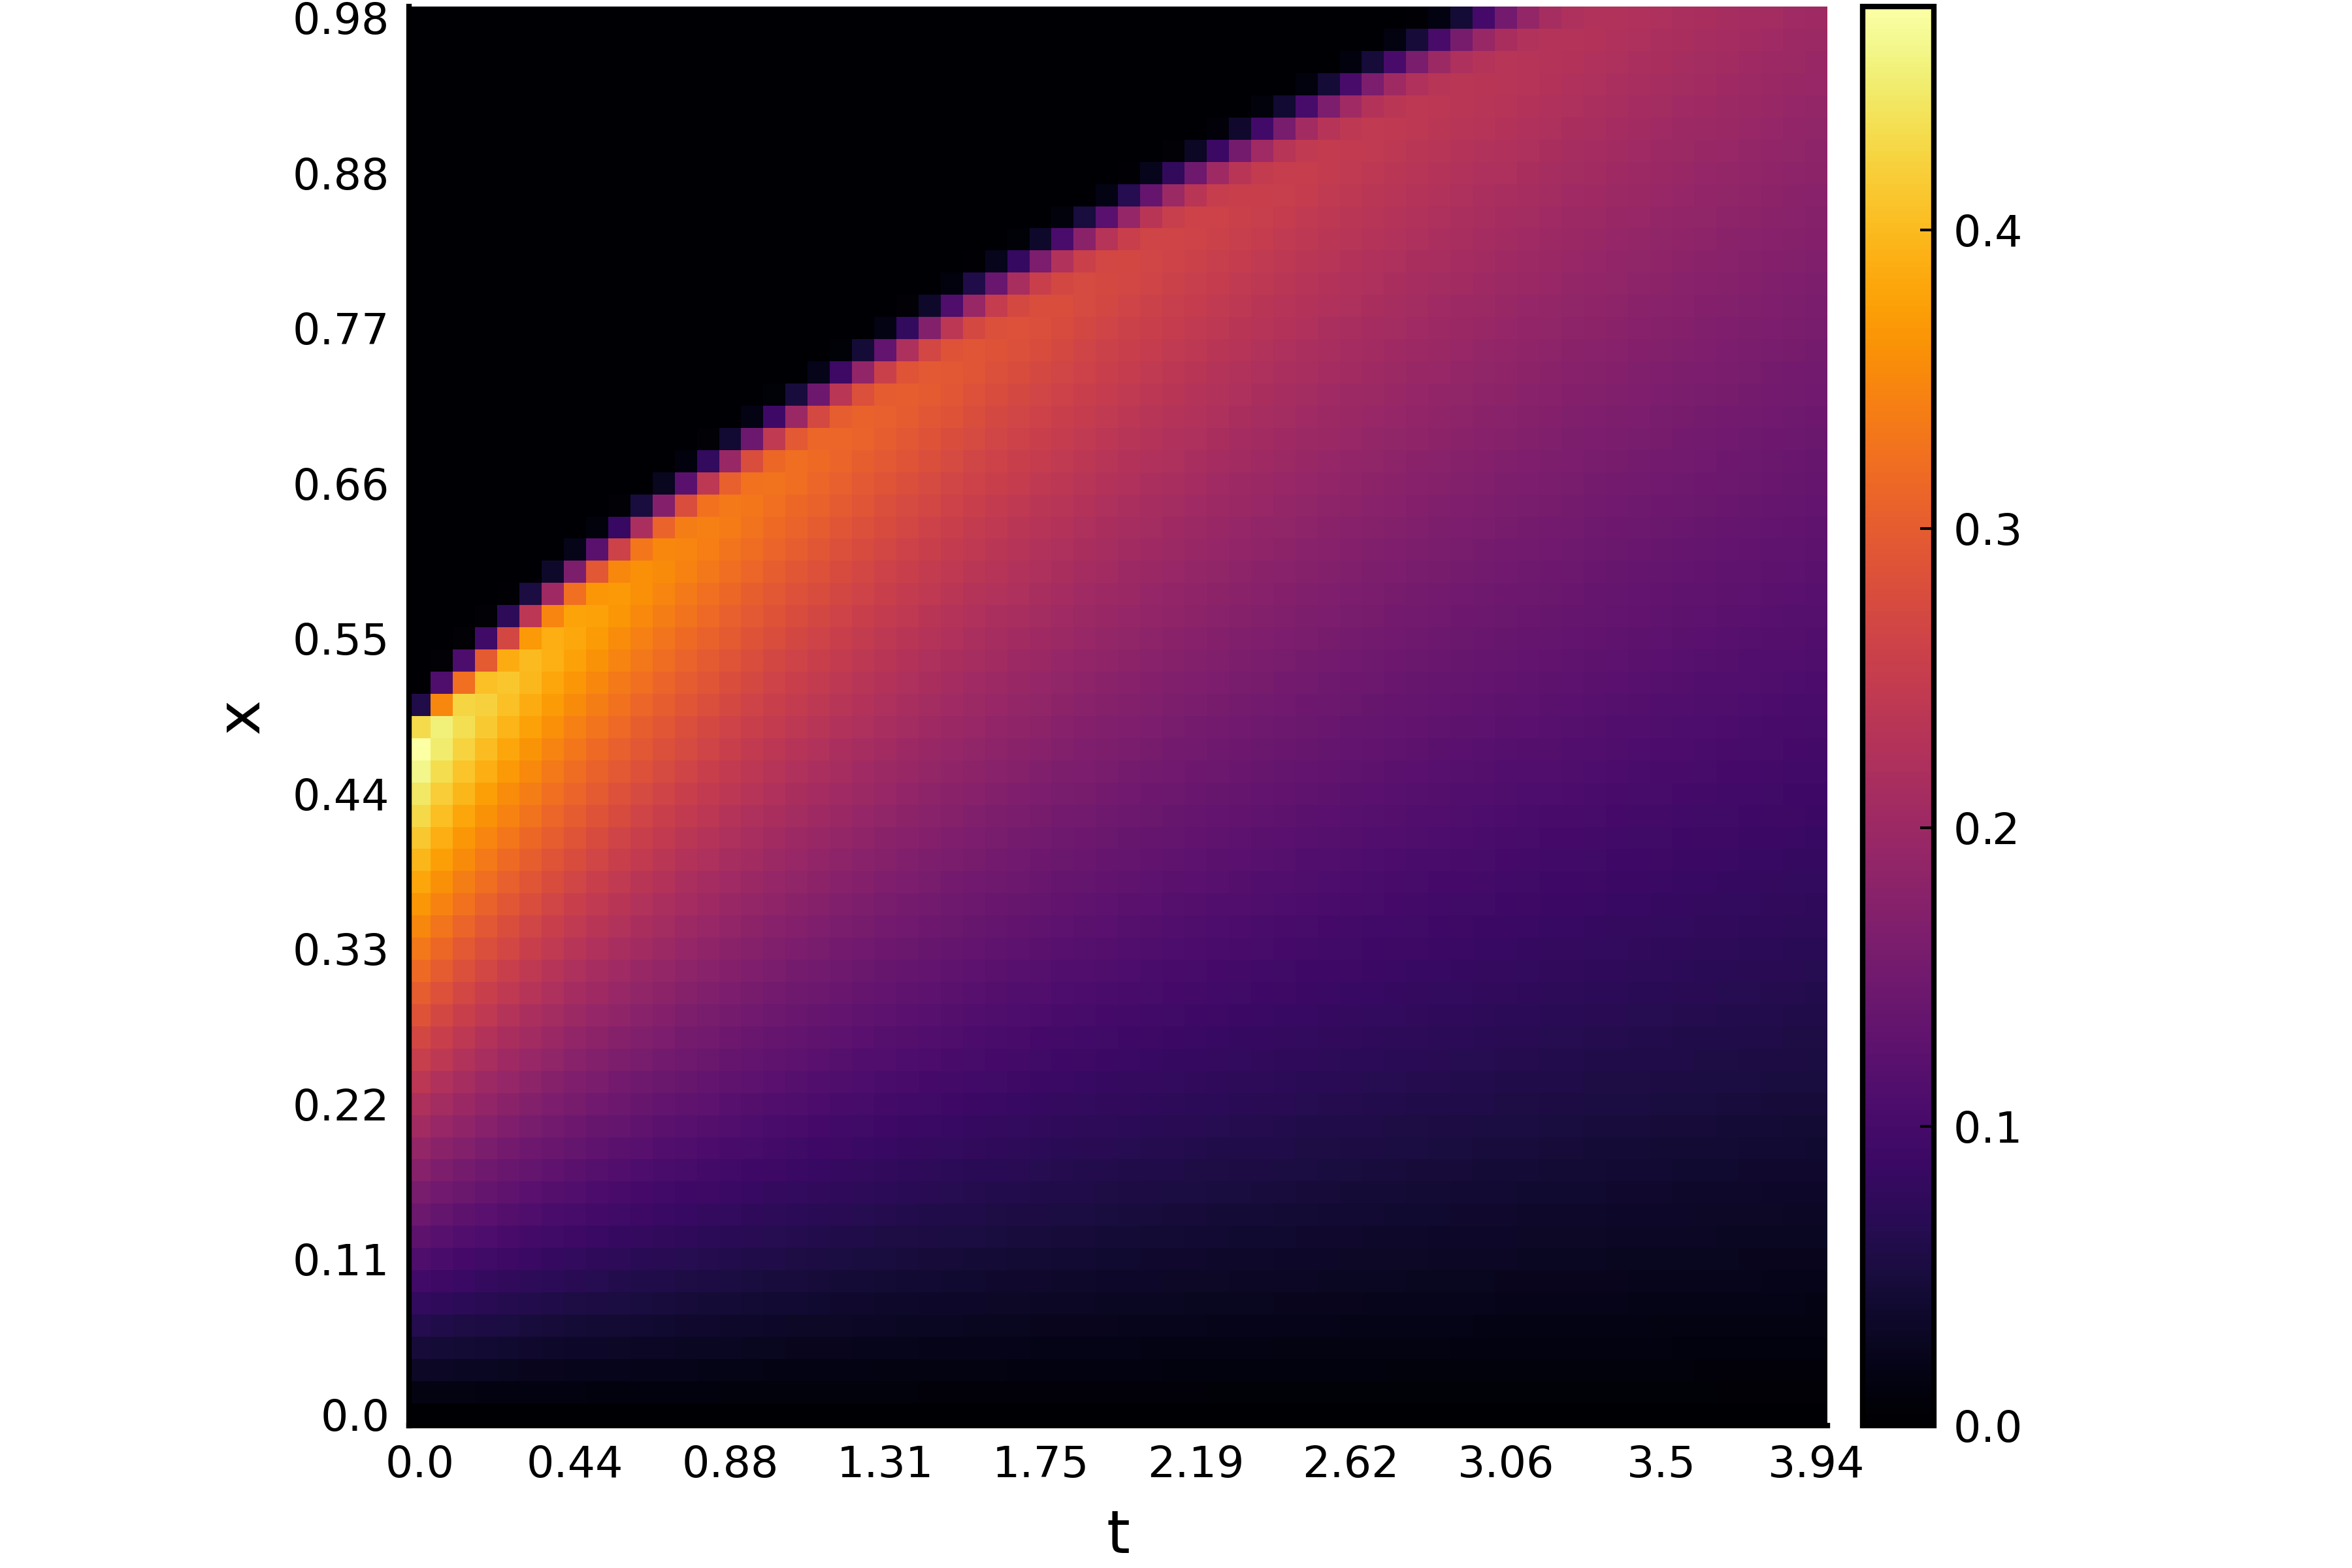

In [336]:
GraphicTools.show_state(tmp, t, x, "", "t", "x")

In [338]:
POD.get_energy(bas.eigenvalues, 3)

0.5441358337842925

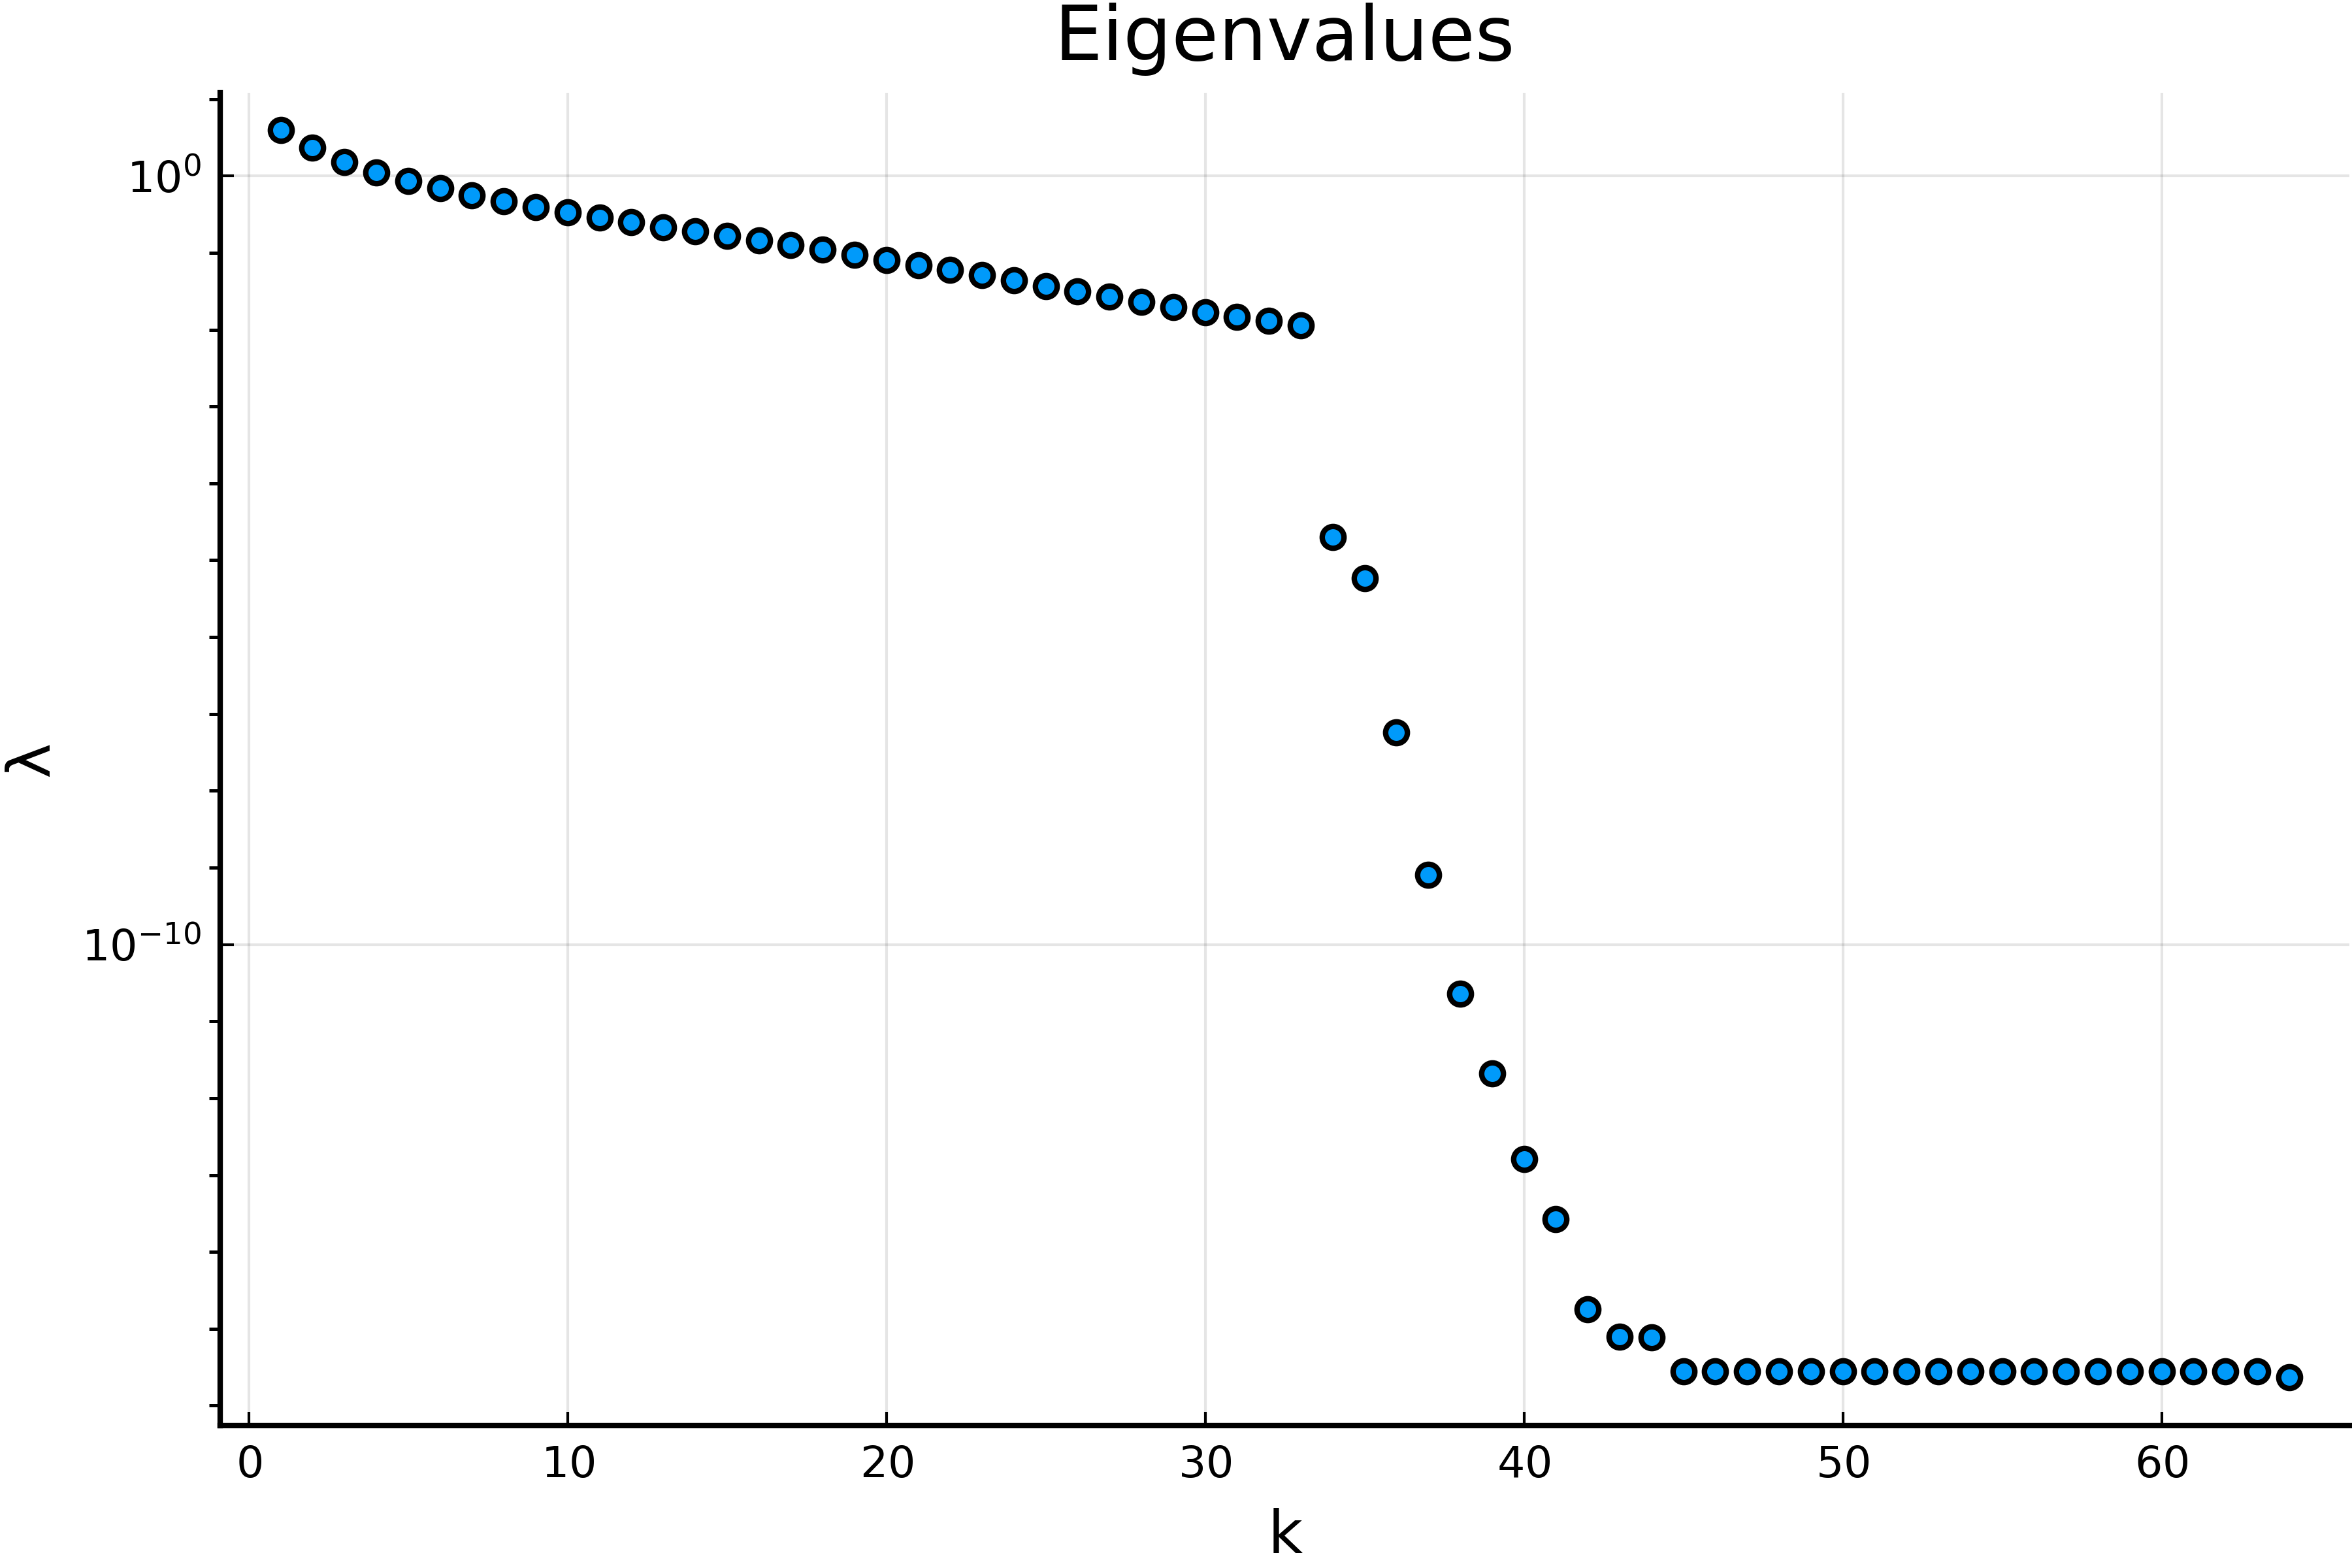

In [339]:
λ = bas.eigenvalues;
k = collect(1:size(λ)[1]);
plt = scatter(title="Eigenvalues", xlabel="k", ylabel="λ", yaxis=:log, dpi=600, aspect_ratio=:auto, legend=:none)
scatter!(plt, k, λ)

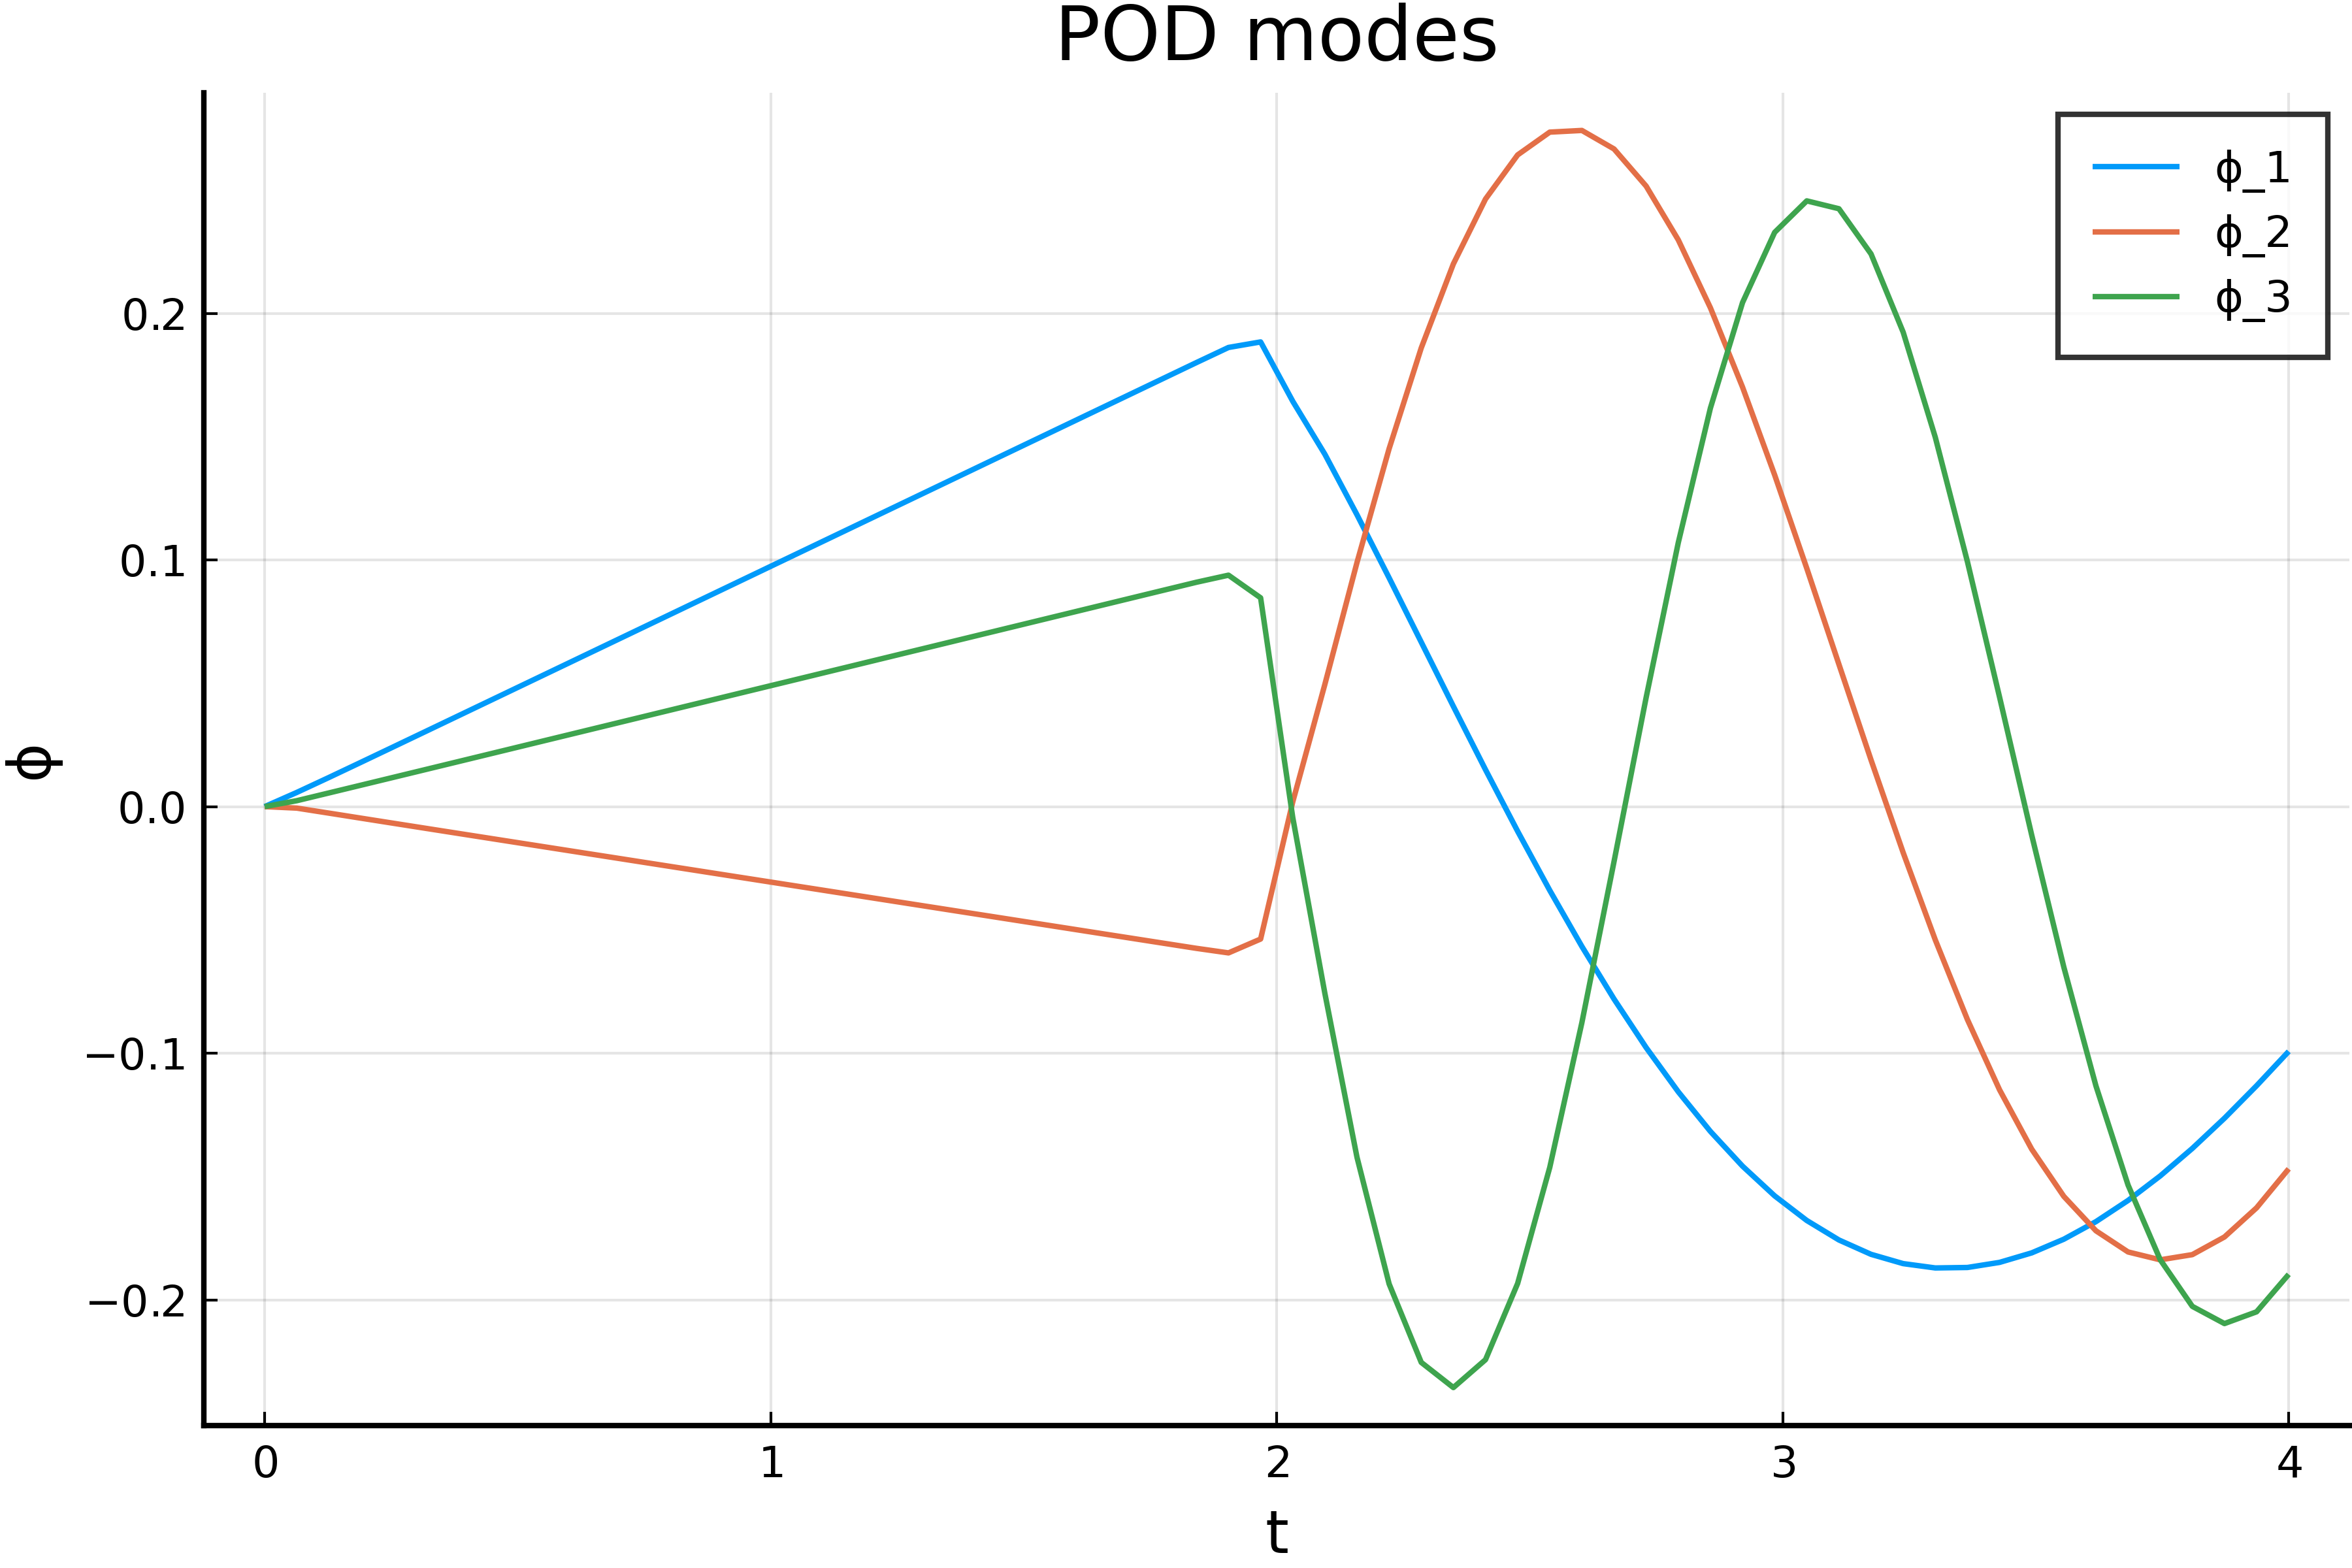

In [340]:
plt = plot(title="POD modes", xlabel="t", ylabel="ϕ", background_color_legend = RGBA(1, 1, 1, 0.8))
plot!(plt; dpi=600)
plot!(plt, t, -ϕ[:, 1], label="ϕ_1")
plot!(plt, t, -ϕ[:, 2], label="ϕ_2")
plot!(plt, t, -ϕ[:, 3], label="ϕ_3")

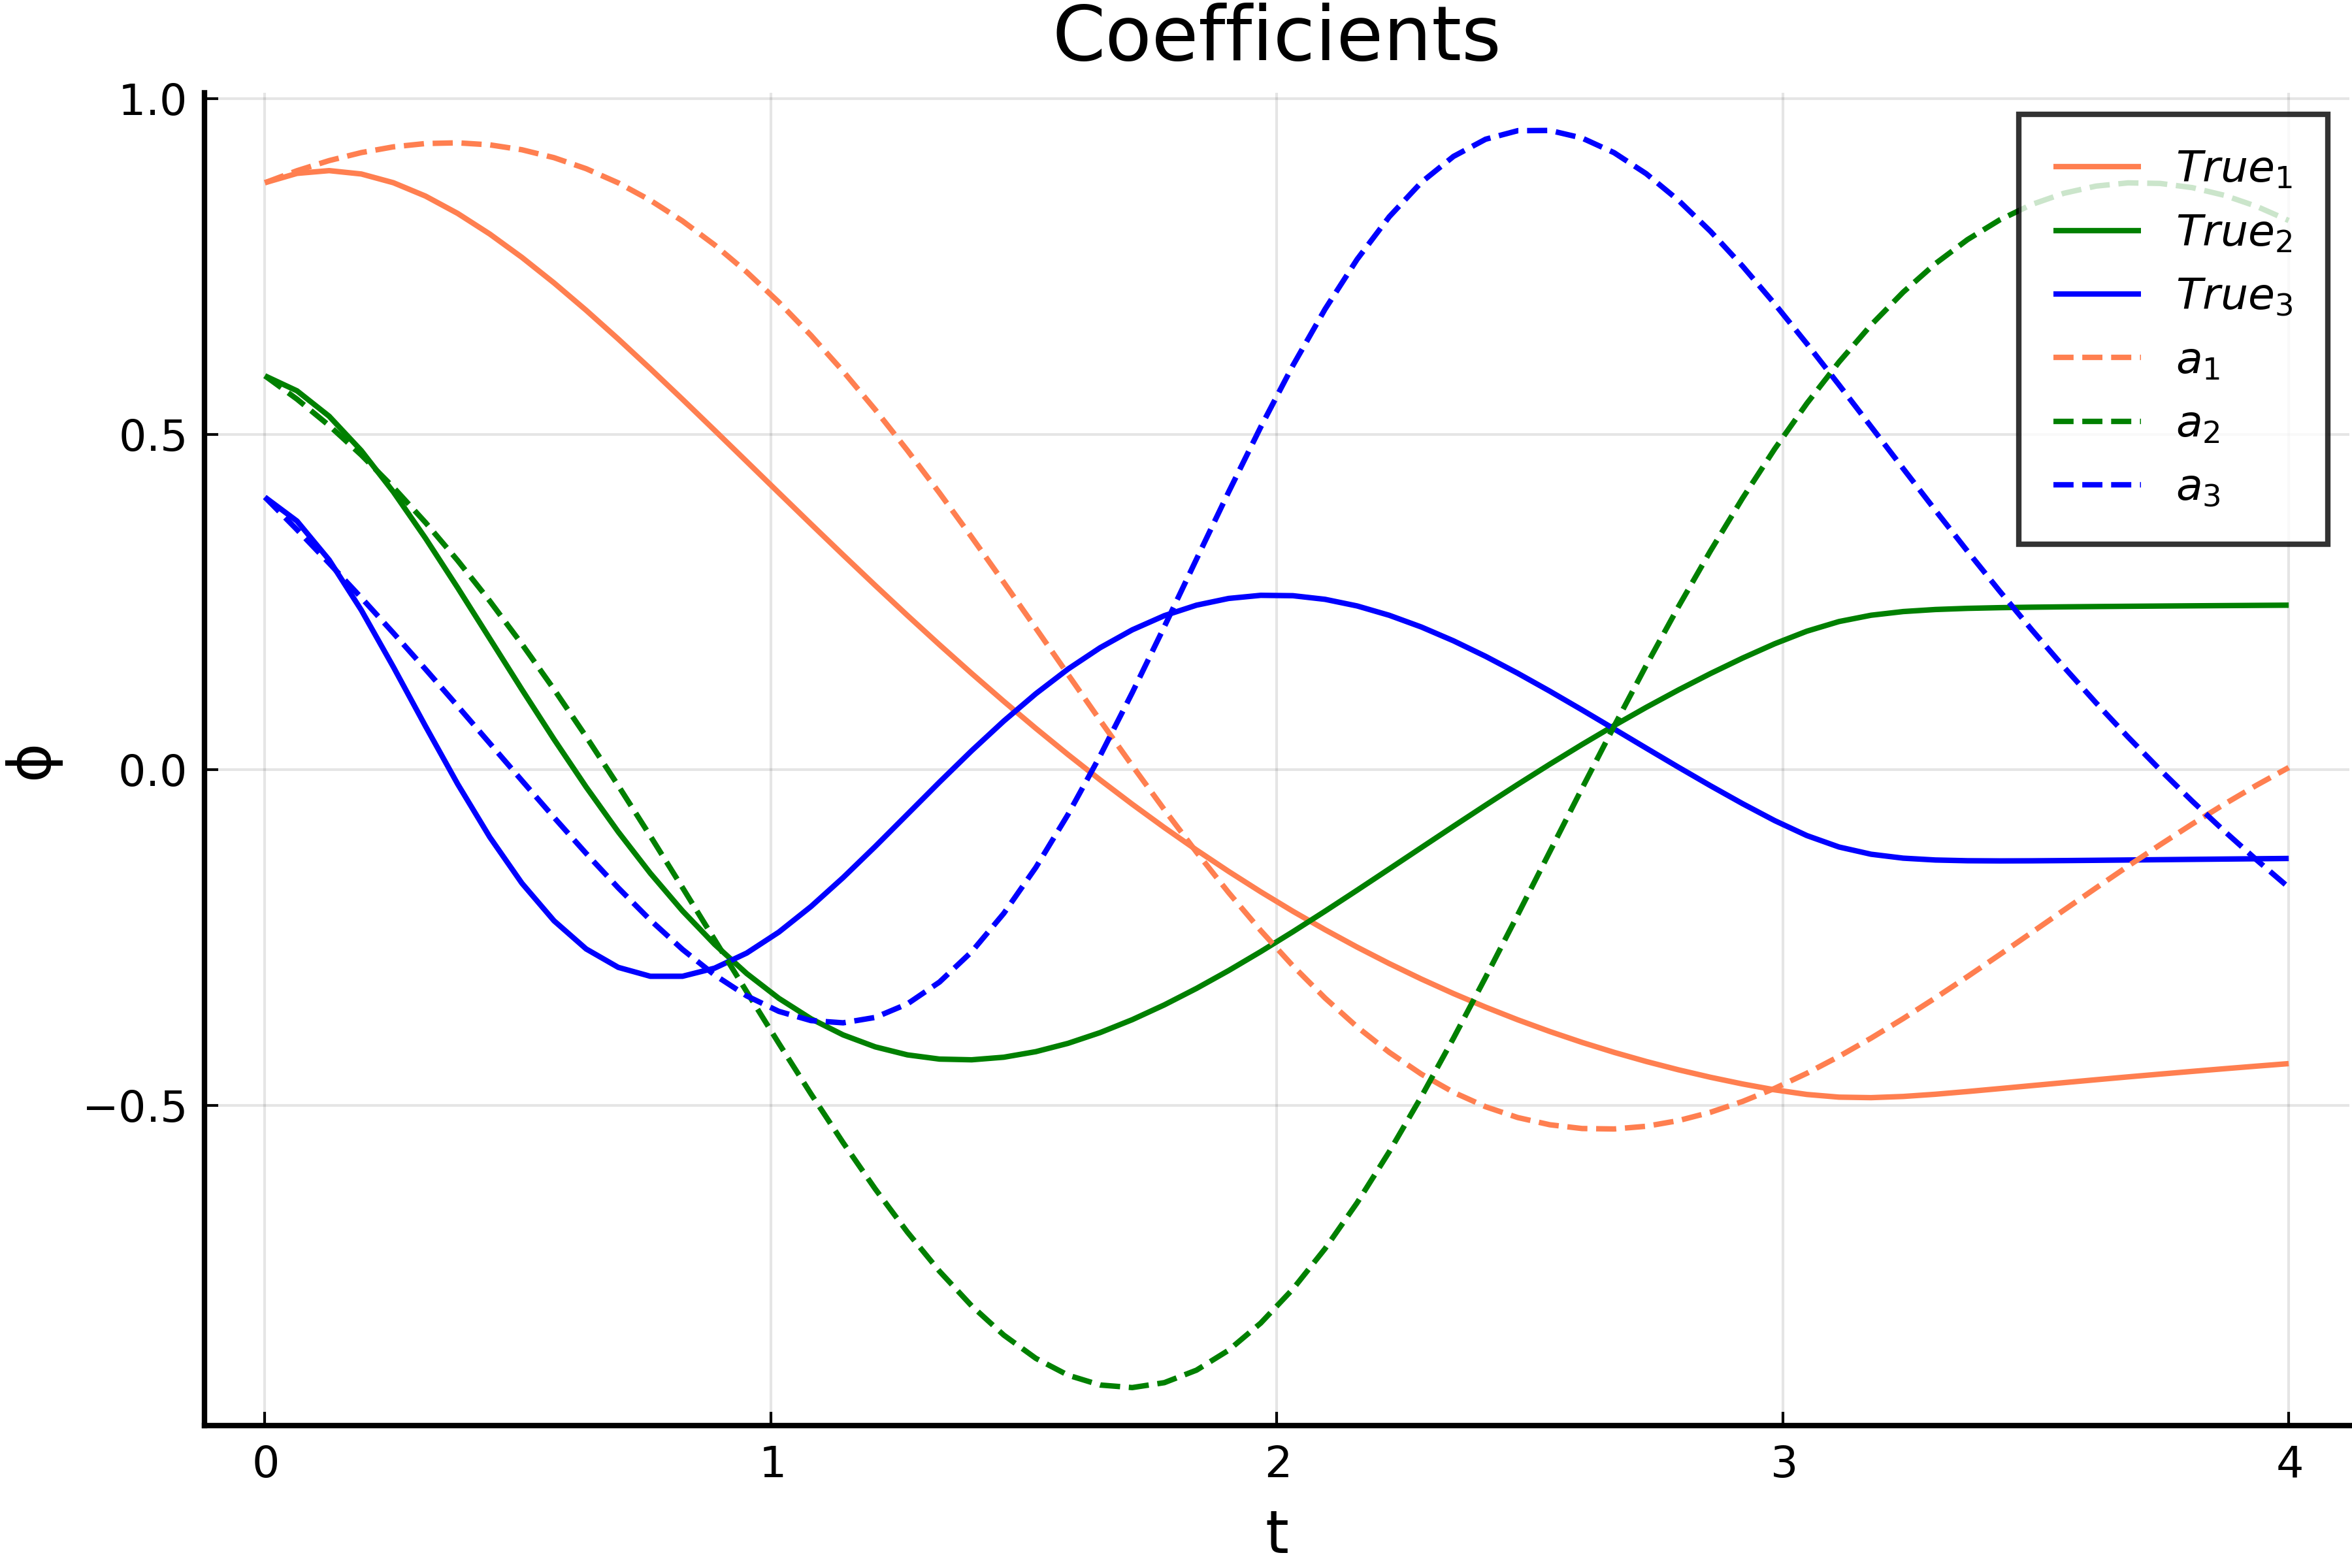

In [344]:
using LaTeXStrings


plt = plot(title="Coefficients", xlabel="t", ylabel="ϕ", background_color_legend = RGBA(1, 1, 1, 0.8))
plot!(plt; dpi=600)
plot!(plt, t, -coeff[1, :], c=:coral, label=L"True_1")
plot!(plt, t, coeff[2, :], c=:green, label=L"True_2")
plot!(plt, t, -coeff[3, :], c=:blue, label=L"True_3")

plot!(plt, t, -A[1, :], c=:coral, linestyle=:dash,label=L"a_1")
plot!(plt, t, A[2, :], c=:green, linestyle=:dash,label=L"a_2")
plot!(plt, t, -A[3, :], c=:blue, linestyle=:dash,label=L"a_3")

In [622]:
# snap_kwargs = (; t_max, t_min, x_max, x_min, t_n, x_n, nu, typ=2);
# init_kwargs = (; m=10);
# dataset = Generator.generate_burgers_training_dataset(256, 2, 1, false, "./src/dataset/viscous_burgers_high_dim_m10_256_j173.jld2", "training_set", snap_kwargs, init_kwargs);
# dataset = Generator.read_dataset("./src/examples/burgers/dataset/inviscid_burgers_advecting_shock_podgp_4_j173.jld2")["training_set"];

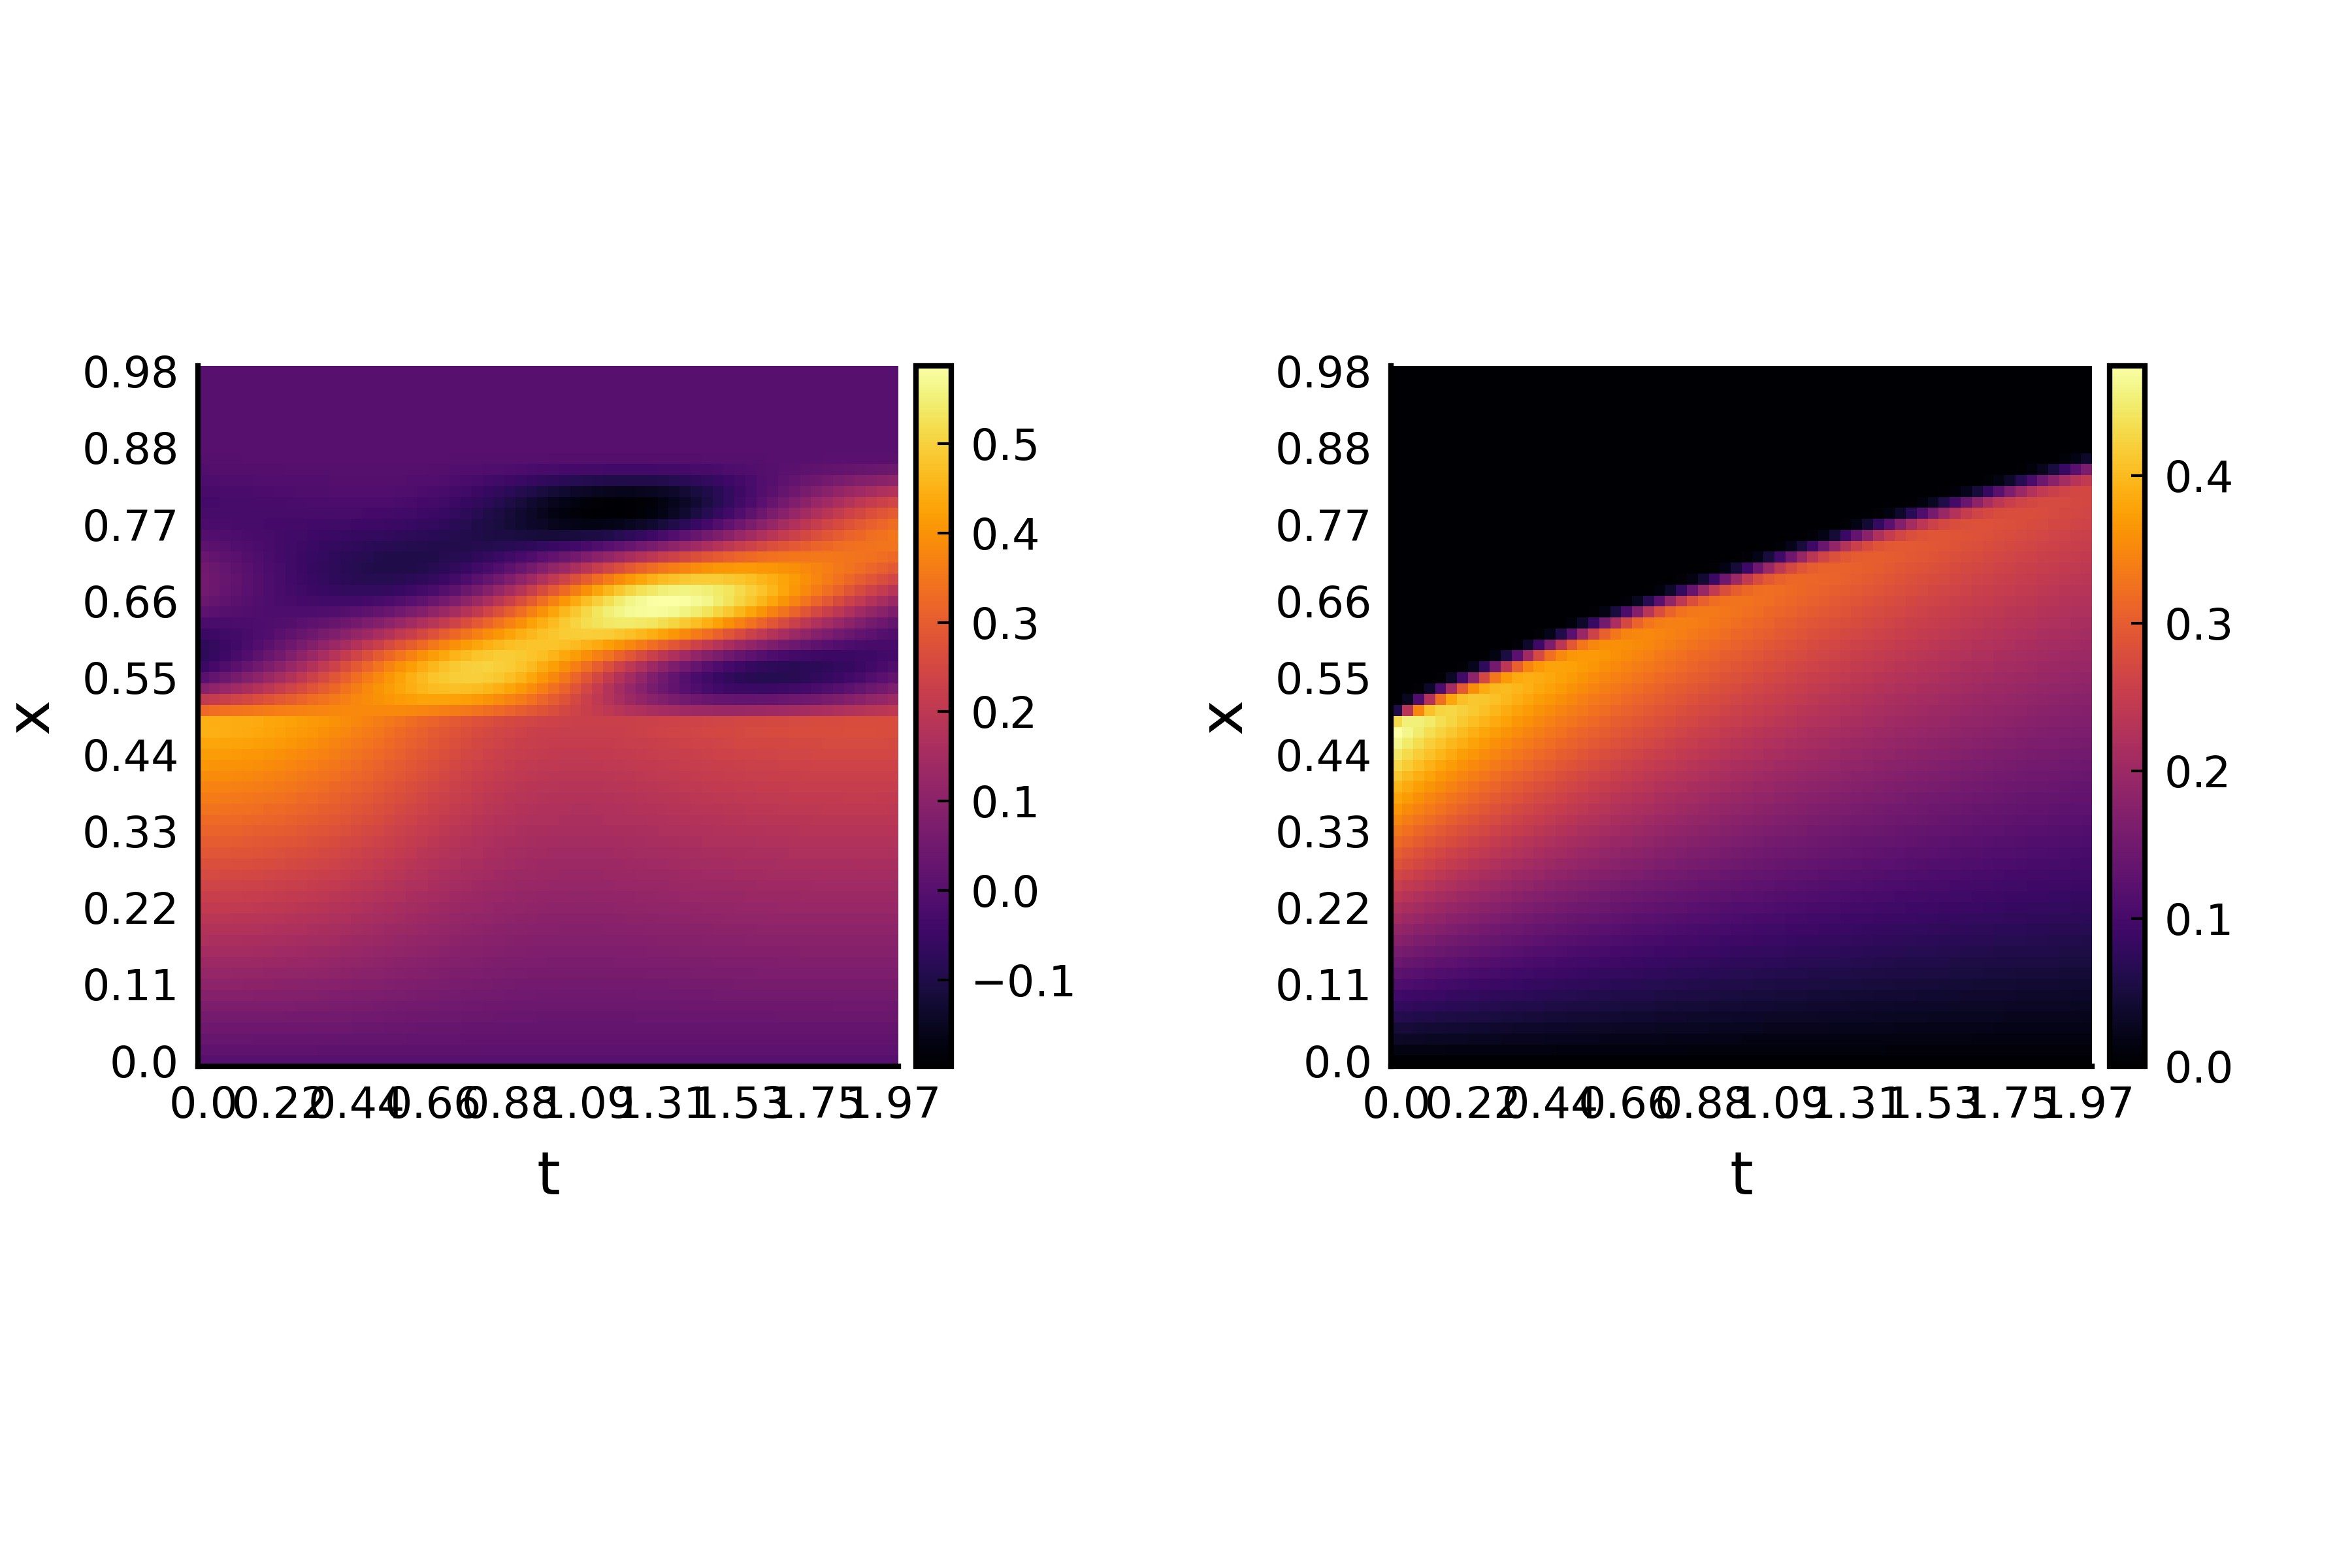

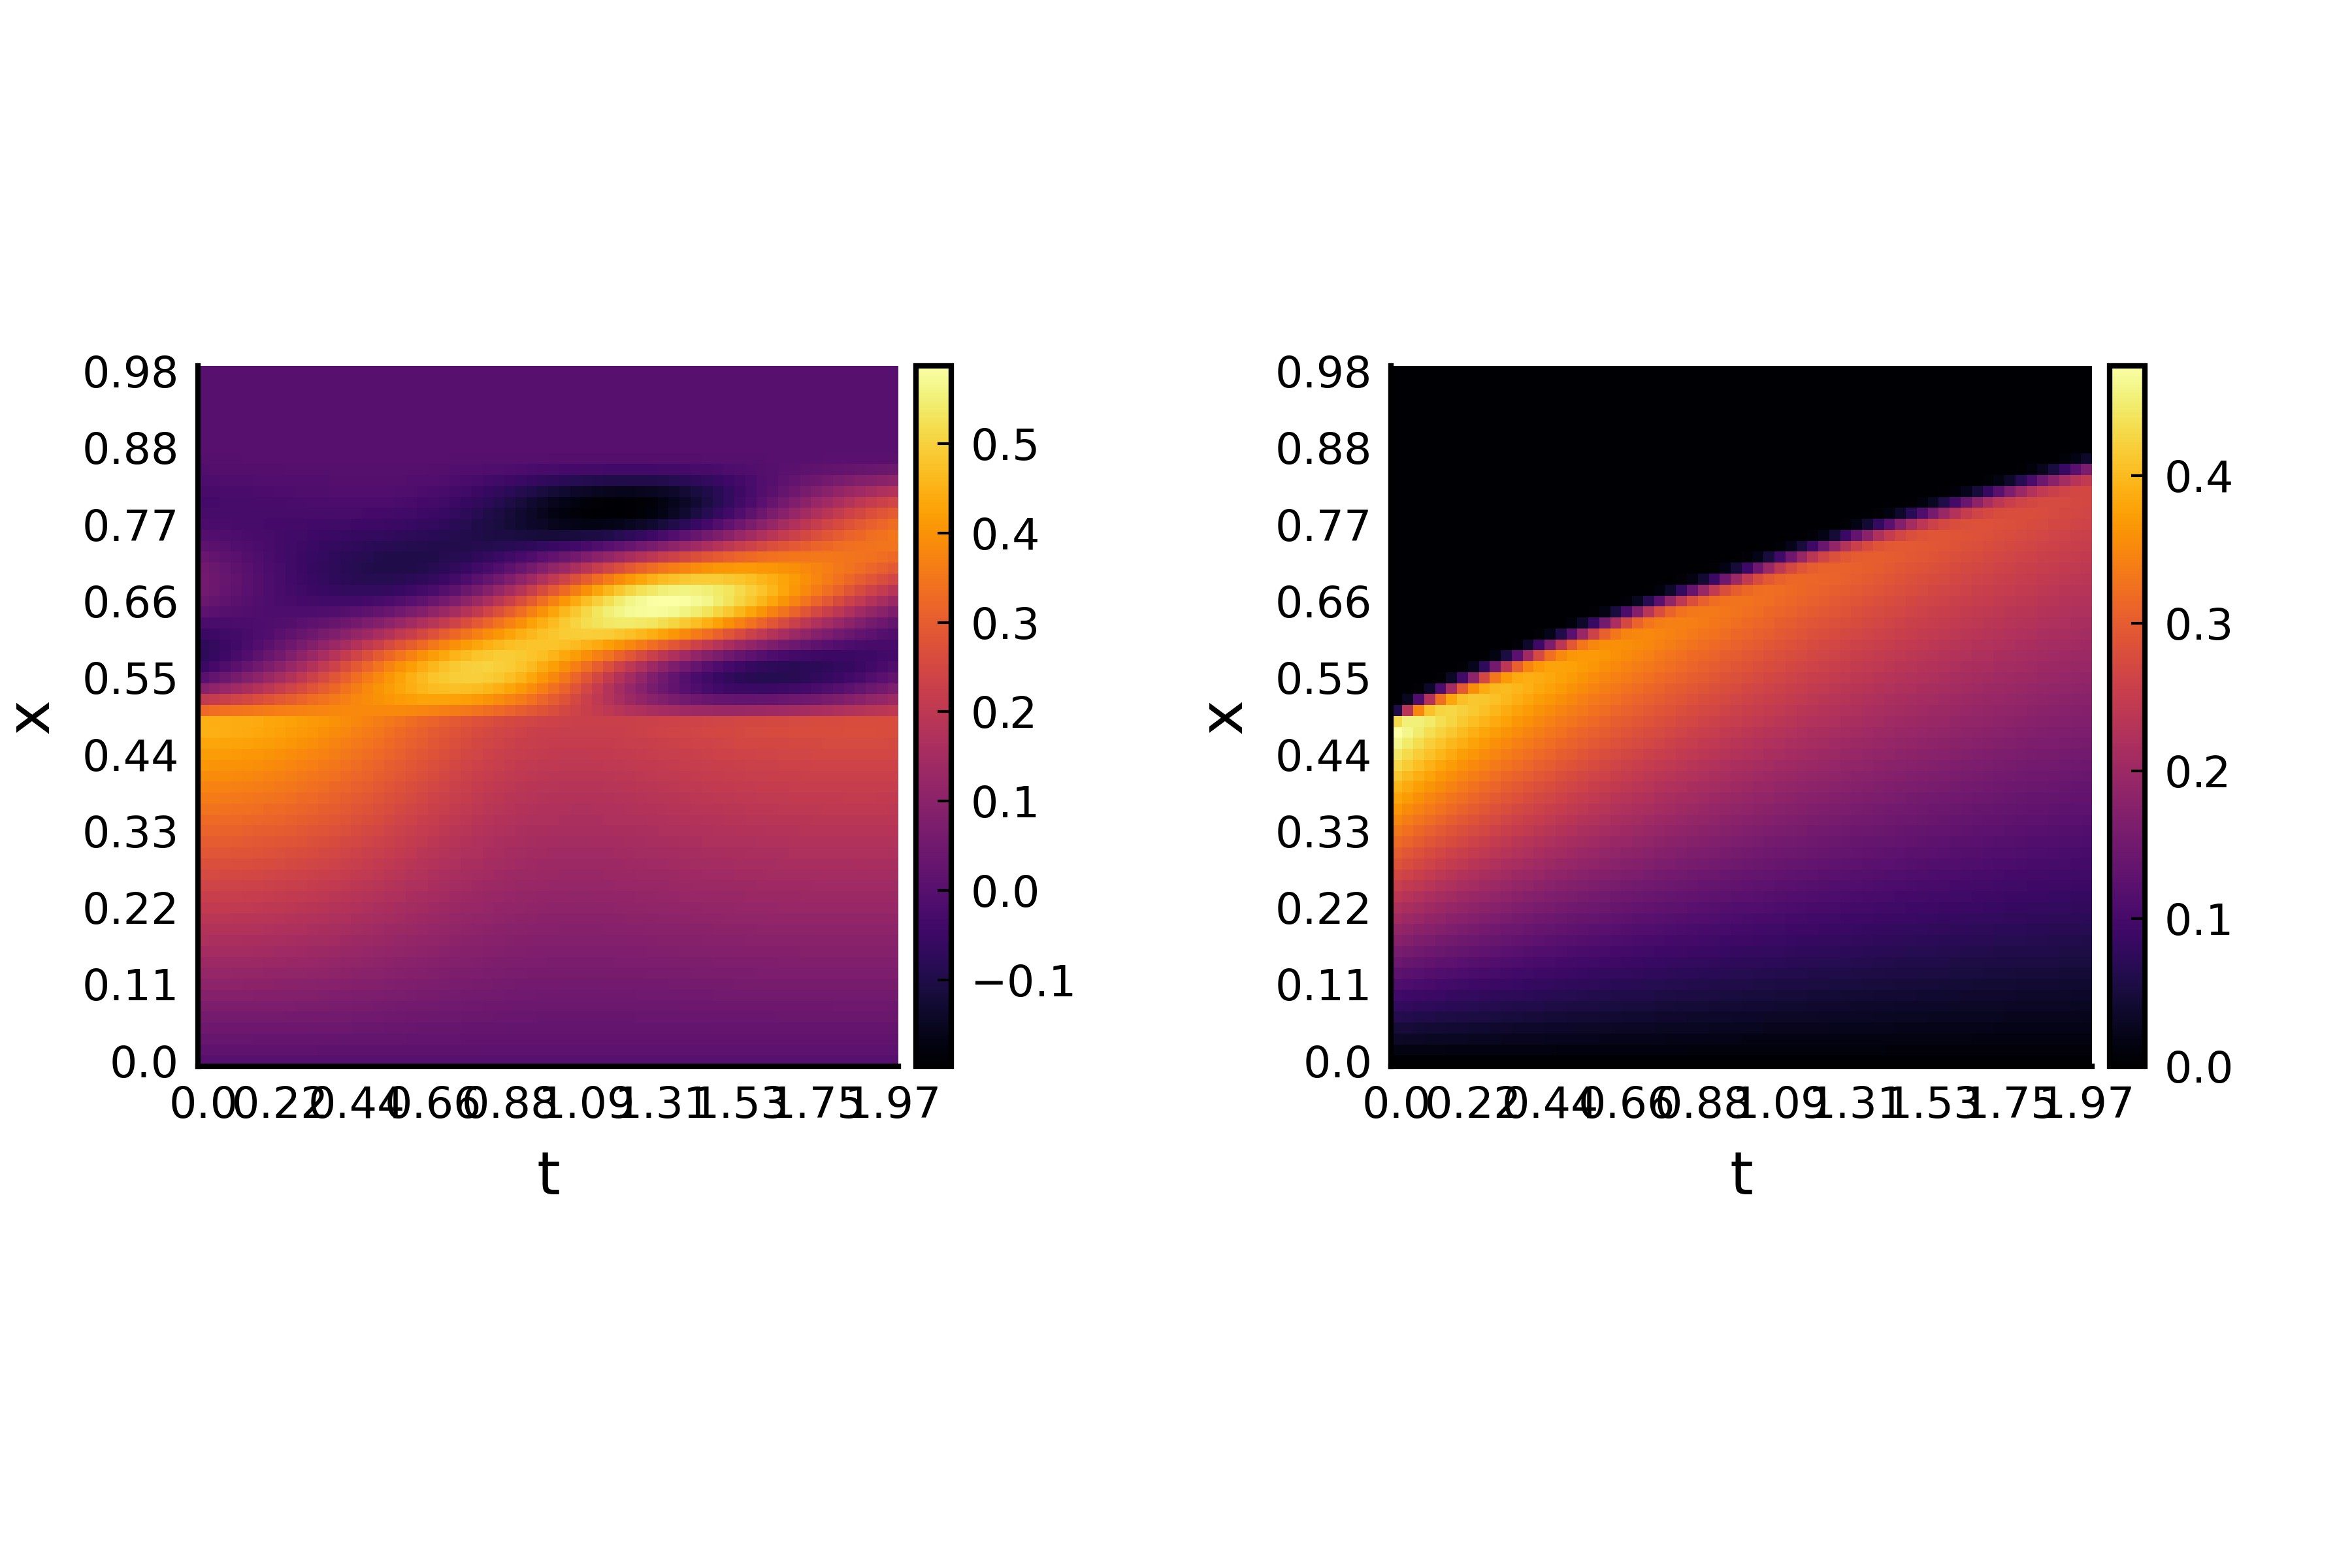

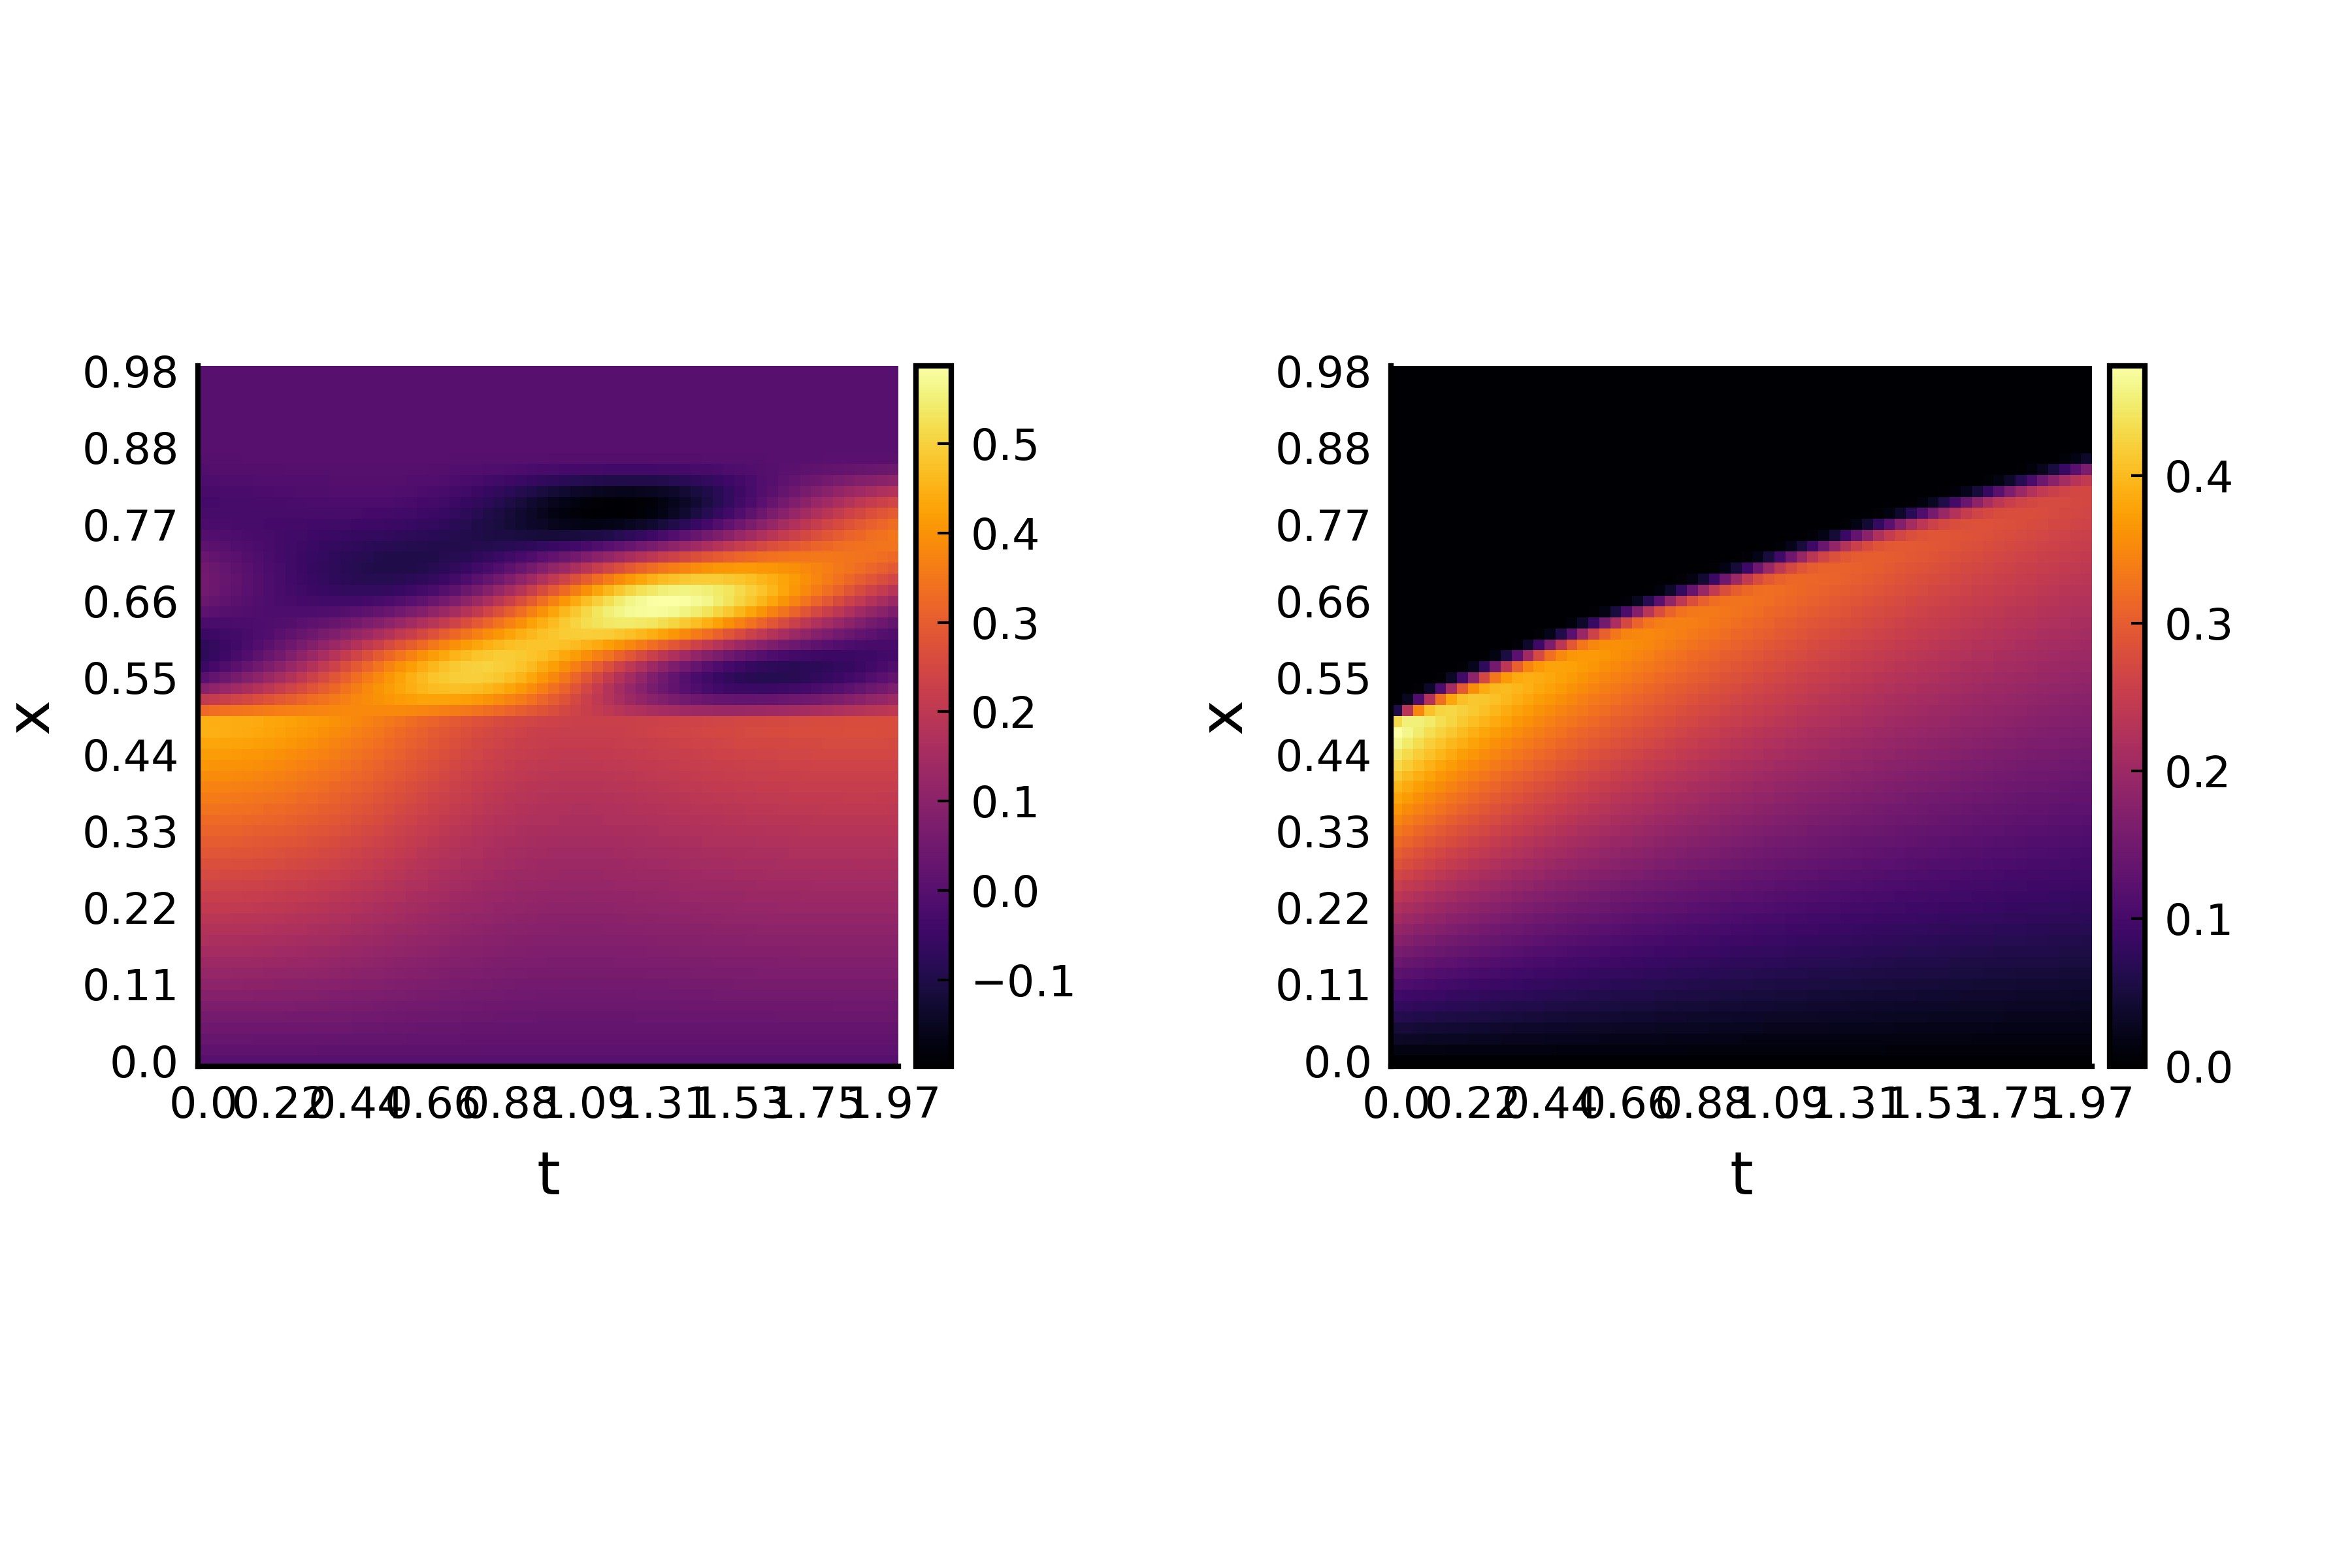

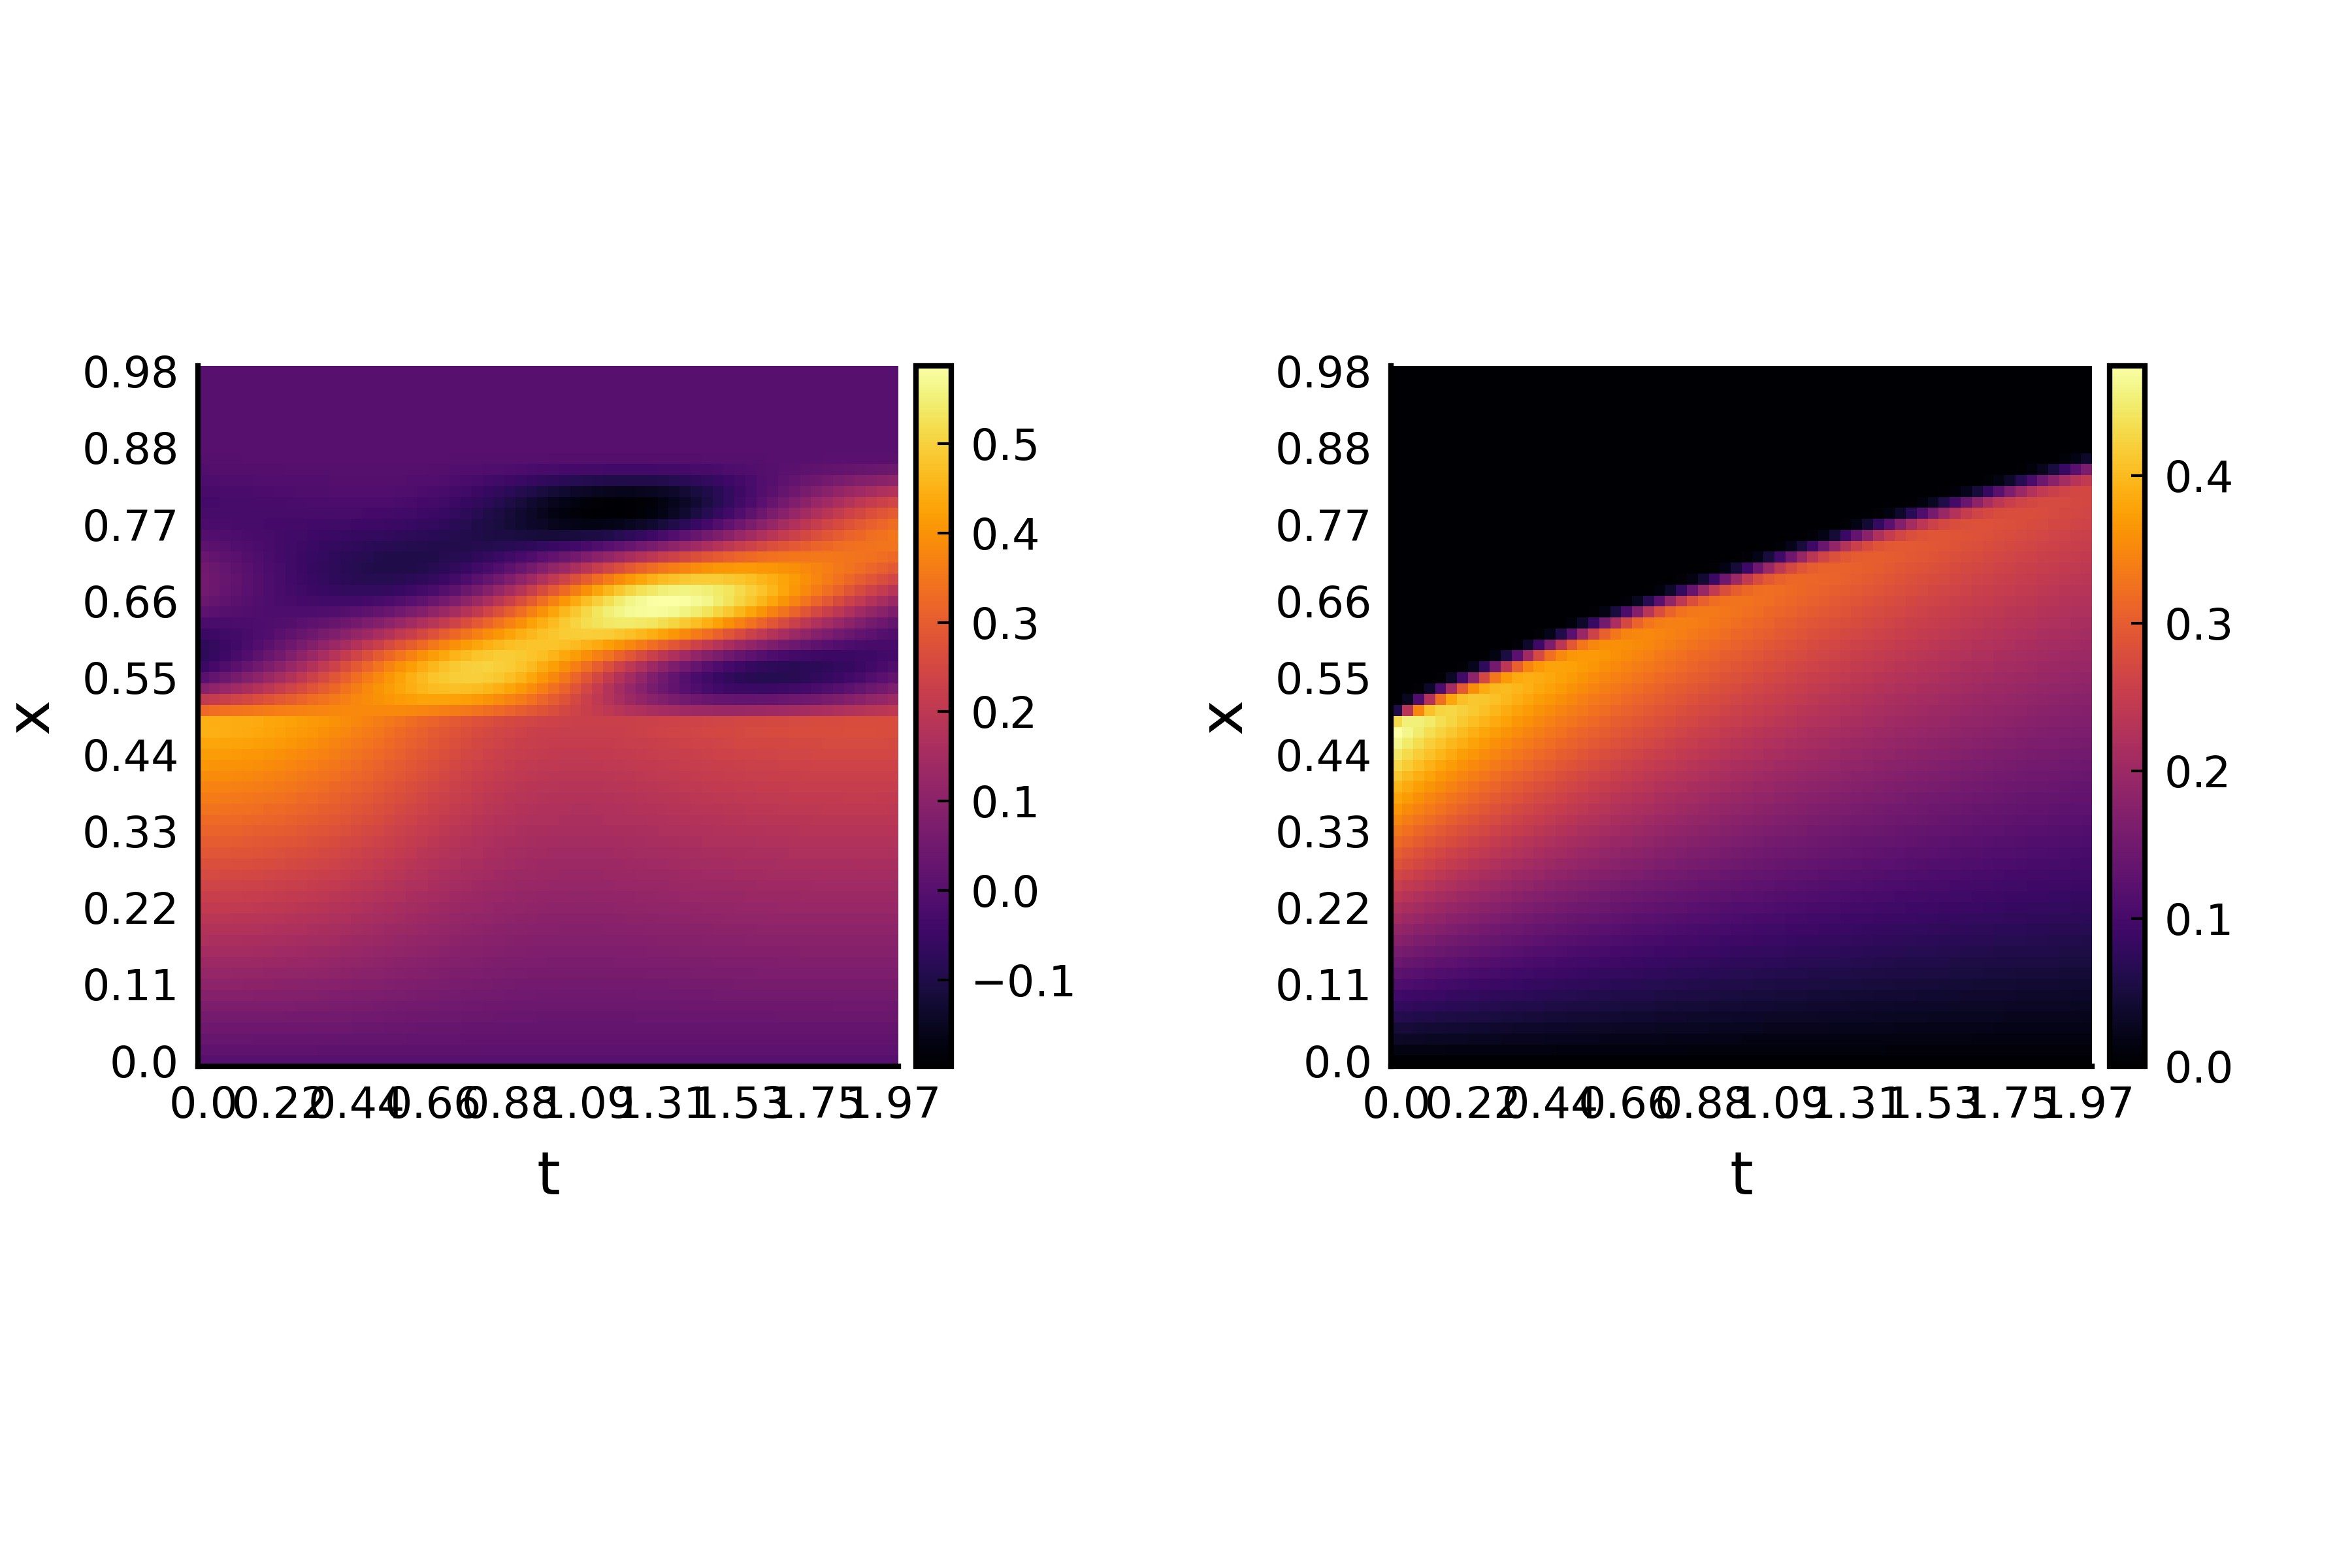

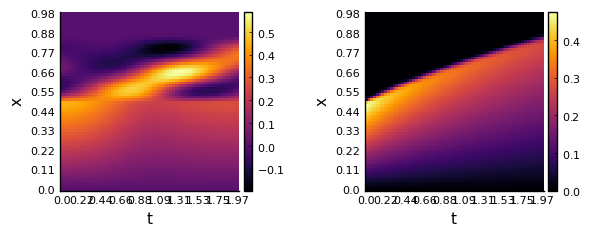

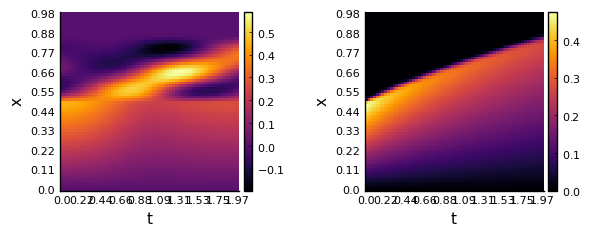

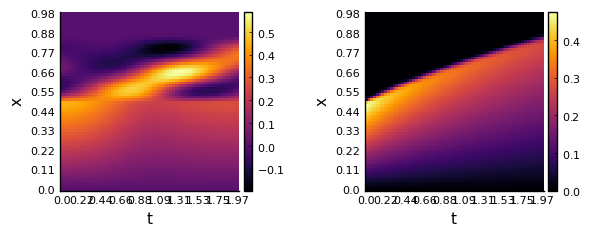

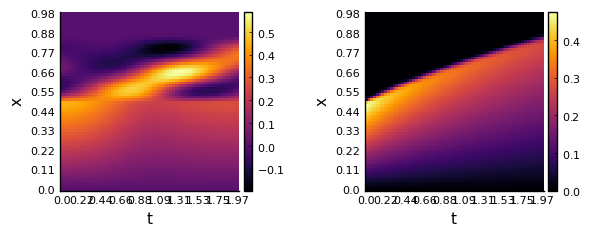

In [495]:
function check_training_dataset(dataset)
    for i in range(1, 4, step=1)
        _, b, _, d, _, _ = dataset[i];
        display(
            plot(
                GraphicTools.show_state(b, t, x ,"", "t", "x"),
                GraphicTools.show_state(d, t, x ,"", "t", "x");
                layout = (1, 2),
            )
        )
    end
end

check_training_dataset(dataset)

## Experiment with different models

### Heat linear model

In [ ]:
t, init_set, true_set = ProcessingTools.process_dataset(high_dataset, false);
net = Models.HeatModel(x_n);
result = burgers_training(net, 100, init_set, true_set, t);

In [ ]:
K = reshape(result, (x_n, x_n))
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
u_pred = Array(S(K, u0, t));  # S function at bottom of notebook

plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, ""),
    GraphicTools.show_state((u_pred .- u), "");
    layout = (1, 3),
)

##### Operator reconstructed

Visualize reconstructed operator and check efficiency to determine solution from unknown sample

In [ ]:
function f(u, K, t)
  return K * u
end

function S(net, u0, t)
  tspan = (t[1], t[end])
  prob = ODEProblem(ODEFunction(f), copy(u0), tspan, net)
  sol = solve(prob, Tsit5(), saveat=t, reltol=1e-8, abstol=1e-8)
end

In [ ]:
K = reshape(result, (x_n, x_n))
GraphicTools.show_state(reverse(K; dims = 1), "Operator K")

In [ ]:
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
u_pred = Array(S(K, u0, t));
plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, "");
    layout = (1, 2),
)

## Analysis

In [ ]:
function test_simulation(net, result, n, typ)
    mse_tot = 0
    l1_tot = 0
    for i in n
        t, u0, u_true = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, typ);
        prob_neuralode = DiffEqFlux.NeuralODE(net, (t[1], t[end]), Tsit5(), saveat=t)
        u_pred = prob_neuralode(u0, result)

        mse_tot += Objectives.mseloss(u_pred, u_true)
        l1_tot += sum(abs.(u_pred .- u_true))
    end
    
    return mse_tot / n, l1_tot / n
end

--- 
# Training with flux

In [304]:
del_dim(x::Array) = reshape(x, (size(x)[1], size(x)[3], size(x)[4]))

del_dim (generic function with 1 method)

In [398]:
function check_result(nn, res, typ)
    t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, typ);
    prob_neuralode = DiffEqFlux.NeuralODE(nn, (t[1], t[end]), Tsit5(), saveat=t)
    u_pred = prob_neuralode(add_dim(u0), res)
#     prob = ODEProblem{false}(nn, Nothing, (Nothing, Nothing));
#     u_pred = Array(solve(prob, Tsit5(), u0=add_dim(u0), p=p, abstol=1e-9, reltol=1e-9, saveat=t, sensealg=DiffEqSensitivity.BacksolveAdjoint()));
    
    plot(
        GraphicTools.show_state(u, ""),
        GraphicTools.show_state(hcat(u_pred.u...), ""),
        GraphicTools.show_err(hcat(u_pred.u...), u, "");
        layout = (1, 3),
    )
end

check_result (generic function with 1 method)

In [399]:
add_dim(x::Array{Float64, 1}) = reshape(x, (size(x)[1], 1, 1))
add_dim(x::Array{Float64}) = reshape(x, (size(x)[1], 1,  size(x)[2:end]...))

perm_dim(x::Vector{Any}, x_n::Int64, t_n::Int64) = permutedims(reshape(hcat(x...), x_n, t_n, :), (1, 3, 2));


function process_closure_dataset(dataset)
  n = size(dataset, 1);
  init_set = [];
  rom_set = [];
  true_set = [];
  t = [];

  for i in range(1, size(dataset, 1), step=1)
    t, ū, _, u, _, _ = dataset[i];

    push!(init_set, copy(u[:, 1]));
    push!(rom_set, copy(ū));
    push!(true_set, copy(u));
  end

  t_n = size(t, 1);
  x_n = size(init_set[1], 1);

  return t, hcat(init_set...), perm_dim(rom_set, x_n, t_n), perm_dim(true_set, x_n, t_n);
end

process_closure_dataset (generic function with 1 method)

In [400]:
function get_data_loader_rom(dataset, batch_size, ratio, split_axis=true, cuda=true)
  if cuda && CUDA.has_cuda()
    CUDA.allowscalar(false)
    device = Flux.gpu
  else
    device = Flux.cpu
  end

  t, init_set, rom_set, true_set = process_closure_dataset(dataset);

  # True solution
  if (split_axis)
    t_train, t_val = splitobs(t, at = ratio);
    train_rom_set, val_rom_set = splitobs(rom_set, at = ratio);
    train_set, val_set = splitobs(true_set, at = ratio);
  else
    t_train, t_val = copy(t), copy(t);

    switch_true_set = permutedims(true_set, (1, 3, 2));
    switch_rom_set = permutedims(rom_set, (1, 3, 2));

    train_set, val_set = splitobs(switch_true_set, at = ratio);
    train_set = permutedims(train_set, (1, 3, 2));
    val_set = permutedims(val_set, (1, 3, 2));

    train_rom_set, val_rom_set = splitobs(switch_rom_set, at = ratio);
    train_rom_set = permutedims(train_rom_set, (1, 3, 2));
    val_rom_set = permutedims(val_rom_set, (1, 3, 2));
  end

  # Initial condition
  init_train = add_dim(copy(train_set[:, :, 1]));
  init_val = add_dim(copy(val_set[:, :, 1]));

  train_rom_set = permutedims(train_rom_set, (1, 3, 2));
  val_rom_set = permutedims(val_rom_set, (1, 3, 2));

  train_set = permutedims(train_set, (1, 3, 2));
  val_set = permutedims(val_set, (1, 3, 2));

  # Set size
  n_train = size(train_set, 3)
  n_val = size(val_set, 3)

  # Set data loader
  train_data = (init_train |> device, train_rom_set, train_set |> device, collect(ncycle([collect(t_train)], n_train)))
  val_data = (init_val |> device, val_rom_set, val_set |> device,  collect(ncycle([collect(t_val)], n_val)))

  train_loader = DataLoader(train_data, batchsize=batch_size, shuffle=true);
  val_loader = DataLoader(val_data, batchsize=n_val, shuffle=false);

  return (train_loader, val_loader)
end

get_data_loader_rom (generic function with 3 methods)

In [401]:
function training(model, epochs, dataset, opt, batch_size, ratio, noise=0., sol=Tsit5(), cuda=false)
   if cuda && CUDA.has_cuda()
      device = Flux.gpu
      CUDA.allowscalar(false)
      @info "Training on GPU"
  else
      device = Flux.cpu
      @info "Training on CPU"
  end

  # Monitoring
  ep = 0;
  count = 0;
  lval = 0.;

  @info("Loading dataset")
  (train_loader, val_loader) = get_data_loader_rom(dataset, batch_size, ratio, false, cuda);

  @info("Building model")
  model_gpu = model |> device;
  p, re = Flux.destructure(model_gpu);
  p = p |> device;

  net(u, p, t) = re(p)(u);
  g = (u, p, t) -> f(u);
  
  function predict_neural_ode(θ, x, t)
    tspan = (float(t[1]), float(t[end]));
    _prob = ODEProblem(net, x, tspan, θ);
    ŷ = device(solve(_prob, sol, u0=x, p=θ, abstol=1e-6, reltol=1e-6, saveat=t));
    return permutedims(del_dim(ŷ), (1, 3, 2));
  end

  function loss(θ, x, ȳ, y, t)
    x̂ = Reg.gaussian_augment(x, noise);
    ŷ = predict_neural_ode(θ, x̂, t[1]);
    print(ȳ .+ ŷ .- y)
    l = Flux.mse(ȳ .+ ŷ, y)
    return l;
  end

  function val_loss(θ, x, ȳ, y, t)
    ŷ = predict_neural_ode(θ, x, t[1]);
    l = Flux.mse(ȳ .+ ŷ, y)
    return l;
  end

  function cb(θ, l)
    @show(l)
    count += 1;

    iter = (train_loader.nobs / train_loader.batchsize);
    if (count % iter == 0)
      ep += 1;
      count = 0;
      lval = 0;

      for (x, ȳ, y, t) in val_loader
        (x, ȳ, y, t) = (x, ȳ, y, t) |> device;
        lval += val_loss(θ, x, ȳ, y, t);
      end # 60

      lval /= (val_loader.nobs / val_loader.batchsize);
      @info("Epoch ", ep, lval);
    end

    return false
  end

  @info("Initiate training")
  @info("ADAMW")  # 70
  optf = OptimizationFunction((θ, p, x, ȳ, y, t) -> loss(θ, x, ȳ, y, t), Optimization.AutoZygote())
  optprob = Optimization.OptimizationProblem(optf, p)
  result_neuralode = Optimization.solve(optprob, opt, ncycle(train_loader, epochs), callback=cb)

  return re(result_neuralode.u), p, lval
end

training (generic function with 4 methods)

In [ ]:
function main()
  batch_size = 16;
  epochs = 1;

  data = dataset_gp;
  # data = Generator.read_dataset("./src/examples/burgers/dataset/inviscid_pod_gp_burgers_high_dim_m10_256_j173.jld2")["training_set"];
  opt = OptimizationOptimisers.ADAMW(0.001, (0.9, 0.999), 1e-7);
  model = Models.CNN2(9, [2, 2, 1]);
  K, p, _ = training(model, epochs, data, opt, batch_size, 0.75, 0.1, Tsit5());
  return K, p
end

K, p = main()

┌ Info: Training on CPU
└ @ Main In[401]:8
┌ Info: Loading dataset
└ @ Main In[401]:16
┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 3
└ @ MLUtils /Users/vdesgrange/.julia/packages/MLUtils/W3W0A/src/dataloader.jl:79
┌ Info: Building model
└ @ Main In[401]:19


In [ ]:
# @save "./src/examples/burgers/models/BurgersBasicAutoEncoderModel.bson" K
@load "./src/examples/burgers/models/cnn_viscous_256_3/burgers_e400_worker_85_iter_5.bson" K p

In [ ]:
# add_dim(x::Array{Float64, 1}) = reshape(x, (size(x)[1], 1, 1, 1))
# add_dim(x::Array) = reshape(x, (size(x)[1], 1, 1, size(x)[2]))
# del_dim(x::Array) = reshape(x, (size(x)[1], size(x)[4], size(x)[5]))
add_dim(x::Array{Float64, 1}) = reshape(x, (size(x)[1], 1, 1))
add_dim(x::Array) = reshape(x, (size(x)[1], 1, size(x)[2]))
del_dim(x::Array) = reshape(x, (size(x)[1], size(x)[3], size(x)[4]))

In [ ]:
# check_result(K, p, 2)
init_kwargs = (; mu=10);
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2, init_kwargs);
prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), Tsit5(), saveat=t)
u_pred = prob_neuralode(add_dim(u0))
GraphicTools.show_state(u, "")

In [ ]:
GraphicTools.show_state(hcat(u_pred.u...)[:, :], "") # [:, :, 1, 1]

In [ ]:
Flux.mse(hcat(u_pred.u...)[:, :], u)

In [ ]:
GraphicTools.show_err(hcat(u_pred.u...)[:, :], u, "")

In [ ]:
bas, ū = POD.generate_pod_basis(u, true);
ϕ = bas.modes;
Ū = Equations.galerkin_projection(t, u, ϕ[:, 1:end], 0.001, dx, dt);
GraphicTools.show_state(Ū, "")

In [ ]:
GraphicTools.show_state(Ū .+ hcat(u_pred.u...)[:, :], "")

In [ ]:
data = Generator.read_dataset("./src/examples/burgers/dataset/burgers_high_dim_training_set.jld2")["training_set"];
t, u0, u = ProcessingTools.process_dataset(data, false);
prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), Rosenbrock23(), saveat=t);
i = 43
u_pred = prob_neuralode(u0[:, i], p);
display(
    plot(
        GraphicTools.show_state(u[:, i, :], ""),
        GraphicTools.show_state(hcat(u_pred.u...), ""),
        GraphicTools.show_err(hcat(u_pred.u...), u[:, i, :], "");
        layout = (1, 3),
    )
)